# The Nature Conservancy Fisheries Monitoring

https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring

In [1]:
%matplotlib inline
import cv2
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
import sys


!ls ../input/

hw_fish  test-stg2  the-nature-conservancy-fisheries-monitoring


# Загружаем разметку

In [2]:
import os
import json
from glob import glob

# TODO: скачайте данные и сохраните в директорию:
TRAIN_PREFIX = '../input/the-nature-conservancy-fisheries-monitoring/train'

def load_boxes():
    boxes = dict()
    for path in glob('../input/hw_fish/*.json'):
        label = os.path.basename(path).split('_', 1)[0]
        print('label = ', label)
        with open(path) as src:
            boxes[label] = json.load(src)
            for annotation in boxes[label]:
                basename = os.path.basename(annotation['filename'])
                annotation['filename'] = os.path.join(TRAIN_PREFIX, label.upper(), basename)
                annotation['fish_class'] = label
            for annotation in boxes[label]:
                for rect in annotation['annotations']:
                    rect['x'] += rect['width'] / 2
                    rect['y'] += rect['height'] / 2
    #print('annotation = ', annotation)
    #print('boxes = ', boxes)
    return boxes

def draw_boxes(annotation, rectangles=None, image_size=None):
    #print(annotation)
    def _draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for rect in rectangles:
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2, 
                                color=color, thickness=4)
        return img
    
    scale_x, scale_y = 1., 1.
    
    img = cv2.imread(annotation['filename'], cv2.IMREAD_COLOR)[...,::-1]
    if image_size is not None:
        scale_x = 1. * image_size[0] / img.shape[1]
        scale_y = 1. * image_size[1] / img.shape[0]
        img = cv2.resize(img, image_size)
        
    img = _draw(img, annotation['annotations'], scale_x, scale_y)
    
    if rectangles is not None:
        img = _draw(img, rectangles, 1., 1., (255, 0, 0))

    return img

### Визуализируем разметку

In [3]:
boxes = load_boxes()  # разметка детекций
#print('boxes = ', boxes['lag'][1])

label =  lag
label =  shark
label =  yft
label =  dol
label =  bet
label =  alb


In [4]:
pd.DataFrame([(k, len(v)) for k, v in boxes.items()],
             columns=['class', 'count'])

,class,count
0,lag,67
1,shark,176
2,yft,734
3,dol,117
4,bet,200
5,alb,1719


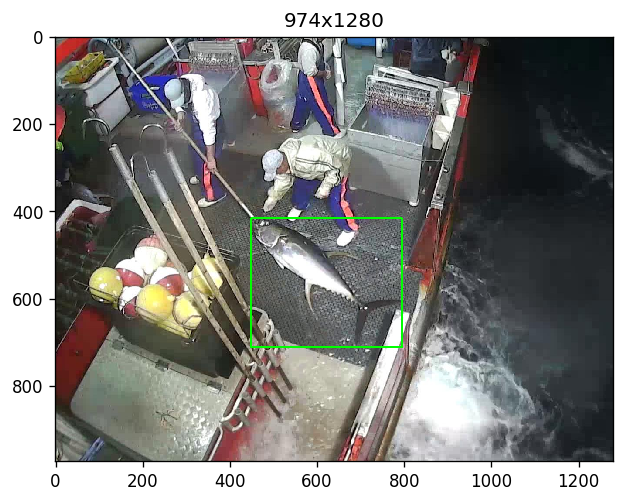

In [5]:
plt.figure(figsize=(6, 6), dpi=120)
img = draw_boxes(boxes['yft'][60])
plt.imshow(img)
plt.title('{}x{}'.format(*img.shape));

### Распределение размеров разметки

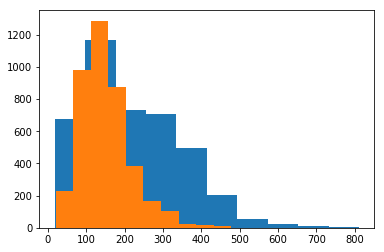

In [6]:
annotations = sum([box['annotations']
                  for box in sum(boxes.values(), [])], [])

#print('annotations = ', annotations)

widths = [rect['width'] for rect in annotations]
heights = [rect['height'] for rect in annotations]

plt.hist(widths)
plt.hist(heights);

# Экстрактор признаков

In [7]:
IMG_HEIGHT = 750
IMG_WIDTH = 1200

features = keras.applications.vgg16.VGG16(include_top=False,
                                          weights='imagenet',
                                          input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

feature_tensor = features.layers[-1].output
print('feature_tensor = ', feature_tensor)

# дообучаем последние 5 слоев
for layer in features.layers[:-5]:
    layer.trainable = False

#features.summary()

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 2s 0us/step
feature_tensor =  Tensor("block5_pool/MaxPool:0", shape=(?, 23, 37, 512), dtype=float32)


# Сетка якорей (anchor grid)

In [8]:
FEATURE_SHAPE = (feature_tensor.shape[1].value,
                 feature_tensor.shape[2].value)

#print('features = ', features.summary())
#print('FEATURE_SHAPE = ', feature_tensor.shape)

GRID_STEP_H = IMG_HEIGHT / FEATURE_SHAPE[0]
GRID_STEP_W = IMG_WIDTH / FEATURE_SHAPE[1]

ANCHOR_WIDTH = 150.
ANCHOR_HEIGHT = 150. 

ANCHOR_CENTERS = np.mgrid[GRID_STEP_H/2:IMG_HEIGHT:GRID_STEP_H,
                          GRID_STEP_W/2:IMG_WIDTH:GRID_STEP_W]

#print(ANCHOR_CENTERS)

In [9]:
def iou(rect, x_scale, y_scale, anchor_x, anchor_y,
        anchor_w=ANCHOR_WIDTH, anchor_h=ANCHOR_HEIGHT):
    
    rect_x1 = (rect['x'] - rect['width'] / 2) * x_scale
    rect_x2 = (rect['x'] + rect['width'] / 2) * x_scale
    
    rect_y1 = (rect['y'] - rect['height'] / 2) * y_scale
    rect_y2 = (rect['y'] + rect['height'] / 2) * y_scale
    
    anch_x1, anch_x2 = anchor_x - anchor_w / 2, anchor_x + anchor_w / 2
    anch_y1, anch_y2 = anchor_y - anchor_h / 2, anchor_y + anchor_h / 2
    
    dx = (min(rect_x2, anch_x2) - max(rect_x1, anch_x1))
    dy = (min(rect_y2, anch_y2) - max(rect_y1, anch_y1))
    
    intersection = dx * dy if (dx > 0 and dy > 0) else 0.
    
    anch_square = (anch_x2 - anch_x1) * (anch_y2 - anch_y1)
    rect_square = (rect_x2 - rect_x1) * (rect_y2 - rect_y1)
    union = anch_square + rect_square - intersection
    
    return intersection / union

def encode_anchors(annotation, img_shape, iou_thr=0.5):
    #print('annotation = ', annotation)
    #print('img_shape = ', img_shape)
    #print('iou_thr = ', iou_thr)
    encoded = np.zeros(shape=(FEATURE_SHAPE[0],
                              FEATURE_SHAPE[1], 11), dtype=np.float32)
    x_scale = 1. * IMG_WIDTH / img_shape[1]
    y_scale = 1. * IMG_HEIGHT / img_shape[0]
    for rect in annotation['annotations']:
        scores = []
        for row in range(FEATURE_SHAPE[0]):
            for col in range(FEATURE_SHAPE[1]):
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                score = iou(rect, x_scale, y_scale, anchor_x, anchor_y)
                scores.append((score, anchor_x, anchor_y, row, col))
        
        scores = sorted(scores, reverse=True)
        #print('scores = ', scores)
        if scores[0][0] < iou_thr:
            scores = [scores[0]]  # default anchor
        else:
            scores = [e for e in scores if e[0] > iou_thr]

        for score, anchor_x, anchor_y, row, col in scores:
            dx = (anchor_x - rect['x'] * x_scale) / ANCHOR_WIDTH
            dy = (anchor_y - rect['y'] * y_scale) / ANCHOR_HEIGHT
            dw = (ANCHOR_WIDTH - rect['width'] * x_scale) / ANCHOR_WIDTH
            dh = (ANCHOR_HEIGHT - rect['height'] * y_scale) / ANCHOR_HEIGHT
            fc = annotation['fish_class'].lower()
            encoded[row, col] = [1, float(fc == 'lag'), float(fc == 'shark'), float(fc == 'ytf'), float(fc == 'dol'), float(fc == 'bet'), float(fc == 'alb'), dx, dy, dw, dh]
            
    return encoded

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def decode_prediction(prediction, conf_thr=0.1):
    rectangles = []
    for row in range(FEATURE_SHAPE[0]):
        for col in range(FEATURE_SHAPE[1]):
            logit, lag, shark, yft, dol, bet, alb, dx, dy, dw, dh = prediction[row, col]
            conf = _sigmoid(logit)
            lag = _sigmoid(lag)
            shark = _sigmoid(shark)
            yft = _sigmoid( yft)
            dol = _sigmoid(dol)
            bet = _sigmoid(bet)
            alb = _sigmoid(alb)
            
            if conf > conf_thr:
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                rectangles.append({'x': anchor_x - dx * ANCHOR_WIDTH,
                                   'y': anchor_y - dy * ANCHOR_HEIGHT,
                                   'width': ANCHOR_WIDTH - dw * ANCHOR_WIDTH,
                                   'height': ANCHOR_HEIGHT - dh * ANCHOR_HEIGHT,
                                   'conf': conf,
                                   'lag': lag,
                                   'shark': shark,
                                   'yft': yft,
                                   'dol': dol,
                                   'bet': bet,
                                   'alb': alb
                                  })
    return rectangles

### Валидация енкодинга/декодинга

exmaple =  {'annotations': [{'class': 'rect', 'height': 182.0000000000008, 'width': 322.0000000000015, 'x': 780.0000000000034, 'y': 170.00000000000074}], 'class': 'image', 'filename': '../input/the-nature-conservancy-fisheries-monitoring/train/ALB/img_07223.jpg', 'fish_class': 'alb'}
encoded shape =  (23, 37, 11)
decoded =  [{'x': 780.0000008699058, 'y': 170.00000021703866, 'width': 321.9999969005585, 'height': 182.00000077486038, 'conf': 0.731058573739949, 'lag': 0.5, 'shark': 0.5, 'yft': 0.5, 'dol': 0.5, 'bet': 0.5, 'alb': 0.731058573739949}]


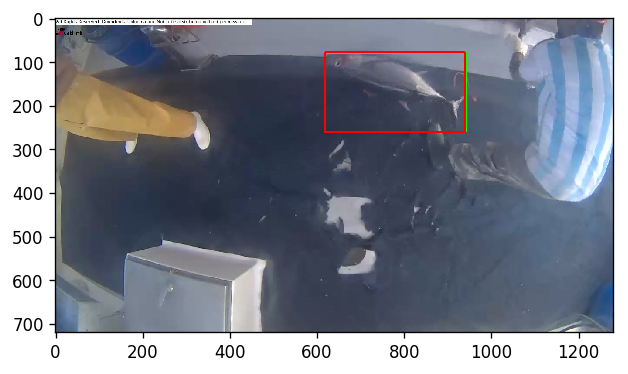

In [10]:
example = boxes['alb'][175]
print('exmaple = ', example)

encoded = encode_anchors(example, (IMG_HEIGHT, IMG_WIDTH))

np.set_printoptions(threshold=10)
print('encoded shape = ', encoded.shape)

decoded = decode_prediction(encoded, conf_thr=0.5)
print('decoded = ', decoded)
decoded = sorted(decoded, key = lambda e: -e['conf'])

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(draw_boxes(example, decoded[:11]))

## Функция потерь

In [11]:
from keras.callbacks import Callback
K = tf.keras.backend

def confidence_loss(y_true, y_pred):
    conf_loss = K.binary_crossentropy(y_true[..., 0], 
                                      y_pred[..., 0],
                                      from_logits=True)
    return conf_loss

def classification_loss(y_true, y_pred):
    class_loss = K.categorical_crossentropy(y_true[..., 1:7], 
                                      y_pred[..., 1:7],
                                      from_logits=True)
    
    pos_class_loss_1 = K.sum(class_loss * y_true[..., 1], axis=-1)
    pos_class_loss_2 = K.sum(class_loss * y_true[..., 2], axis=-1)
    pos_class_loss_3 = K.sum(class_loss * y_true[..., 3], axis=-1)
    pos_class_loss_4 = K.sum(class_loss * y_true[..., 4], axis=-1)
    pos_class_loss_5 = K.sum(class_loss * y_true[..., 5], axis=-1)
    pos_class_loss_6 = K.sum(class_loss * y_true[..., 6], axis=-1)
    
    num_pos_1 = K.sum(y_true[..., 1], axis=-1)
    num_pos_2 = K.sum(y_true[..., 2], axis=-1)
    num_pos_3 = K.sum(y_true[..., 3], axis=-1)
    num_pos_4 = K.sum(y_true[..., 4], axis=-1)
    num_pos_5 = K.sum(y_true[..., 5], axis=-1)
    num_pos_6 = K.sum(y_true[..., 6], axis=-1)
    
    total_class_loss_1 = pos_class_loss_1 / (num_pos_1 + 1e-32)
    total_class_loss_2 = pos_class_loss_2 / (num_pos_2 + 1e-32)
    total_class_loss_3 = pos_class_loss_3 / (num_pos_3 + 1e-32)
    total_class_loss_4 = pos_class_loss_4 / (num_pos_4 + 1e-32)
    total_class_loss_5 = pos_class_loss_5 / (num_pos_5 + 1e-32)
    total_class_loss_6 = pos_class_loss_6 / (num_pos_6 + 1e-32)
    
    loss = total_class_loss_1 + total_class_loss_2 + total_class_loss_3 + total_class_loss_4 + total_class_loss_5 + total_class_loss_6
    return loss / 6


def smooth_l1(y_true, y_pred):
    abs_loss = K.abs(y_true[..., 7:] - y_pred[..., 7:])
    square_loss = 0.5 * K.square(y_true[..., 7:] - y_pred[..., 7:])
    mask = K.cast(K.greater(abs_loss, 1.), 'float32')
    total_loss = (abs_loss - 0.5) * mask + 0.5 * square_loss * (1. - mask)
    return K.sum(total_loss, axis=-1)



@tf.contrib.eager.defun
def total_loss(y_true, y_pred, neg_pos_ratio=3):
    batch_size = K.shape(y_true)[0]
    # TODO: добавьте функцию потерь для классификации детекции
    
    y_true = K.reshape(y_true, (batch_size, -1, 11))
    y_pred = K.reshape(y_pred, (batch_size, -1, 11))
    
    # confidence loss
    conf_loss = confidence_loss(y_true, y_pred)
    
    # class loss
    class_loss = classification_loss(y_true, y_pred)
    
    # smooth l1 loss
    loc_loss = smooth_l1(y_true, y_pred)
    
    # positive examples loss
    pos_conf_loss = K.sum(conf_loss * y_true[..., 0], axis=-1)
    pos_loc_loss = K.sum(loc_loss * y_true[..., 0], axis=-1)
    
    
    # negative examples loss
    anchors = K.shape(y_true)[1]
    print('anchors', anchors)
    num_pos = K.sum(y_true[..., 0], axis=-1)
    print('num_pos', num_pos)
    
    num_pos_avg = K.mean(num_pos)
    print('num_pos_avg', num_pos_avg)
    
    num_neg = K.min([neg_pos_ratio * (num_pos_avg) + 1., K.cast(anchors, 'float32')])
    print('num_neg', num_neg)
    
    # hard negative mining
    neg_conf_loss, _ = tf.nn.top_k(conf_loss * (1. - y_true[..., 0]),
                                   k=K.cast(num_neg, 'int32'))

    neg_conf_loss = K.sum(neg_conf_loss, axis=-1)
    
    # class loss negative 
    #neg_class_loss, _ = tf.nn.top_k(class_loss * (1. - y_true[..., 1:7]),
    #                               k=K.cast(num_neg, 'int32'))

    #neg_class_loss = K.sum(neg_class_loss, axis=-1)
    
    # total conf loss
    total_conf_loss = (neg_conf_loss + pos_conf_loss) / (num_neg + num_pos + 1e-32)
    loc_loss = pos_loc_loss / (num_pos + 1e-32)
    
    # total class loss
    #total_class_loss = class_loss
    
    loss = total_conf_loss + 0.5 * loc_loss + 0.25 * class_loss
    return loss

Using TensorFlow backend.



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



## Загрузка данных

In [12]:
def load_img(path, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    img = cv2.imread(path, cv2.IMREAD_COLOR)[...,::-1]
    img_shape = img.shape
    img_resized = cv2.resize(img, target_size)
    return img_shape, keras.applications.vgg16.preprocess_input(img_resized.astype(np.float32))

def data_generator(boxes, batch_size=32):
    boxes = sum(boxes.values(), [])
    while True:
        #print('gen data', boxes)
        random.shuffle(boxes)
        for i in range(len(boxes)//batch_size):
            X, y = [], []
            for j in range(i*batch_size,(i+1)*batch_size):
                img_shape, img = load_img(boxes[j]['filename'])
                # TODO: добавьте one-hot encoding в разметку для классов
                y.append(encode_anchors(boxes[j], img_shape))
                X.append(img)
            print('np.array(X).shape', np.array(X).shape)
            print('np.array(y).shape', np.array(y).shape)
            yield np.array(X), np.array(y)

## Добавляем выход детектора

In [13]:
output = keras.layers.BatchNormalization()(feature_tensor)
print('otput.shape', output.shape)

# TODO: добавьте выходы для классификации детекции
output = keras.layers.Conv2D(11,
                             kernel_size=(1, 1), 
                             activation='linear',
                             padding="same",
                             kernel_regularizer='l2')(output)
print(output)
#output = keras.layers.Flatten()(output)
#output = keras.layers.Dense(11, activation='relu')(output)
#output = keras.layers.Dense(11, activation='softmax')(output)
print(features.inputs)
model = keras.models.Model(inputs=features.inputs, outputs=output)
model.summary()

otput.shape (?, 23, 37, 512)
Tensor("conv2d/BiasAdd:0", shape=(?, 23, 37, 11), dtype=float32)
[<tf.Tensor 'input_1:0' shape=(?, 750, 1200, 3) dtype=float32>]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 750, 1200, 3)      0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 750, 1200, 64)     1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 750, 1200, 64)     36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 375, 600, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 375, 600, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 375, 600, 128)

## Обучение

In [14]:
adam = keras.optimizers.Adam(lr=3e-4, decay=1e-6)
model.compile(optimizer=adam, 
              loss=total_loss,
              metrics={'conf_loss': confidence_loss})

anchors Tensor("strided_slice_23:0", shape=(), dtype=int32)
num_pos Tensor("Sum_15:0", shape=(?,), dtype=float32)
num_pos_avg Tensor("Mean:0", shape=(), dtype=float32)
num_neg Tensor("Min:0", shape=(), dtype=float32)


In [15]:
class ComputeMetrics(Callback):
    def on_epoch_end(self, epoch, logs):
        logs['val_metric'] = epoch ** 2  # replace it with your metrics
        if (epoch + 1) % 10 == 0:
            logs['test_metric'] = epoch ** 3  # same
        else:
            logs['test_metric'] = np.nan
            
batch_size = 5
steps_per_epoch = int(sum(map(len, boxes.values()), 0) / batch_size)
print(steps_per_epoch)

gen = data_generator(boxes, batch_size=batch_size)

checkpoint = keras.callbacks.ModelCheckpoint(
    'weights.{epoch:02d}-{loss:.3f}.hdf5',
    monitor='loss',
    verbose=1,  
    save_best_only=True, 
    save_weights_only=False,
    mode='auto', period=1)

lambda_cb = keras.callbacks.LambdaCallback(
    on_batch_begin=lambda batch,logs: print('!!!!!!++++', batch)
)

model.fit_generator(generator=gen, 
                    steps_per_epoch=steps_per_epoch,
                    epochs=1,
                    callbacks=[checkpoint]
    )

602
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
  1/602 [.....................

 62/602 [==>...........................] - ETA: 4:17 - loss: 2.1139np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
 63/602 [==>...........................] - ETA: 4:17 - loss: 2.1030np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
 64/602 [==>...........................] - ETA: 4:16 - loss: 2.0898np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
 65/602 [==>...........................] - ETA: 4:14 - loss: 2.0787np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
 66/602 [==>...........................] - ETA: 4:13 - loss: 2.0630np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
 68/602 [==>...........................] - ETA: 4:11 - loss: 2.0366np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
 69/602 [==>..........................

123/602 [=====>........................] - ETA: 3:28 - loss: 1.5638np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
124/602 [=====>........................] - ETA: 3:27 - loss: 1.5578np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
126/602 [=====>........................] - ETA: 3:26 - loss: 1.5466 (5, 23, 37, 11)
np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
128/602 [=====>........................] - ETA: 3:25 - loss: 1.5366np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
129/602 [=====>........................] - ETA: 3:24 - loss: 1.5316np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
130/602 [=====>........................] - ETA: 3:24 - loss: 1.5268np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
131/602 [=====>........................] - ETA: 3:23 - loss: 1.5222np.array(X).shape (5, 75

184/602 [========>.....................] - ETA: 2:54 - loss: 1.3225np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
185/602 [========>.....................] - ETA: 2:54 - loss: 1.3193np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
186/602 [========>.....................] - ETA: 2:53 - loss: 1.3163np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
187/602 [========>.....................] - ETA: 2:53 - loss: 1.3134np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
188/602 [========>.....................] - ETA: 2:52 - loss: 1.3108np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
189/602 [========>.....................] - ETA: 2:52 - loss: 1.3081np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
190/602 [========>.....................] - ETA: 2:51 - loss: 1.3049np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
191/602 [========>.....................] 

246/602 [===========>..................] - ETA: 2:26 - loss: 1.1818np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
247/602 [===========>..................] - ETA: 2:25 - loss: 1.1801np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
248/602 [===========>..................] - ETA: 2:25 - loss: 1.1784np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
249/602 [===========>..................] - ETA: 2:25 - loss: 1.1783np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
250/602 [===========>..................] - ETA: 2:24 - loss: 1.1764np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
251/602 [===========>..................] - ETA: 2:24 - loss: 1.1747np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
252/602 [===========>..................] - ETA: 2:23 - loss: 1.1734np.array(X).shape (5, 750, 1200, 3)
np.ar

308/602 [==============>...............] - ETA: 2:00 - loss: 1.0954np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
309/602 [==============>...............] - ETA: 1:59 - loss: 1.0940np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
310/602 [==============>...............] - ETA: 1:59 - loss: 1.0929np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
311/602 [==============>...............] - ETA: 1:58 - loss: 1.0916np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
312/602 [==============>...............] - ETA: 1:58 - loss: 1.0901np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
313/602 [==============>...............] - ETA: 1:58 - loss: 1.0889np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
314/602 [==============>...............] - ETA: 1:57 - loss: 1.0876np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
315/602 [==============>...............] 

370/602 [=================>............] - ETA: 1:33 - loss: 1.0347np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
371/602 [=================>............] - ETA: 1:33 - loss: 1.0338np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
372/602 [=================>............] - ETA: 1:33 - loss: 1.0331np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
373/602 [=================>............] - ETA: 1:32 - loss: 1.0322np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
374/602 [=================>............] - ETA: 1:32 - loss: 1.0317np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
375/602 [=================>............] - ETA: 1:31 - loss: 1.0307np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
376/602 [=================>............] - ETA: 1:31 - loss: 1.0301np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
377/602 [=================>............] 

433/602 [====================>.........] - ETA: 1:07 - loss: 0.9871np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
434/602 [====================>.........] - ETA: 1:07 - loss: 0.9863np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
435/602 [====================>.........] - ETA: 1:07 - loss: 0.9856np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
436/602 [====================>.........] - ETA: 1:06 - loss: 0.9848np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
437/602 [====================>.........] - ETA: 1:06 - loss: 0.9841np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
439/602 [====================>.........] - ETA: 1:05 - loss: 0.9839np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
440/602 [====================>........

497/602 [=======================>......] - ETA: 42s - loss: 0.9486np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
498/602 [=======================>......] - ETA: 41s - loss: 0.9481np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
499/602 [=======================>......] - ETA: 41s - loss: 0.9476np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
500/602 [=======================>......] - ETA: 40s - loss: 0.9469np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
501/602 [=======================>......] - ETA: 40s - loss: 0.9463np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
502/602 [========================>.....] - ETA: 40s - loss: 0.9456np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
503/602 [========================>.....] - ETA: 39s - loss: 0.9451np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
504/602 [========================>.....] - ETA: 

559/602 [==========================>...] - ETA: 17s - loss: 0.9196np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
560/602 [==========================>...] - ETA: 16s - loss: 0.9191np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
561/602 [==========================>...] - ETA: 16s - loss: 0.9186np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
562/602 [===========================>..] - ETA: 15s - loss: 0.9187np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
563/602 [===========================>..] - ETA: 15s - loss: 0.9183np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
564/602 [===========================>..] - ETA: 15s - loss: 0.9177np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
565/602 [===========================>..] - ETA: 14s - loss: 0.9173np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
566/602 [===========================>..] - ETA: 

np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)


## Результат работы детектора

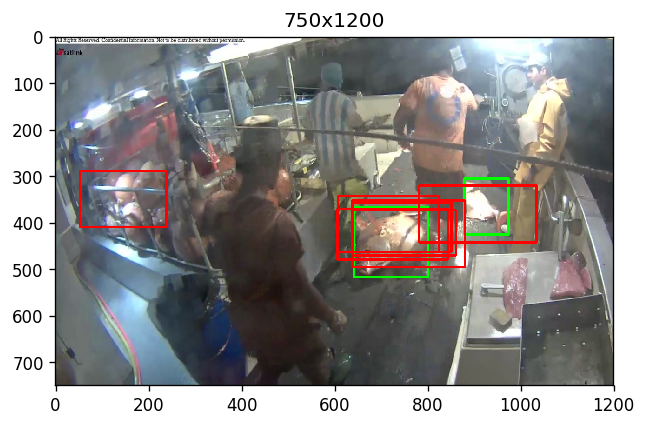

In [16]:
np.set_printoptions(threshold=20)
example = boxes['lag'][20]

_, sample_img = load_img(example['filename'])
pred = model.predict(np.array([sample_img,]))[0]
#print(pred)
#print(type(pred))

decoded = decode_prediction(pred, conf_thr=0.)
decoded = sorted(decoded, key=lambda e: -e['conf'])

plt.figure(figsize=(6, 6), dpi=120)
img = draw_boxes(example, decoded[:7], (IMG_WIDTH, IMG_HEIGHT))
plt.imshow(img)
plt.title('{}x{}'.format(*img.shape));

## Агрегация результатов

In [53]:
TEST_PREFIX1 = '../input/the-nature-conservancy-fisheries-monitoring/test_stg1'
TEST_PREFIX2 = '../input/test-stg2/test_stg2/test_stg2'
import zipfile
#with zipfile.ZipFile(TEST_PREFIX,"r") as z:
#    z.extractall(".")

def load_test_images(TEST_PREFIX):
    images = []
    for path in glob(os.path.join(TEST_PREFIX, '*.jpg')):
        images.append(path)
    return images

test_images1 = load_test_images(TEST_PREFIX1)
test_images2 = load_test_images(TEST_PREFIX2)
test_images =  test_images1 + test_images2

lines = [['image', 'ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']]
#lines = ['image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT']
for filename in test_images:
    _, sample_img = load_img(filename)
    pred = model.predict(np.array([sample_img,]))[0]
    #print(pred)
    #print(type(pred))

    decoded = decode_prediction(pred, conf_thr=0.)
    decoded = sorted(decoded, key=lambda e: -e['conf'])
    L = len(decoded)
    alb = sum([x['alb'] for x in decoded]) / L
    bet = sum([x['bet'] for x in decoded]) / L
    dol = sum([x['dol'] for x in decoded]) / L
    lag = sum([x['lag'] for x in decoded]) / L
    shark = sum([x['shark'] for x in decoded]) / L
    yft = sum([x['yft'] for x in decoded]) / L
    conf = sum([x['conf'] for x in decoded]) / L
    
    s = alb + bet + dol + lag + shark + yft + conf
    alb, bet, dol, lag, shark, yft = alb/s, bet/s, dol/s, lag/s, shark/s, yft/s
    other = 1 - (alb + bet + dol + lag + shark + yft)
    
    v = [filename.split('/')[-1], alb, bet, dol, lag, 1-conf, other, shark, yft]
    lines.append(v)
    print(v)
    
    print(len(decoded))


import csv
from IPython.display import HTML
with open('submission.csv', 'w') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(lines)
    print('len(lines) = ', len(lines))

def create_download_link(title = "Download CSV file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

create_download_link(filename='submission.csv')

# TODO: предскажите класс рыбы для фотографии из тестовой выборки
#
# Подготовьте файл с предсказаниями вероятностей для каждой фотографии:
# image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
# img_00001.jpg,1,0,0,0,0,...,0
# img_00002.jpg,0.3,0.1,0.6,0,...,0

['img_01717.jpg', 0.19633632433782683, 0.1567008454079521, 0.13981259650916358, 0.1621946890964175, 0.7858206871741313, 0.06414739269033043, 0.12860334336060242, 0.1522048085977073]
851
['img_02216.jpg', 0.23145538954907593, 0.15740215770883953, 0.13278684408862934, 0.14929431657495307, 0.7671634636978035, 0.07081258976361171, 0.12453201233606404, 0.13371668997882646]
851
['img_04562.jpg', 0.19668056056166133, 0.15392168985295177, 0.1398192325027528, 0.16369622343979362, 0.7747333239654101, 0.06635701762512403, 0.12413754860013618, 0.1553877274175803]
851
['img_00764.jpg', 0.12725865167084507, 0.16407940386038805, 0.15629487725754515, 0.1860837864984841, 0.860385487603498, 0.04160249332733834, 0.139392982914323, 0.1852878044710763]
851
['img_06368.jpg', 0.2255529486641091, 0.15720205922321445, 0.13581805840382158, 0.14737210758302588, 0.7740304992865505, 0.06880414067735818, 0.13166148400633298, 0.13358920144213796]
851
['img_03238.jpg', 0.18710340027107505, 0.15720819580002696, 0.1459

['img_01669.jpg', 0.1951388907226614, 0.151935799588624, 0.14174705340727053, 0.1644885810028521, 0.777185952080475, 0.06500734444462497, 0.12693705358881024, 0.15474527724515677]
851
['img_01286.jpg', 0.1674067550166092, 0.1494352652767242, 0.1468161799025825, 0.1780621367059379, 0.7866560997966495, 0.060718232010417816, 0.12409423535840895, 0.1734671957293194]
851
['img_05292.jpg', 0.20915647098332443, 0.1568434468345005, 0.14152655888288015, 0.14260822863640418, 0.7779636719601762, 0.06769532037595727, 0.14545308601886664, 0.13671688826806683]
851
['img_04830.jpg', 0.17153210270920083, 0.16025111378006257, 0.14620663084637964, 0.17118586959172707, 0.8215494647402986, 0.053876003629182434, 0.13297060761493987, 0.16397767182850767]
851
['img_01966.jpg', 0.22013756847500598, 0.15589989561719186, 0.1366686250344962, 0.15137093523575162, 0.7715044970359675, 0.06907860837816915, 0.13055759414179582, 0.1362867731175894]
851
['img_05967.jpg', 0.2173974847270805, 0.1558390043104593, 0.137806

['img_07192.jpg', 0.23474950106260087, 0.167250657676098, 0.13291204010865362, 0.13030857531564805, 0.7865428200706108, 0.06875314572877445, 0.1462398212868144, 0.11978625882141072]
851
['img_02648.jpg', 0.22019371092321352, 0.16210216466586905, 0.13708725124991994, 0.1403207412706806, 0.7814120344041392, 0.06859200441440327, 0.1414954379978871, 0.13020868947802638]
851
['img_02703.jpg', 0.16182379740730896, 0.1585077986141823, 0.14726187097228777, 0.1773594111280428, 0.817467645335662, 0.05374897654730093, 0.12885751373056112, 0.17244063160031622]
851
['img_05794.jpg', 0.18610833131013865, 0.15155998899817832, 0.14332862081768877, 0.1684823857962261, 0.7818638369604404, 0.06327628521092865, 0.12658625001552812, 0.16065813785131133]
851
['img_05766.jpg', 0.22232313163569295, 0.1555460453870967, 0.13617670721738126, 0.15112255578672665, 0.7679973353996915, 0.06995915678432996, 0.1290563019870734, 0.13581610120169907]
851
['img_00974.jpg', 0.1994779778628575, 0.15210718352170313, 0.14065

['img_01681.jpg', 0.21016287215541057, 0.1567598339411442, 0.13703233427298758, 0.15667129371639604, 0.7734559436084241, 0.0680224421762331, 0.12551093244376146, 0.14584029129406703]
851
['img_05568.jpg', 0.21417160557844114, 0.15712734350979737, 0.13645009476651196, 0.15622700683315485, 0.772726220529803, 0.06820295571116053, 0.12411566751410033, 0.14370532608683384]
851
['img_06946.jpg', 0.20855971840528564, 0.1569868115573765, 0.1414976866317098, 0.14420913371542202, 0.7797029913892156, 0.06707961059654899, 0.14386768430061084, 0.13779935479304634]
851
['img_03471.jpg', 0.20999704553423215, 0.15484714755215692, 0.13969104048180134, 0.15422180286278195, 0.7785181685305993, 0.06639543883915755, 0.1333321497988393, 0.14151537493103072]
851
['img_02749.jpg', 0.22800151387714607, 0.15809127420967692, 0.13536272818513995, 0.1453403919753686, 0.772652413488637, 0.06975561348999082, 0.13334534232289652, 0.13010313593978112]
851
['img_05979.jpg', 0.2546971088358057, 0.16708955463533945, 0.12

['img_07137.jpg', 0.1775417179641728, 0.15695636989339712, 0.14589964678139306, 0.16580713838693192, 0.8070041502473256, 0.05811024014646504, 0.1343822858836009, 0.1613026009440391]
851
['img_01618.jpg', 0.18406209553369818, 0.15093805654704998, 0.14354099596043768, 0.1702471265619541, 0.7811796839271036, 0.06319288940125078, 0.1251449018532783, 0.16287393414233092]
851
['img_06646.jpg', 0.21154722282159974, 0.1659908876508123, 0.1386213300718808, 0.14025467915422316, 0.797858734603345, 0.064363579941636, 0.1466146449741779, 0.13260765538567004]
851
['img_01647.jpg', 0.23483341792273899, 0.1593349552815222, 0.1323289730381465, 0.14471029708505345, 0.7715751729391123, 0.07056547019844217, 0.12897931102925772, 0.12924757544483897]
851
['img_05682.jpg', 0.17446971210959808, 0.1614925070231078, 0.14854458304775242, 0.15652435235503184, 0.8181512767469692, 0.05574909379583859, 0.14932127576975113, 0.15389847589892022]
851
['img_07050.jpg', 0.2115971514076031, 0.1542658634136174, 0.138504449

['img_05322.jpg', 0.1458838718227945, 0.1531780882363902, 0.15016096774561064, 0.18757115598895702, 0.8092845250778197, 0.054410914338200556, 0.12243688531459462, 0.18635811655345252]
851
['img_00518.jpg', 0.16593058057381907, 0.15996124760652175, 0.14778700640727288, 0.17282921293064885, 0.8267924365325781, 0.052170983650038916, 0.13472609479339057, 0.16659487403830797]
851
['img_05539.jpg', 0.23184219618041002, 0.1586978065829967, 0.13453730135577802, 0.1426703695551015, 0.769620596994451, 0.07095274883190672, 0.1337756599214642, 0.1275239175723428]
851
['img_07318.jpg', 0.20112060258932732, 0.15866665302157293, 0.13948802917148867, 0.1550369993156462, 0.7819316088066367, 0.06611534911974137, 0.13246412294956408, 0.14710824383265939]
851
['img_04432.jpg', 0.18519530748468205, 0.1586057372699978, 0.142283839885451, 0.16398589214222314, 0.7985611589527761, 0.06095321870781256, 0.13261002085245993, 0.1563659836573734]
851
['img_05489.jpg', 0.2178640686626123, 0.15609475109870494, 0.1374

['img_02309.jpg', 0.17610466480239165, 0.15771777626431846, 0.1449322212422304, 0.16887729450093955, 0.8064539997069782, 0.05784955765354005, 0.1322592037977956, 0.1622592817387842]
851
['img_07062.jpg', 0.21035445646290743, 0.1562894635399629, 0.13960636936771967, 0.15033418084819106, 0.7763490517485544, 0.06746232785814366, 0.13531792981346313, 0.14063527210961219]
851
['img_07818.jpg', 0.18102794503368053, 0.15901064445352425, 0.14336031893024345, 0.16561626245999356, 0.8042531372700255, 0.059244856023483394, 0.13355641549395605, 0.1581835576051187]
851
['img_03554.jpg', 0.18515569834870668, 0.15871475984224687, 0.14233174244607613, 0.16433774999132048, 0.799633661627136, 0.06055267914059659, 0.1322580442880682, 0.15664932594298508]
851
['img_05775.jpg', 0.19560201100823701, 0.1519166842700632, 0.1416347925917259, 0.1636465785153272, 0.7768572937140209, 0.06530965743403183, 0.12752894872931925, 0.1543613274512957]
851
['img_07146.jpg', 0.1782273437724144, 0.15593716338480015, 0.1441

['img_07528.jpg', 0.14503496587181178, 0.1579365722986468, 0.1509588347010165, 0.18520243459367014, 0.8302254990925131, 0.049605286509501356, 0.12866903089995074, 0.18259287512540268]
851
['img_03074.jpg', 0.2002050170816931, 0.1529204559431958, 0.14045289499001556, 0.1616721637648852, 0.7765000870100269, 0.06587886685953492, 0.12793826799745292, 0.15093233336322248]
851
['img_02406.jpg', 0.23483327699926146, 0.15919380028944577, 0.13414581544827828, 0.14065029154122125, 0.7691564014668569, 0.07143334554509029, 0.13482319057896353, 0.1249202795977394]
851
['img_07120.jpg', 0.15294405967383076, 0.1602216296086112, 0.14888962757561222, 0.1802835666727214, 0.827231955454747, 0.051022801508060156, 0.13042509138314495, 0.1762132235780194]
851
['img_07371.jpg', 0.20277442749960367, 0.16028215047028682, 0.13998521109427847, 0.15096566608364775, 0.7864016560279041, 0.06583200596056749, 0.13785637734515868, 0.14230416154645711]
851
['img_06273.jpg', 0.21449869010601835, 0.15460979034860764, 0.1

['img_01984.jpg', 0.20711086987314184, 0.15336387993720305, 0.14000141765131727, 0.15792259020702595, 0.7758799684189173, 0.06653769284593347, 0.1299338332074554, 0.14512971627792307]
851
['img_07122.jpg', 0.18884929447221493, 0.15107036334757729, 0.14241013840480612, 0.1684707087082797, 0.7775318388216931, 0.0643679352468377, 0.12458906444409944, 0.16024249537618476]
851
['img_00858.jpg', 0.12685050097296477, 0.15438875818553682, 0.15572309258099074, 0.19287248641314816, 0.8329908265706399, 0.047796620629328324, 0.12891390405704142, 0.19345463716098987]
851
['img_06285.jpg', 0.1911632812085205, 0.1572398830240364, 0.1408172755986486, 0.1656152093552197, 0.7909180896742002, 0.06201959235256871, 0.12604916284340922, 0.1570955956175969]
851
['img_04750.jpg', 0.20697695773569993, 0.16135951182051206, 0.1394109036384219, 0.14686048404064733, 0.7918085813093106, 0.06470756417821788, 0.1413747106875994, 0.13930986789890143]
851
['img_03283.jpg', 0.19907163209439263, 0.15290170130922032, 0.14

['img_05471.jpg', 0.19990323668117832, 0.15738058582505263, 0.14321109619141084, 0.1479212141745687, 0.787392578253663, 0.06472822339991846, 0.1448370975950077, 0.14201854613286335]
851
['img_00285.jpg', 0.1973514471908931, 0.15988390893755997, 0.14352123238885747, 0.147371467333752, 0.7962021875215972, 0.06257163706280289, 0.14715946705842, 0.1421408400277147]
851
['img_05721.jpg', 0.22066181559689335, 0.1638875307419642, 0.13648967221973685, 0.13956151252492288, 0.7858748535132134, 0.06766067991725366, 0.14230293318250775, 0.12943585581672135]
851
['img_01204.jpg', 0.13112081565699596, 0.15902302478016506, 0.1554727675006221, 0.18626476603085115, 0.8453711068719759, 0.045596823061777036, 0.13625037337465767, 0.18627142959493093]
851
['img_00289.jpg', 0.20603626564743574, 0.15588921477393727, 0.1389376281348179, 0.1576060840647233, 0.7858595926981486, 0.06474884440567041, 0.12995159418033245, 0.146830368793083]
851
['img_03670.jpg', 0.1682523696903119, 0.1596138761529383, 0.1469077493

['img_04425.jpg', 0.2124146748790664, 0.15463183295127816, 0.1386438140523616, 0.15485124541822742, 0.7739048812414174, 0.06768784707228526, 0.13060749717346481, 0.14116308845331632]
851
['img_00152.jpg', 0.14023246259313624, 0.15663998376510155, 0.15442768845402155, 0.18215230843403146, 0.8304067937870859, 0.0497452352946981, 0.13606520960559154, 0.1807371118534196]
851
['img_00950.jpg', 0.2439768883341465, 0.16307372295827502, 0.13106615776647662, 0.13227505149801952, 0.7737220649120411, 0.07170850530250128, 0.1391175643515329, 0.11878210978904807]
851
['img_05393.jpg', 0.16086327312556886, 0.16274533023311008, 0.15055709725109717, 0.16687295726277332, 0.8359822271932885, 0.05045447928980629, 0.14653219705270998, 0.16197466578493433]
851
['img_02602.jpg', 0.18294281823769892, 0.15132155794729343, 0.14400364678032174, 0.17037559792395898, 0.7843501028505742, 0.062493008078699286, 0.12606875445396398, 0.1627946165780637]
851
['img_02687.jpg', 0.19874765851238133, 0.157565803721417, 0.1

['img_07436.jpg', 0.21182387549474624, 0.15802057854441354, 0.14142042188826748, 0.1405166708047109, 0.7793543166572475, 0.06774576324894899, 0.1465019270820342, 0.1339707629368788]
851
['img_00876.jpg', 0.1701424912015433, 0.15831142666402637, 0.14711928117162665, 0.16898102176790716, 0.8132346397397863, 0.05592895434421297, 0.1353192684595084, 0.16419755639117511]
851
['img_07157.jpg', 0.23484717423167112, 0.15872407959139645, 0.13383469657102584, 0.14115243450310724, 0.769679608649863, 0.07108472249103648, 0.13485384882529508, 0.12550304378646787]
851
['img_04118.jpg', 0.20822234970947265, 0.155602505054882, 0.13954176656864278, 0.15577784209134668, 0.7807297950153007, 0.06566570607977207, 0.13168489667396405, 0.14350493382191962]
851
['img_05719.jpg', 0.2027398714816621, 0.1670815419438801, 0.13962433573031877, 0.14601598044878128, 0.8078224848550586, 0.06089992737510386, 0.1457947631537107, 0.13784357986654316]
851
['img_02920.jpg', 0.20218208871260002, 0.15300211576478867, 0.1402

['img_05572.jpg', 0.21531576114903933, 0.16069312120326706, 0.1395352465703939, 0.13816896272492876, 0.7839374032192041, 0.06725347570636953, 0.14819974504202657, 0.13083368760397487]
851
['img_03261.jpg', 0.230416987261688, 0.15963421513829557, 0.13501512460984816, 0.14202234843793338, 0.7734512675000342, 0.07022883783716138, 0.1357537684740323, 0.12692871824104124]
851
['img_02638.jpg', 0.2153784464354988, 0.15516473821450968, 0.1381163171776034, 0.1524484319993883, 0.7731218612671003, 0.0682568394783919, 0.13139106512572898, 0.13924416156887895]
851
['img_00171.jpg', 0.2312362890786491, 0.15836981866526553, 0.13459615426965083, 0.14373006215201542, 0.7697315901261572, 0.07075707115426655, 0.13286091786572704, 0.1284496868144255]
851
['img_03750.jpg', 0.20041237247290164, 0.1570143462210507, 0.14327090444314278, 0.1469704767042702, 0.7853106876013214, 0.0652697161478275, 0.14531044236289928, 0.1417517416479078]
851
['img_02904.jpg', 0.20830673858308235, 0.15714269767608394, 0.1397560

['img_05718.jpg', 0.18236313130506823, 0.15795282247640238, 0.14614596599553217, 0.16034912084278025, 0.8043988246842088, 0.058754073508488935, 0.1402973705933145, 0.15413751527841346]
851
['img_03891.jpg', 0.22422044244355205, 0.15713857105072587, 0.13603518983900725, 0.14802086389495508, 0.7711822817384912, 0.06969740161854088, 0.13199686825396853, 0.1328906628992503]
851
['img_02789.jpg', 0.16560525966046213, 0.15516887999863524, 0.14631525032503315, 0.1785655221408501, 0.8069467699052202, 0.05634970049261934, 0.125045358094818, 0.1729500292875821]
851
['img_00103.jpg', 0.20204848690686372, 0.15400743485334276, 0.1405202499755788, 0.15924996146110074, 0.7804843481140774, 0.06518612598206786, 0.13056391380559162, 0.14842382701545448]
851
['img_06921.jpg', 0.1956774716516158, 0.15389172812080704, 0.14083313935920982, 0.16394264957020796, 0.7880735125905864, 0.06310189603935679, 0.12767274259021827, 0.1548803726685844]
851
['img_07188.jpg', 0.23597853472469327, 0.16128432969105458, 0.1

['img_02077.jpg', 0.23427873964920826, 0.15900442872275092, 0.1340255868243169, 0.14153827268691893, 0.7685115735265658, 0.07149624331755544, 0.13395378222366622, 0.12570294657558317]
851
['img_01530.jpg', 0.2734725213212979, 0.17256082662060712, 0.12456297951606075, 0.10672038969354312, 0.7729888779812111, 0.07680726410188798, 0.15318546581620512, 0.09269055293039806]
851
['img_02563.jpg', 0.22259602855009833, 0.15767582182633783, 0.13656639810707014, 0.14835356377050007, 0.7765788060774517, 0.06818256828535718, 0.13240678302061373, 0.1342188364400228]
851
['img_04795.jpg', 0.20733096001262355, 0.1580565622168882, 0.1422360040510128, 0.14289620843576298, 0.7826866961917096, 0.06660263484124174, 0.14650236686246706, 0.13637526358000363]
851
['img_02641.jpg', 0.2173107909412075, 0.15590980134849414, 0.13725057727290438, 0.1516154685497766, 0.7728658110348345, 0.06846884958445276, 0.1309537028606098, 0.13849080944255487]
851
['img_03252.jpg', 0.23800703356560213, 0.1644787459683686, 0.13

['img_00724.jpg', 0.18055758178465, 0.15710186773941273, 0.14397463425254486, 0.1686099190745594, 0.8025818558734994, 0.05896743864195708, 0.13009434190635866, 0.1606942166005173]
851
['img_07149.jpg', 0.14973836046386896, 0.15308309673756496, 0.14932511047270458, 0.18599018595052036, 0.8065485928923073, 0.055323827150333016, 0.12240144254503145, 0.18413797667997656]
851
['img_05463.jpg', 0.20892245022009906, 0.1568544737390821, 0.14163000078543797, 0.14268881514955456, 0.7788646556068407, 0.0674538016721955, 0.14560299482001132, 0.13684746361361944]
851
['img_06424.jpg', 0.1685630344580095, 0.1596533655217243, 0.1468773355262154, 0.17256282318522556, 0.8211943403969295, 0.05362694649571187, 0.13252395336128192, 0.16619254145183138]
851
['img_00865.jpg', 0.20218274623960164, 0.15358949863172167, 0.14035794771740587, 0.16054004585224468, 0.7783628104842192, 0.06548362572765076, 0.1287220175743769, 0.14912411825699848]
851
['img_03805.jpg', 0.20235871488544813, 0.15233577922032707, 0.140

['img_04004.jpg', 0.22604857627997937, 0.1586660910986282, 0.13590595589027726, 0.14415032353564952, 0.7745884855622273, 0.06930046293143088, 0.13549196053744678, 0.130436629726588]
851
['img_05580.jpg', 0.21671260374352405, 0.15973556355077032, 0.1388109816569254, 0.13791831601968785, 0.7799167735217152, 0.068257972176054, 0.14724286896112518, 0.13132169389191328]
851
['img_00533.jpg', 0.18054107980020492, 0.1579612626088046, 0.14741023750240395, 0.15737714499032032, 0.8032109081883937, 0.05933337802686256, 0.14403763391822408, 0.1533392631531795]
851
['img_05378.jpg', 0.22108770993273114, 0.15952168451558735, 0.13454243461223975, 0.14732674868825887, 0.7745515507189251, 0.06902123289106199, 0.1313443730568208, 0.13715581630330004]
851
['img_05817.jpg', 0.20223592980032756, 0.15732427411224922, 0.14275510891608226, 0.1468498248169876, 0.7854741598660279, 0.06537349027639205, 0.14472472389520685, 0.14073664818275441]
851
['img_01782.jpg', 0.2098041064780461, 0.15473063648071214, 0.1369

['img_00550.jpg', 0.22524575779058204, 0.15699967699129455, 0.13599053015207033, 0.14786066040767393, 0.7743607206263974, 0.06858581866953162, 0.13134810282859483, 0.1339694531602529]
851
['img_05268.jpg', 0.20246712879868484, 0.15599553394583077, 0.14267129056432767, 0.14805618080054025, 0.7814595870219359, 0.06619720562513054, 0.14323187223975684, 0.14138078802572904]
851
['img_02834.jpg', 0.21369054789202685, 0.15956425669995652, 0.14003400163685614, 0.13954240179822772, 0.7820400140979186, 0.06742224677548259, 0.14722848375475672, 0.13251806144269349]
851
['img_06099.jpg', 0.2362026439509702, 0.16719740537202182, 0.13318835262050718, 0.12671527784295153, 0.7847314178727737, 0.06997200740858822, 0.15012484417326274, 0.11659946863169819]
851
['img_06564.jpg', 0.2140338016056069, 0.15479055857239482, 0.1377851658551331, 0.15485070580934554, 0.7729253284000617, 0.06769793641211375, 0.12861418068254377, 0.1422276510628622]
851
['img_00180.jpg', 0.1449315718830308, 0.16043560739641394, 0

['img_05740.jpg', 0.2071832016451506, 0.1566000237343647, 0.1391165713006235, 0.15406282847562694, 0.780536023923943, 0.06628775595712333, 0.132354499915082, 0.14439511897202897]
851
['img_06985.jpg', 0.21725889723136, 0.15717473358970843, 0.1379933155919502, 0.1490157016625288, 0.7773557876364703, 0.06779111496268964, 0.13456225417148326, 0.1362039827902798]
851
['img_05672.jpg', 0.1924344981115655, 0.1541066476864193, 0.14393585800200775, 0.1574775500469772, 0.7836592930604723, 0.06432321718033729, 0.13711117758994695, 0.15061105138274597]
851
['img_06959.jpg', 0.16373398650652526, 0.14938384018381504, 0.14740602885317375, 0.1808592425248017, 0.7915943823426993, 0.05907183720789644, 0.12311440586074067, 0.17643065886304726]
851
['img_03444.jpg', 0.18996833845479924, 0.15946251538715037, 0.14219624222480826, 0.16224394423410968, 0.8006549190859786, 0.06063783293824243, 0.13280593607898902, 0.15268519068190106]
851
['img_00618.jpg', 0.20988051209746436, 0.15599255183256736, 0.137873399

['img_02702.jpg', 0.2278714314664299, 0.16317570075229712, 0.13371259876856836, 0.13670719254052704, 0.7813430956329684, 0.06921284205783107, 0.14087456087992775, 0.12844567353441888]
851
['img_07628.jpg', 0.20381404520463167, 0.16128743986317304, 0.13952668512672048, 0.15318907594014805, 0.7938937737598858, 0.06329903949083526, 0.13400911800658655, 0.1448745963679049]
851
['img_04061.jpg', 0.19579123071570673, 0.15573216338171178, 0.1433917193143599, 0.1522433790615559, 0.7822562709189962, 0.06537141274881042, 0.14047910039606967, 0.14699099438178553]
851
['img_07173.jpg', 0.2138784750998341, 0.15715148439564527, 0.13605957581473208, 0.15395041187546746, 0.7742243812242812, 0.06814416457029804, 0.12773374981906083, 0.14308213842496229]
851
['img_05879.jpg', 0.19221584143720666, 0.15125584592295416, 0.14205556427455898, 0.1664647157582021, 0.7782577567334479, 0.06445587731330771, 0.12602243131549715, 0.15752972397827325]
851
['img_03116.jpg', 0.18128441634844342, 0.16195031917488367, 0

['img_05587.jpg', 0.21453856888393186, 0.15466155214377836, 0.1377291364719973, 0.15518958736680116, 0.7724161849475503, 0.06783464027453823, 0.12807172301699624, 0.14197479184195685]
851
['img_07147.jpg', 0.2116851815494881, 0.15806993184924822, 0.13780798862792837, 0.15250211873960062, 0.7825521137402689, 0.06598678984557815, 0.13121971330190677, 0.14272827608624983]
851
['img_02811.jpg', 0.23168923004390235, 0.15808200748437234, 0.1344695721787648, 0.1440001423464939, 0.7690493275734338, 0.07090752277902201, 0.13248416067742722, 0.1283673644900175]
851
['img_01685.jpg', 0.22669579103719542, 0.15706581032071135, 0.13548774854059448, 0.14769354148630717, 0.7740350224409418, 0.06878889446210867, 0.1310575129773918, 0.13321070117569112]
851
['img_06851.jpg', 0.2120869154848407, 0.15836720708646848, 0.14144630200299363, 0.14002837812152055, 0.7802897915349833, 0.06761803968605906, 0.14724244797810568, 0.13321070964001183]
851
['img_06630.jpg', 0.2147291139057069, 0.160017977449556, 0.139

['img_04657.jpg', 0.2272032920319925, 0.15802183408899304, 0.13579547269424252, 0.1450523017867897, 0.7727048343252437, 0.06985862137264087, 0.1340065730787761, 0.13006190494656528]
851
['img_05896.jpg', 0.21324198606203743, 0.15456919454265683, 0.13804392802964008, 0.15519078899002994, 0.7731955996478908, 0.06757190307295835, 0.12870228061922717, 0.1426799186834502]
851
['img_00564.jpg', 0.2084159860925522, 0.15404437553816935, 0.13916861007317566, 0.1580312269206212, 0.7774286465585872, 0.06613126019595705, 0.12838540486004787, 0.14582313631947655]
851
['img_01561.jpg', 0.24380042443549352, 0.1609345312638598, 0.13243181436464913, 0.13654118482913324, 0.774013875125657, 0.07094834721314991, 0.13650408420851198, 0.11883961368520243]
851
['img_04520.jpg', 0.1902013458465014, 0.1564422909425143, 0.1413009990578113, 0.1671199485473174, 0.793725514932387, 0.06138898428137329, 0.12584793704351213, 0.1576984942809702]
851
['img_05445.jpg', 0.2336109162884196, 0.15849464546765074, 0.13414527

['img_06783.jpg', 0.19453198352432108, 0.15643401119395106, 0.14419196810903717, 0.1514959282447708, 0.7880272665662207, 0.06385600654410073, 0.14282837223362538, 0.14666173015019376]
851
['img_05492.jpg', 0.2072667247030157, 0.1692787342861345, 0.13905649039094858, 0.14195526190174299, 0.8109436736079907, 0.06072992901582963, 0.14883444499489704, 0.13287841470743153]
851
['img_05293.jpg', 0.18575921940928092, 0.15767908868995956, 0.14536876902053814, 0.15901979601667163, 0.8013223768107574, 0.0597428552950966, 0.14021399499796353, 0.15221627657048967]
851
['img_04879.jpg', 0.20561674576329936, 0.15525253661991736, 0.14125162727922214, 0.1501445349894817, 0.7787141135549531, 0.06672113331546359, 0.13943136475076065, 0.1415820572818553]
851
['img_07304.jpg', 0.23166201584220408, 0.15957188533924888, 0.134997451651242, 0.14025513313895666, 0.7721917842627697, 0.07068873956218957, 0.13711787026634542, 0.12570690419981329]
851
['img_06637.jpg', 0.24126093064435372, 0.16089337578073465, 0.1

['image_08058.jpg', 0.21449701295679632, 0.15964745385132964, 0.13605402911151623, 0.1508413559649067, 0.777565882725051, 0.06826597445489047, 0.13171189575090086, 0.13898227790965975]
851
['image_10727.jpg', 0.1892507908615061, 0.1584927980730933, 0.14253158343710925, 0.16093112993703668, 0.7907749932470657, 0.06291701692645513, 0.1320381967594874, 0.1538384840053122]
851
['image_01117.jpg', 0.15781521871090398, 0.15702878484179764, 0.1488636167068181, 0.17510069162714773, 0.8120808738661379, 0.055445297647352176, 0.13170825166838118, 0.17403813879759925]
851
['image_08883.jpg', 0.20067120014379491, 0.15656291117397247, 0.13931857124129982, 0.15689826256850278, 0.7765474857097805, 0.0668225664274219, 0.12934430160537796, 0.15038218683963012]
851
['image_08603.jpg', 0.25613474191621866, 0.16415886873700117, 0.1276814339175343, 0.13224807639837466, 0.7679836672876252, 0.07385296713614464, 0.1319398138533851, 0.11398409804134146]
851
['image_10615.jpg', 0.23051640491131198, 0.15968137651

['image_12041.jpg', 0.23693253451714313, 0.15946394693253413, 0.1313893460537614, 0.14551775294697067, 0.7660290494539411, 0.07185023604398211, 0.12491088189436264, 0.12993530161124603]
851
['image_03332.jpg', 0.18419137624297033, 0.15871682694384787, 0.14346490706827117, 0.16257636345757484, 0.794384121718287, 0.06170377776344327, 0.13229358068920938, 0.15705316783468315]
851
['image_01554.jpg', 0.22872617729740816, 0.15896744991964107, 0.13275541236984287, 0.14901023298158153, 0.7661904164319289, 0.07113367217030042, 0.12385755456411783, 0.135549500697108]
851
['image_03746.jpg', 0.1772256374764547, 0.15453282288575304, 0.14370257900104688, 0.17321892459474203, 0.7906289017320013, 0.06128159109059861, 0.12309716953904001, 0.16694127541236475]
851
['image_03279.jpg', 0.20639115036743585, 0.16739958714351857, 0.1379643361033108, 0.1457496108591762, 0.8001055985564696, 0.0632517293532825, 0.14218032087954446, 0.1370632652937317]
851
['image_00342.jpg', 0.20898387530326668, 0.15614837603

['image_07095.jpg', 0.19939072380153341, 0.153550249651857, 0.1384948110848313, 0.16496486433521335, 0.7721107364573799, 0.06696371819064728, 0.1217727905352074, 0.1548628424007103]
851
['image_09916.jpg', 0.19366584771186657, 0.15545333146918966, 0.1405158018560171, 0.16132425219874258, 0.7768199998497067, 0.06606416275477112, 0.1273107545817161, 0.15566584942769698]
851
['image_11545.jpg', 0.23557056695969, 0.1597377782760299, 0.13140293641927805, 0.14544631667119254, 0.7650097040367164, 0.0721438652592935, 0.1252750344288493, 0.13042350198566663]
851
['image_06046.jpg', 0.12847426131509007, 0.15195097966824456, 0.1538672953925909, 0.1970208005464775, 0.8214331669497152, 0.05039268480715631, 0.1208658962475458, 0.1974280820228948]
851
['image_11782.jpg', 0.16584809733766873, 0.1534982172215733, 0.14588145868193994, 0.1755925442922792, 0.789131427065409, 0.060981101908009094, 0.1245189050887985, 0.1736796754697313]
851
['image_03023.jpg', 0.20459512735898164, 0.155628538817565, 0.1370

['image_03801.jpg', 0.1560721253083563, 0.15771765418613307, 0.1491638884535478, 0.17576933127289684, 0.816506387602108, 0.054279465882625555, 0.13195808358550162, 0.1750394513109388]
851
['image_01497.jpg', 0.26629540005033264, 0.1667815508455235, 0.12550052906114173, 0.12575944841549552, 0.7615156382955276, 0.0768672083505505, 0.13198436174935446, 0.10681150152760167]
851
['image_00082.jpg', 0.17223693940010254, 0.1584442809926988, 0.145361017443238, 0.1680676125356984, 0.8036537243565789, 0.058648784593188785, 0.13209371496878378, 0.16514765006628973]
851
['image_10013.jpg', 0.24567948689793542, 0.16272651462679302, 0.12964449713664772, 0.13708055638954736, 0.7632104889786311, 0.07401969021223542, 0.12892882585011492, 0.12192042888672613]
851
['image_05558.jpg', 0.2077730071252165, 0.15603623618648602, 0.13721928951245638, 0.16103286264440436, 0.7715669846996837, 0.06792266100354205, 0.12066459393598922, 0.14935134959190552]
851
['image_08834.jpg', 0.18226695077263008, 0.15269207272

['image_10643.jpg', 0.10557306105877226, 0.15341411612495395, 0.16026889344099526, 0.20396348615324883, 0.8485326056028913, 0.04296760866578264, 0.12760012012595204, 0.20621271443029493]
851
['image_09007.jpg', 0.15085999099292047, 0.1654722452980769, 0.15034403874356694, 0.17305068664046327, 0.8448077491291387, 0.04715690301472364, 0.14211059299291137, 0.17100554231733728]
851
['image_02885.jpg', 0.241441527832917, 0.1605734430270532, 0.13045711949947217, 0.14214109731557206, 0.7684526241495673, 0.07192847834584915, 0.12767878305705382, 0.12577955092208265]
851
['image_11205.jpg', 0.16158928770582764, 0.15804040468207234, 0.14787551173050556, 0.1736900364571373, 0.8122769206570357, 0.055711116235316105, 0.1314248735010332, 0.17166876968810785]
851
['image_03147.jpg', 0.26558935959211144, 0.16607917640859926, 0.12502237675291322, 0.12754676017735606, 0.7621904568433603, 0.07670859352012638, 0.13083366979459476, 0.10822006375429886]
851
['image_07799.jpg', 0.1582850411674817, 0.15785917

['image_00725.jpg', 0.1553065285184266, 0.1569329179800175, 0.14901818360517832, 0.17713195791412845, 0.8133470347394853, 0.05491067638596303, 0.13040399589939008, 0.1762957396968961]
851
['image_08271.jpg', 0.18224472215886733, 0.15361945149267694, 0.14326362544650828, 0.167330634684883, 0.7763432979886613, 0.0653655829944243, 0.12599452006750916, 0.16218146315513093]
851
['image_07145.jpg', 0.17709305680533505, 0.16043077282182594, 0.14396468901442686, 0.1714928209469953, 0.809416967012147, 0.05693684744287686, 0.12659704582062464, 0.16348476714791543]
851
['image_11687.jpg', 0.2104991854509392, 0.157885381017103, 0.13712800976474504, 0.15263874502216437, 0.776861262177631, 0.06745864045264383, 0.1304016362038365, 0.14398840208856806]
851
['image_05137.jpg', 0.1587314610353342, 0.1551292841303763, 0.14776249533601687, 0.1770215127978461, 0.801075150640897, 0.057891864519536984, 0.12723397035878714, 0.1762294118221024]
851
['image_04477.jpg', 0.24846574254251, 0.16300890104988752, 0.1

['image_03125.jpg', 0.17574783866460575, 0.1587906313373689, 0.1447163615982124, 0.16771861071520977, 0.7989668170836528, 0.05995935939705921, 0.13005343102716765, 0.1630137672603763]
851
['image_09963.jpg', 0.17333618744582469, 0.15429953318673864, 0.14463626929233606, 0.17051620444097507, 0.7858002503620738, 0.06239863440548732, 0.1263362623676378, 0.16847690886100042]
851
['image_05561.jpg', 0.24795907850491222, 0.16330505023078984, 0.12850563019719527, 0.13721089758530666, 0.764265499172875, 0.07387583466005299, 0.12789979787288908, 0.12124371094885392]
851
['image_11136.jpg', 0.2204838650269881, 0.15772734860548213, 0.13415818852441724, 0.1530737140004967, 0.767878892371769, 0.069972188754307, 0.12311431390380698, 0.14147038118450186]
851
['image_02638.jpg', 0.20354273146175028, 0.15538588801577277, 0.13865687982835204, 0.15724151659739677, 0.7721200534317222, 0.06770966582918514, 0.12771981696447052, 0.14974350130307248]
851
['image_09269.jpg', 0.18652842660772764, 0.158376876549

['image_01734.jpg', 0.1905826141989872, 0.15878985252740377, 0.1419780875769266, 0.1606489730970474, 0.7889896335724527, 0.06355172157509714, 0.13105214081929986, 0.15339661020523812]
851
['image_09876.jpg', 0.1591531059920459, 0.15470120359377393, 0.14787959130545605, 0.1765942502660309, 0.7988854652215117, 0.05844609520782795, 0.12716838536608394, 0.1760573682687813]
851
['image_07674.jpg', 0.25854182054774977, 0.16501218438969958, 0.12721151860157118, 0.13062020966272037, 0.766821649175334, 0.07446655574847993, 0.13173102540005158, 0.11241668564972764]
851
['image_07714.jpg', 0.1847075869376351, 0.15508145445229687, 0.14263289164263854, 0.16500238976353437, 0.7832276304778978, 0.06393304670886302, 0.12784027489626335, 0.16080235559876882]
851
['image_09304.jpg', 0.20503859599512808, 0.15857154163883008, 0.13784332591989729, 0.16064826543186422, 0.7815122793920161, 0.06560637284858861, 0.12339114540371217, 0.14890075276197953]
851
['image_08811.jpg', 0.15942584361114617, 0.1581371806

['image_06274.jpg', 0.22634090479097219, 0.16485434550085096, 0.13378786360802114, 0.14160115751187738, 0.7817579043687036, 0.06865471355191233, 0.13575824168716652, 0.1290027733491995]
851
['image_04952.jpg', 0.1547918991956431, 0.15591825820691751, 0.1488210892006108, 0.1784815743701932, 0.8083823713342364, 0.05596936027027022, 0.12829171574188727, 0.17772610301447797]
851
['image_06987.jpg', 0.1997670963094882, 0.15806905510290226, 0.1404723452534612, 0.15474602653967506, 0.7778385735901588, 0.06701894827487043, 0.1327104607490285, 0.14721606777057433]
851
['image_00091.jpg', 0.2551744682171431, 0.16632832027995442, 0.127106655180801, 0.1267070508622347, 0.7636649339317629, 0.07622718866014666, 0.13694228945207784, 0.11151402734764221]
851
['image_11403.jpg', 0.16360434257383974, 0.15454191687522986, 0.1469767220951119, 0.174496098161503, 0.7956203887869718, 0.0594398667584215, 0.127460742346225, 0.17348031118966895]
851
['image_10321.jpg', 0.24230846462665748, 0.16298876973112839, 

['image_09037.jpg', 0.24400076382904373, 0.16180377524663472, 0.12952021908174124, 0.14061276780088505, 0.7652537472221493, 0.07298115622604329, 0.1264449201419787, 0.12463639767367314]
851
['image_00466.jpg', 0.2280546688956327, 0.165786838183374, 0.13349314313397873, 0.13994581397346562, 0.782449218062842, 0.06875928008823418, 0.1366606375024637, 0.1272996182228511]
851
['image_02226.jpg', 0.19529151623154495, 0.15593758655124926, 0.1401974095666148, 0.16001851758421756, 0.7769136085563162, 0.06627595733497571, 0.12802513871618354, 0.15425387401521426]
851
['image_11193.jpg', 0.16878864631162305, 0.15511757310556432, 0.14595967150230751, 0.17170300813761608, 0.7933981739730435, 0.06040896255650108, 0.12794418692957563, 0.17007795145681234]
851
['image_06287.jpg', 0.19979177300925402, 0.1568599332371765, 0.13892144155564518, 0.1634931592343197, 0.7779746746285218, 0.06605474973451175, 0.12173719437154311, 0.1531417488575498]
851
['image_08806.jpg', 0.21508215788800486, 0.1584765458685

['image_09993.jpg', 0.2017616728441188, 0.15557297771613454, 0.13839401740370752, 0.15919400080230733, 0.7719002142275808, 0.06755368829024577, 0.12522143587657228, 0.15230220706691375]
851
['image_04562.jpg', 0.17751052685449994, 0.1536581356307473, 0.14365942606829965, 0.16967897404425844, 0.7818222168917843, 0.06357702288514933, 0.12555320788485533, 0.16636270663218997]
851
['image_05108.jpg', 0.18731216385698604, 0.155324548929837, 0.14180467589301268, 0.16364288182068154, 0.7803777726143091, 0.06491830998013359, 0.1279824117153589, 0.15901500780399028]
851
['image_11641.jpg', 0.18711301229719085, 0.15839956896409796, 0.14233863590216592, 0.16208067470028026, 0.7875685590522816, 0.06366021944369915, 0.13046326636930966, 0.15594462232325623]
851
['image_03925.jpg', 0.1577603626100312, 0.15744385877755068, 0.1485890012432693, 0.17542361202246404, 0.8115654750065316, 0.05559332628209668, 0.1306195667191828, 0.17457027234540548]
851
['image_01807.jpg', 0.20607772103914265, 0.1596319629

['image_02663.jpg', 0.20321464570908426, 0.15737637242065947, 0.13831462217180673, 0.16073482714153076, 0.7757357005918438, 0.06703236058632889, 0.12310727382093889, 0.1502198981496511]
851
['image_09913.jpg', 0.21026292181084552, 0.1687328164893882, 0.13716737317381675, 0.14382916492193276, 0.801556879822374, 0.06316058740115627, 0.1423514852623136, 0.1344956509405469]
851
['image_07192.jpg', 0.1761206371596223, 0.15548125674015684, 0.14426580282410445, 0.1692026316598701, 0.7896363796029189, 0.0617582638952997, 0.12718935326160818, 0.16598205445933842]
851
['image_03031.jpg', 0.2124660140541549, 0.16358016866303896, 0.137698566677162, 0.14447229301154596, 0.7894407787809595, 0.06571142487957338, 0.1405961569614605, 0.1354753757530642]
851
['image_03659.jpg', 0.20200541863492635, 0.1562183951757181, 0.1387467035211777, 0.15816427636483982, 0.775401998968599, 0.06697872268588412, 0.12702984504608608, 0.15085663857136775]
851
['image_09373.jpg', 0.24822876349066073, 0.1622312871695321, 

['image_12023.jpg', 0.18096625346984008, 0.1597237952322222, 0.14450386536469237, 0.16333151482605912, 0.8000680394621632, 0.06021828287637265, 0.13363041097421452, 0.157625877256599]
851
['image_01782.jpg', 0.1671027031307907, 0.15143675729011083, 0.14454597535743266, 0.18079982925182297, 0.7844941008397093, 0.06129194524755277, 0.11752962695814165, 0.17729316276414842]
851
['image_00183.jpg', 0.15828261857629533, 0.15738260474619695, 0.14846265454707938, 0.17556977672363885, 0.8124923058082282, 0.05536575687656442, 0.13074060692948208, 0.17419598160074304]
851
['image_04768.jpg', 0.19305717671228975, 0.16131113509472422, 0.1407224537566651, 0.16355560181833476, 0.7983584258289391, 0.0610257927464648, 0.126869866575054, 0.15345797329646743]
851
['image_01367.jpg', 0.1996467358669786, 0.15685285860954296, 0.13860975872693473, 0.16401531634390737, 0.7787788474977452, 0.06561260002885516, 0.12137246139233836, 0.15389026903144284]
851
['image_09957.jpg', 0.12479782234918674, 0.16767196376

['image_00257.jpg', 0.16565452702855946, 0.15611054295806853, 0.1464472722037372, 0.1736479344691647, 0.8007012546571555, 0.05851334596006463, 0.12801491844796925, 0.1716114589324363]
851
['image_04901.jpg', 0.18753202847466452, 0.15393847738205232, 0.14170851833093362, 0.1651676782369403, 0.7770770037687864, 0.06527987019942871, 0.1257159101995428, 0.1606575171764376]
851
['image_01861.jpg', 0.19200148750705348, 0.15808762247397526, 0.14038868552005568, 0.16432209085384228, 0.7851848083039611, 0.0644077329922147, 0.12548024958101955, 0.15531213107183903]
851
['image_00371.jpg', 0.222844495403733, 0.15686667038477098, 0.1343306195403131, 0.1537815983774488, 0.7667160672935194, 0.07030733712900827, 0.12229819881961396, 0.13957108034511193]
851
['image_08947.jpg', 0.22429689689653196, 0.15764754362165512, 0.13401113528826175, 0.1527836291052543, 0.7677763956576105, 0.07026342305291644, 0.12306889611411047, 0.13792847592126983]
851
['image_06282.jpg', 0.1951338631275783, 0.160562298413296

['image_04121.jpg', 0.2137402569698956, 0.16792196084886707, 0.1367112963911801, 0.1433351179725049, 0.7995143247259622, 0.06381205567699855, 0.14136831648350276, 0.13311099565705115]
851
['image_10662.jpg', 0.25297125360263667, 0.16501212199105858, 0.12692872900569363, 0.13245790528185303, 0.7635696212868398, 0.07495754638335517, 0.1304107479450255, 0.11726169579037747]
851
['image_02522.jpg', 0.19402425503386628, 0.15469604282123028, 0.14136194335554322, 0.1610023433388315, 0.7746133321268253, 0.0667271989286714, 0.12828385316116572, 0.15390436336069155]
851
['image_10121.jpg', 0.21069704893738672, 0.15849243260675783, 0.13667408027943095, 0.15780141049925017, 0.7760504795557286, 0.06747761347241421, 0.12357503337886352, 0.14528238082589665]
851
['image_03018.jpg', 0.16941109102989257, 0.15484224842890829, 0.14578189373188535, 0.17371609241288788, 0.7929858044647834, 0.06040337974629517, 0.12571478038951672, 0.1701305142606141]
851
['image_06237.jpg', 0.200272574788815, 0.15456086773

['image_08437.jpg', 0.21706522855561827, 0.15886759924062463, 0.1355313339100063, 0.154205949080621, 0.7723815745299681, 0.06901201749208974, 0.12424700591968313, 0.14107086580135697]
851
['image_05983.jpg', 0.2505565144420747, 0.1632947931451232, 0.12863716208057416, 0.13528147757496292, 0.7655770216495126, 0.07387158721206544, 0.12934944030856138, 0.11900902523663821]
851
['image_06177.jpg', 0.19444855902311373, 0.15587709088618043, 0.1404751655487008, 0.16010226087916885, 0.7768120193806938, 0.06627220404879552, 0.12820474945865476, 0.15461997015538603]
851
['image_04603.jpg', 0.1932065596712043, 0.15360889944382536, 0.14019329465216657, 0.16377547063005807, 0.7727939662605585, 0.06649572210047561, 0.12465260570112807, 0.15806744780114212]
851
['image_04949.jpg', 0.16024223000170362, 0.15550985018473637, 0.1476832551273383, 0.17583285941035062, 0.8030014788268303, 0.05762304908854299, 0.12859753516613126, 0.17451122102119693]
851
['image_09127.jpg', 0.2052149234819825, 0.15679869628

['image_01479.jpg', 0.19413384825621893, 0.15450883581296931, 0.14012529781134636, 0.1641778422181278, 0.7759868452982742, 0.06620746293837687, 0.12489690032597586, 0.15594981263698476]
851
['image_00353.jpg', 0.18725200135573783, 0.1700542271871194, 0.14250409718809018, 0.1523012118207555, 0.8254310791928036, 0.055412598150805126, 0.14666298758796886, 0.14581287670952303]
851
['image_02926.jpg', 0.1676867658346863, 0.15749793969937195, 0.14621634959391372, 0.17249814401517286, 0.8067176378090443, 0.05726009762448392, 0.12946659840978747, 0.1693741048225838]
851
['image_11013.jpg', 0.22638981873543157, 0.1614728461631924, 0.13275282081689616, 0.14618678523561537, 0.7707765194061871, 0.07073576317093933, 0.12769293919380478, 0.1347690266841205]
851
['image_11036.jpg', 0.17298013629803988, 0.1555887957655081, 0.1453325887448645, 0.1693695359343665, 0.7875805743622674, 0.06238308991337527, 0.12847408616101114, 0.16587176718283475]
851
['image_07141.jpg', 0.21445757333574222, 0.16882159566

['image_03111.jpg', 0.1875168872743365, 0.16064074228967654, 0.14286201792429487, 0.16070060086573415, 0.7979103358917752, 0.061292643105385514, 0.13301369234614013, 0.15397341619443233]
851
['image_12057.jpg', 0.24251934051200064, 0.1622477546548246, 0.12962710795911628, 0.14066321548476363, 0.766590479882388, 0.07253869984318106, 0.12640265620645078, 0.126001225339663]
851
['image_10007.jpg', 0.19725105485914535, 0.15522849570459224, 0.13932118723018658, 0.16166454039495698, 0.7755788753625898, 0.06636400685375832, 0.1252516204646178, 0.15491909449274266]
851
['image_10819.jpg', 0.24084682686691142, 0.16267470855929728, 0.1308320524207433, 0.13840365649107061, 0.7706340357656128, 0.0719495088917832, 0.13180662347298527, 0.12348662329720878]
851
['image_06211.jpg', 0.1561598771273987, 0.15801270464352093, 0.14899624142686685, 0.1758988768713709, 0.8160127202648892, 0.05440140942902527, 0.13123108781621304, 0.17529980268560424]
851
['image_11766.jpg', 0.19028728473970763, 0.15826316988

['image_09223.jpg', 0.2403428949110088, 0.16155975574779904, 0.13043414507824547, 0.13975893439737225, 0.7661879099437688, 0.07296781347901882, 0.1293666289435295, 0.1255698274430263]
851
['image_08720.jpg', 0.22255454815675524, 0.15832611504112884, 0.13372499745592878, 0.1516026783786409, 0.7680149234315339, 0.07037018607837353, 0.12401879926979076, 0.1394026756193819]
851
['image_04864.jpg', 0.1629199268828032, 0.1562844112205194, 0.14740217753138535, 0.17386620031603983, 0.8041633854470276, 0.057560394917341995, 0.12956466769823127, 0.17240222143367903]
851
['image_08227.jpg', 0.19378004198603616, 0.16779252047582108, 0.1410665431613665, 0.152012705557998, 0.8122498313415559, 0.05897803652957667, 0.1419042229234221, 0.14446592936577965]
851
['image_10543.jpg', 0.24037907580037943, 0.16482339023527293, 0.13076236275343034, 0.1339393661540054, 0.7712417680036333, 0.07259130852586493, 0.13714001227610806, 0.12036448425493901]
851
['image_08217.jpg', 0.16866563117267028, 0.1538369121802

['image_07977.jpg', 0.21078746060547202, 0.15754066206777226, 0.13653756442683548, 0.15831353762170267, 0.7730514341542314, 0.06803091739477363, 0.12245813791307929, 0.1463317199703648]
851
['image_12026.jpg', 0.22867749039021282, 0.15888490778424677, 0.13286477666508129, 0.14847505644204204, 0.7673469948646744, 0.07088538651320475, 0.12491880508293975, 0.1352935771222726]
851
['image_07591.jpg', 0.15172552710754453, 0.1558630710111986, 0.1497322820803035, 0.181400154254096, 0.8199741344990634, 0.05247860452375286, 0.13029659373699515, 0.17850376728610945]
851
['image_11327.jpg', 0.24899943371802324, 0.1633199022182899, 0.12922065820875545, 0.13204092204100182, 0.7609933534885198, 0.07554993807373411, 0.1340630036101282, 0.1168061421300672]
851
['image_03134.jpg', 0.22440776703514723, 0.1576781324644449, 0.13408392311445796, 0.15260998343392942, 0.768222524785129, 0.07008172454622574, 0.12311767900918871, 0.13802079039660603]
851
['image_02668.jpg', 0.2001008457727054, 0.15452263689483

['image_09912.jpg', 0.2542304313734027, 0.16490803477462737, 0.12797390901306924, 0.1309966940401213, 0.767421177562609, 0.0740038669244486, 0.1327059975512526, 0.11518106632307822]
851
['image_02103.jpg', 0.21423323632864938, 0.15988769482450108, 0.1364687705330037, 0.14871440119621143, 0.7826532012199322, 0.06708872233206364, 0.13388364916001358, 0.13972352562555712]
851
['image_03066.jpg', 0.17853774372434747, 0.16094749193620547, 0.14308764023710932, 0.17119604594315466, 0.8063561754796672, 0.05796610962276272, 0.124824529481007, 0.16344043905541336]
851
['image_00538.jpg', 0.22186262065466686, 0.15743909424300717, 0.13395380851812003, 0.15378595303290268, 0.7654322421627489, 0.0705679307996896, 0.1222354642219612, 0.14015512852965253]
851
['image_07316.jpg', 0.2268542954455228, 0.1663416973300975, 0.13389405050930878, 0.13661313450276805, 0.783990778317988, 0.06880008564606377, 0.14204874454252178, 0.12544799202371734]
851
['image_05617.jpg', 0.26268604189377137, 0.167801799330975

['image_05319.jpg', 0.19841740189383913, 0.1571543958811766, 0.14087327402975122, 0.1559483672118434, 0.7847570814844916, 0.06509907859443398, 0.13442895460463242, 0.14807852778432315]
851
['image_10799.jpg', 0.18810504495101868, 0.1588072519838457, 0.14254900646241456, 0.16040172236008998, 0.7949508151490476, 0.06182332678291402, 0.13353344129951705, 0.15478020616020008]
851
['image_07189.jpg', 0.2483300665686364, 0.16526101397684648, 0.128546729350558, 0.1320068005816871, 0.7677093350085414, 0.07394216775977336, 0.1339997033759959, 0.11791351838650271]
851
['image_07865.jpg', 0.2615447284826054, 0.16537387340041537, 0.1263397475834208, 0.12972128215282933, 0.765648891591431, 0.07513954488962582, 0.13105539867495455, 0.11082542481614878]
851
['image_10568.jpg', 0.24302651434481357, 0.16369439150644624, 0.1296008459331171, 0.13574296066779604, 0.7703103577341863, 0.07247804480986164, 0.13295295428378626, 0.12250428845417913]
851
['image_08535.jpg', 0.19480266819525446, 0.15825657267908

['image_03512.jpg', 0.18246215959564271, 0.15874186185717515, 0.1437682617015882, 0.1643882944399345, 0.7959972110938018, 0.06113619449542562, 0.1309593017272209, 0.15854392618301286]
851
['image_11903.jpg', 0.17293534626789428, 0.15286527660729385, 0.14398588532820103, 0.17609432659575702, 0.7870654673010087, 0.06154623724503361, 0.12154517542662954, 0.17102775252919059]
851
['image_01830.jpg', 0.20677399468359592, 0.15924850078128375, 0.13937735303656099, 0.15232992824809533, 0.7822491318921083, 0.06647555355096346, 0.13379157050841683, 0.14200309919108378]
851
['image_06637.jpg', 0.19758310297211226, 0.1572050177530418, 0.1394534562170715, 0.16398035611802747, 0.781777577534041, 0.06498188101736257, 0.12291840375603993, 0.15387778216634448]
851
['image_07040.jpg', 0.21821118716406987, 0.15783513344586236, 0.135274162260338, 0.1556509360276247, 0.771842600832835, 0.06876219771229608, 0.12270292500803096, 0.1415634583817781]
851
['image_00167.jpg', 0.22143648328076876, 0.1575224922706

['image_05738.jpg', 0.2125344133870075, 0.16966185787191998, 0.1369463432148594, 0.14180902833643672, 0.8051886519794582, 0.062444105253187, 0.14454270647879006, 0.1320615454577994]
851
['image_05645.jpg', 0.19012618609618323, 0.15657220128857893, 0.14115845784893186, 0.1635774521645034, 0.7863112160157268, 0.06344084713191545, 0.12721685761784104, 0.1579079978520461]
851
['image_09691.jpg', 0.23085827996966143, 0.15946609200834333, 0.1324304300723598, 0.14676281379065398, 0.7677222032792984, 0.07117209532751712, 0.12618608413187088, 0.1331242046995934]
851
['image_11350.jpg', 0.23109140976979442, 0.1586972842667003, 0.13179437895561957, 0.14960611219143324, 0.763398583627767, 0.07189526221139264, 0.12226172543080355, 0.1346538271742564]
851
['image_09865.jpg', 0.20478969983328918, 0.15464722656856542, 0.13813628407294756, 0.1587086573735803, 0.7726864782870567, 0.06809657550479131, 0.12670974944704538, 0.14891180719978084]
851
['image_09062.jpg', 0.22628398223396123, 0.158262130443769

['image_09527.jpg', 0.20845151516910987, 0.15906976384169166, 0.13868507845679215, 0.1512167897310922, 0.7769301702659281, 0.06787476898173295, 0.13263015375495485, 0.14207193006462632]
851
['image_03985.jpg', 0.205436742816073, 0.16768224606222934, 0.13873975867519783, 0.14812610575891724, 0.8057192803319921, 0.061365083000509024, 0.14059000600067745, 0.1380600576863962]
851
['image_08941.jpg', 0.2104868001645343, 0.15483399492936062, 0.1364850058480597, 0.1602578136064636, 0.7669586518581015, 0.06885508997586853, 0.11977604503458414, 0.14930525044112908]
851
['image_09915.jpg', 0.1852672893463814, 0.15908191836266444, 0.14240146974719528, 0.16703221509603988, 0.795312965774535, 0.06139149432717583, 0.1260468275720541, 0.15877878554848895]
851
['image_10583.jpg', 0.18469625504894932, 0.15646362979762712, 0.1431089336880369, 0.1638686123948933, 0.7839330628341882, 0.06401291331684367, 0.12923700077938027, 0.15861265497426938]
851
['image_05291.jpg', 0.15787559042776592, 0.1571586124321

['image_05115.jpg', 0.24245465190640897, 0.1636935991954383, 0.12963247047642482, 0.13510457318150457, 0.7639148975029775, 0.07451950161755527, 0.13309005215280317, 0.1215051514698648]
851
['image_02808.jpg', 0.1922613982830892, 0.1549115868201825, 0.1405773359110914, 0.16367071574249742, 0.7768834559880295, 0.06574397467667836, 0.12507763228172836, 0.15775735628473272]
851
['image_00789.jpg', 0.20014887996403247, 0.15946605343020123, 0.13883628228416342, 0.1622183175893946, 0.7873646058795535, 0.06390291421093786, 0.12409240951141327, 0.15133514300985718]
851
['image_10737.jpg', 0.18824074247865488, 0.1591149008019696, 0.14250851889416985, 0.16061089553031616, 0.7889104232877098, 0.06348304294310636, 0.1317168803918006, 0.1543250189599825]
851
['image_01296.jpg', 0.18787374351465214, 0.15995297511546905, 0.14263894393272178, 0.16037267728831073, 0.7945000766308891, 0.062095953323482944, 0.1332366888789091, 0.15382901794645423]
851
['image_04754.jpg', 0.2432164348635554, 0.161650510976

['image_00537.jpg', 0.18723330713822184, 0.15889712360998068, 0.14160358513040314, 0.1676768127929944, 0.79397412259628, 0.06156963643377944, 0.12410573547079817, 0.1589137994238223]
851
['image_01089.jpg', 0.2546656131226363, 0.16461958297758886, 0.12739411015017071, 0.13361585139609083, 0.7656191518096521, 0.07422948656378336, 0.12873476287336316, 0.1167405929163669]
851
['image_11335.jpg', 0.21040362928971232, 0.1561358673769799, 0.13664598513066836, 0.16028144041354644, 0.7718930018565596, 0.06792018516349652, 0.12078085352894687, 0.14783203909664963]
851
['image_01824.jpg', 0.17244456815063913, 0.15374779944958283, 0.1448351693629324, 0.17118990882686805, 0.7839618818420677, 0.06278054070831884, 0.1258389645775673, 0.16916304892409154]
851
['image_10535.jpg', 0.18267376775910224, 0.15330489330352562, 0.14264744482195052, 0.1671564337209828, 0.7769738184792454, 0.06493270651805172, 0.1253834003366385, 0.16390135353974858]
851
['image_08665.jpg', 0.20478067584661916, 0.1602457808649

['image_09846.jpg', 0.2604198902302162, 0.16643207116825487, 0.12611557187884181, 0.12946553770610109, 0.7668694033616064, 0.0746882657715302, 0.13095066695201776, 0.111927996293038]
851
['image_11042.jpg', 0.2018557531825034, 0.16196504971820003, 0.14207565296529867, 0.14376894314801664, 0.7911204321082554, 0.0653624598779059, 0.14646902168322773, 0.13850311942484778]
851
['image_06729.jpg', 0.18613273585525852, 0.15873212796961977, 0.14186988170542786, 0.1673914601237358, 0.7912405567672429, 0.06244666336552307, 0.1245606136659013, 0.1588665173145336]
851
['image_07345.jpg', 0.19463355134219015, 0.15769122245040343, 0.14127857269884284, 0.1586418557939511, 0.7819547423790473, 0.06542769605313437, 0.13072251525667034, 0.15160458640480784]
851
['image_11242.jpg', 0.23025005485897101, 0.1717133772106899, 0.1340299780616458, 0.12445219356767633, 0.8031759884663476, 0.06513000412864511, 0.15854309663912308, 0.11588129553324886]
851
['image_00992.jpg', 0.1882094732500548, 0.154785282651370

['image_10650.jpg', 0.22492778298856128, 0.15883729668541105, 0.13304388403297335, 0.1505620146455116, 0.7672872008417463, 0.07063830656888148, 0.1237313426842903, 0.13825937239437094]
851
['image_05477.jpg', 0.16550488224743568, 0.15849416433544572, 0.1469852221017488, 0.172118225968675, 0.8065395130873327, 0.057350488103624864, 0.13059999973905104, 0.16894701750401891]
851
['image_09101.jpg', 0.19426735453864774, 0.1569107546056449, 0.14061160495466846, 0.15953280972129258, 0.7818327025985046, 0.06522174884306298, 0.129733266783084, 0.15372246055359928]
851
['image_09275.jpg', 0.1973755602060788, 0.1552267322664037, 0.13940213648129596, 0.1615199797520017, 0.7751035277354306, 0.06652822663932678, 0.12528480192123362, 0.15466256273365941]
851
['image_09226.jpg', 0.20700395879858294, 0.1663785315193344, 0.1383172259093778, 0.14811626303781616, 0.8004683397704817, 0.06267001069432676, 0.1394412007391848, 0.13807280930137722]
851
['image_05665.jpg', 0.21648917647644197, 0.166865140446613

['image_00615.jpg', 0.24231012894896498, 0.17170105765186205, 0.13067819289913937, 0.11997422080169279, 0.7914313748885478, 0.06947353648649313, 0.15582610234902022, 0.11003676086282747]
851
['image_05959.jpg', 0.23984567175884508, 0.16478240953190113, 0.1308696263617966, 0.13414371585987667, 0.7721578565956744, 0.07230148015899296, 0.13742356267217684, 0.1206335336564107]
851
['image_07390.jpg', 0.20745972615980973, 0.1561489428079326, 0.13762246578334905, 0.15651639408569162, 0.7753343933887078, 0.0675130937608015, 0.12775013698371218, 0.14698924041870334]
851
['image_01608.jpg', 0.20214932144719994, 0.15936896680819645, 0.13852081683587733, 0.16096213462633693, 0.7849480594099848, 0.0647731064021938, 0.12430684638863068, 0.14991880749156497]
851
['image_12022.jpg', 0.1991322395955944, 0.16014158870510406, 0.13967018978557838, 0.1615890056881991, 0.7920412850251266, 0.06276959979287788, 0.12629215262965313, 0.15040522380299315]
851
['image_07303.jpg', 0.1782714155924408, 0.1592006432

['image_06168.jpg', 0.23494796897329603, 0.16585445146564645, 0.13426528469558102, 0.12554834461499145, 0.7768789876676703, 0.0720660525697101, 0.15022006312756844, 0.11709783455320656]
851
['image_03641.jpg', 0.17757338738750864, 0.15152413534543663, 0.14257279904629316, 0.17444099506751892, 0.7757384252596167, 0.06420557652685466, 0.1190647770676724, 0.17061832955871561]
851
['image_01834.jpg', 0.2263471201849186, 0.15921022984854638, 0.1342062504839106, 0.14535978469059638, 0.7704295349535062, 0.07036622966370998, 0.13123058128584172, 0.1332798038424763]
851
['image_10065.jpg', 0.260296850050003, 0.16474393917639754, 0.12664463872272136, 0.12824179980993425, 0.7602321864882855, 0.07672143118980834, 0.13326792816348879, 0.11008341288764684]
851
['image_11964.jpg', 0.19592892430426948, 0.15708510831084035, 0.13982498882205446, 0.1642194956532044, 0.7798225130817695, 0.06545252324481388, 0.12263098465449151, 0.15485797501032592]
851
['image_05257.jpg', 0.21702928389961373, 0.1569661795

['image_07495.jpg', 0.24848472922477413, 0.16347371636624455, 0.12946165855582162, 0.1316248243441611, 0.7610601167182325, 0.07556968829337452, 0.13459847156310636, 0.1167869116525178]
851
['image_06442.jpg', 0.21725672882590666, 0.1582425490300893, 0.1346691634154659, 0.1524573412204211, 0.7684109039825043, 0.06999334141702618, 0.12481112344239587, 0.14256975264869504]
851
['image_07451.jpg', 0.21007579285191003, 0.1664234615403145, 0.1375205973051847, 0.1455719044487876, 0.7990728032325388, 0.06335346791243279, 0.14129750602674424, 0.13575726991462606]
851
['image_10476.jpg', 0.21506599453173478, 0.15672077511741858, 0.13607072485694732, 0.15660859030922644, 0.7691007177975022, 0.06918014354068447, 0.12263145719579223, 0.14372231444819608]
851
['image_09250.jpg', 0.1729652520692889, 0.15542791227768127, 0.14460866888441953, 0.17456979704131328, 0.7977295392822198, 0.059377342550544054, 0.12462477201443575, 0.16842625516231716]
851
['image_02715.jpg', 0.2517024468396017, 0.16326195191

['image_03148.jpg', 0.2191320678168754, 0.1578850836439561, 0.13594544282218024, 0.14808413876837664, 0.7709204033312327, 0.06958843353073263, 0.13166425728102737, 0.1377005761368516]
851
['image_05942.jpg', 0.15597224367216042, 0.1560991981249762, 0.14855138539181156, 0.17795083690045674, 0.8091790340384164, 0.055830341120467364, 0.12862915670155758, 0.17696683808857006]
851
['image_06768.jpg', 0.25552176570979845, 0.1651160857039813, 0.12752946646320137, 0.1303403626627501, 0.7670941089654851, 0.07427611346369467, 0.13324408630455725, 0.11397211969201697]
851
['image_07761.jpg', 0.1653756393362006, 0.1568904749236364, 0.14662909075074615, 0.1735184944018131, 0.8048192334622967, 0.05765211384541746, 0.1292659812970975, 0.17066820544508887]
851
['image_03845.jpg', 0.19628728937373088, 0.15776100096999132, 0.1410103516385612, 0.15622233583047782, 0.7773571486622183, 0.06692079672515838, 0.1321625598031377, 0.1496356656589426]
851
['image_02259.jpg', 0.20935966871264564, 0.15803965744219

['image_02677.jpg', 0.16271510486639204, 0.15740489561363577, 0.14758904236364945, 0.17305976378957874, 0.8080510810496616, 0.056721680449917766, 0.13075929669639458, 0.17175021622043166]
851
['image_10820.jpg', 0.18531688355225048, 0.1571058139381461, 0.14210356769957688, 0.16819689286257494, 0.7869956347489103, 0.06313373212636053, 0.12379031355050735, 0.1603527962705838]
851
['image_07146.jpg', 0.1957586902547399, 0.161940108506328, 0.14323466204899996, 0.14714738056536258, 0.7909171587738346, 0.06488041406377976, 0.1448934464894445, 0.1421452980713453]
851
['image_01164.jpg', 0.15524018906884832, 0.15194437309390094, 0.1477004652039947, 0.18381794628127432, 0.7938377419428038, 0.05874497832196235, 0.12059596959319403, 0.18195607843682526]
851
['image_04588.jpg', 0.2162562959242355, 0.1658564856497733, 0.13675359800346845, 0.14014958863716964, 0.7909623314744194, 0.0660888225396209, 0.14361365566882905, 0.13128155357690305]
851
['image_02850.jpg', 0.20078337335215043, 0.153288599519

['image_03415.jpg', 0.19032398980687548, 0.1577139696942439, 0.14101853424709584, 0.1646993450563741, 0.7886385436408336, 0.06306581824281288, 0.12592218323503174, 0.15725615971756599]
851
['image_08444.jpg', 0.22414727339286544, 0.15913433798700985, 0.13417021038145194, 0.15173357870197185, 0.7711278357062045, 0.06966122660145169, 0.12423381446966221, 0.13691955846558698]
851
['image_06176.jpg', 0.15727862800399608, 0.15788826655411814, 0.14932935987187404, 0.17697207998598843, 0.819566181432924, 0.05346247241656232, 0.13253012028681102, 0.17253907288065007]
851
['image_07263.jpg', 0.20191173912907287, 0.15363092068960177, 0.13816313044559125, 0.16310133386190315, 0.7740707834146459, 0.0666964890339099, 0.12257769384853029, 0.15391869299139077]
851
['image_10105.jpg', 0.18519208041535792, 0.15979450393715322, 0.14313057469851073, 0.16285477731296427, 0.8021645188890256, 0.05984944785160762, 0.13431626915048386, 0.15486234663392232]
851
['image_10654.jpg', 0.17298326617900694, 0.156853

['image_09904.jpg', 0.11685309721344452, 0.16739911145112416, 0.15846787554870065, 0.18639528432504898, 0.880552504504785, 0.035929412820269624, 0.14696043825498117, 0.18799478038643078]
851
['image_07104.jpg', 0.20227329837191088, 0.15931762393045595, 0.1383152189867565, 0.16055673019557892, 0.7835233222848754, 0.06516467021340999, 0.12446692651220302, 0.1499055317896847]
851
['image_03639.jpg', 0.17394490181194308, 0.1607771559009989, 0.1456512697321648, 0.16654534794557274, 0.8078485180833229, 0.05791078149083495, 0.1335732524625222, 0.16159729065596337]
851
['image_11921.jpg', 0.20480026839311236, 0.16013798564482476, 0.13814957890578614, 0.15967126272236162, 0.7891411830599888, 0.06382953863822816, 0.12571492319480285, 0.14769644250088415]
851
['image_12097.jpg', 0.23439454442733568, 0.16574275168227146, 0.13430262297183126, 0.12507821305547048, 0.7758578136821241, 0.07230016930017913, 0.15093719312877024, 0.1172445054341417]
851
['image_08690.jpg', 0.20272217211420598, 0.15497849

['image_11952.jpg', 0.20956172149006605, 0.15570932274290378, 0.13741111285973423, 0.15557040367700686, 0.7751369934926546, 0.06768912525307069, 0.12834206633998133, 0.14571624763723698]
851
['image_11026.jpg', 0.2637171832783813, 0.16534168756028997, 0.1267029250634244, 0.1283877002334339, 0.7662838717515106, 0.0750663355632063, 0.13171342666840102, 0.10907074163286314]
851
['image_07274.jpg', 0.23201253368074023, 0.1592370685134497, 0.1319357977757585, 0.14635023816430878, 0.766732750683093, 0.07150578678158293, 0.126094982372654, 0.1328635927115058]
851
['image_02890.jpg', 0.12753789982387695, 0.1536563178280668, 0.1544697714499451, 0.19377875180661, 0.8240444347727311, 0.050249500064447394, 0.12549907686043218, 0.19480868216662167]
851
['image_00580.jpg', 0.19444609684435535, 0.1677716199632237, 0.14090920132584797, 0.1517188014363609, 0.8117347556421193, 0.05916507295774576, 0.14197096944095014, 0.14401823803151625]
851
['image_00296.jpg', 0.16032120818894463, 0.15733872361285628,

['image_06940.jpg', 0.18724435677383724, 0.1554893430535836, 0.1423364129794735, 0.16398906319429826, 0.7796360634711387, 0.0651962671633366, 0.12792351523719092, 0.15782104159827984]
851
['image_08446.jpg', 0.25456702370480594, 0.1656747905224209, 0.12762287444154197, 0.12948640419933088, 0.7653963760599256, 0.07489695497645155, 0.13366419314062353, 0.11408775901482532]
851
['image_11307.jpg', 0.1156363424008249, 0.16785211150669155, 0.15966544590693849, 0.18442907938379183, 0.8826082770291128, 0.0354396920627007, 0.15041576569545465, 0.1865615630435978]
851
['image_03794.jpg', 0.1904818173004805, 0.15935741292272698, 0.14242595180245754, 0.15909891805856666, 0.7920550100743787, 0.06298142854334188, 0.13360259042223377, 0.1520518809501926]
851
['image_04969.jpg', 0.18154800981813088, 0.15421645512883406, 0.14276746345915953, 0.16798373257255653, 0.7812727416173411, 0.06396304161660638, 0.12545781973475034, 0.16406347766996227]
851
['image_01528.jpg', 0.17093124318024622, 0.15292125938

['image_00564.jpg', 0.23270666231952192, 0.1592034885684869, 0.1318131749916527, 0.14753480821188936, 0.7675238521392374, 0.07117121326902776, 0.12479823690398646, 0.13277241573543486]
851
['image_10512.jpg', 0.19447124567105858, 0.15591456766732514, 0.14077019482294922, 0.16295224744237305, 0.7852621069440187, 0.06390376956348942, 0.12715903695859634, 0.15482893787420823]
851
['image_11083.jpg', 0.2153396217011702, 0.15700062391654565, 0.13545204343066947, 0.15494813966023097, 0.7693140216132573, 0.06925483176906322, 0.1238906852979081, 0.14411405422441234]
851
['image_08484.jpg', 0.21453990701688558, 0.15669366683682642, 0.13614635705547376, 0.1570478309058463, 0.7694806699287535, 0.06902115484360949, 0.1223443124799279, 0.14420677086143047]
851
['image_11562.jpg', 0.2335028721346787, 0.15955947547815436, 0.13191033847541997, 0.14604089929666975, 0.7672217052802415, 0.07145329692101698, 0.12577160170918977, 0.1317615159848704]
851
['image_04524.jpg', 0.15591650593805903, 0.1541731742

['image_10689.jpg', 0.1863003766792862, 0.1595684919318698, 0.14311257177438488, 0.16099573586583626, 0.7943514755109424, 0.06193923927967693, 0.13307609161823306, 0.1550074928507128]
851
['image_11451.jpg', 0.1922105742709758, 0.15730034910857596, 0.1404766836623022, 0.1653923793876584, 0.7857038934495839, 0.06373937645104033, 0.12414306010484402, 0.15673757701460336]
851
['image_04280.jpg', 0.2426675101253901, 0.16519266205049096, 0.13012230465380625, 0.13502735510560682, 0.7734103642194596, 0.0718419983982238, 0.13236680424925543, 0.12278136541722674]
851
['image_10779.jpg', 0.15391153297434787, 0.15936838794924865, 0.14957855018638758, 0.17665692934028732, 0.8218343299841574, 0.05295702834372373, 0.13256030500656912, 0.17496726619943567]
851
['image_09016.jpg', 0.229386723833431, 0.16501143230169008, 0.13548560808520158, 0.1284208573467648, 0.7770066533537926, 0.0714717320286542, 0.14915876054850744, 0.12106488585575088]
851
['image_10480.jpg', 0.22992993369676684, 0.15951197960833

['image_00969.jpg', 0.18633008610012708, 0.15498830798001104, 0.14184472435915424, 0.16497937076133587, 0.7798651874819681, 0.06484095607028473, 0.12670192122663848, 0.16031463350244862]
851
['image_09497.jpg', 0.19703917772141136, 0.15884466170227599, 0.1397076065193128, 0.16323352999381663, 0.7890528289353442, 0.06325562573895716, 0.12496436336437233, 0.15295503495985374]
851
['image_10255.jpg', 0.28153481169340594, 0.1703527118801369, 0.12190752817225028, 0.11638883960293787, 0.7642127715014705, 0.07826231210068335, 0.13573800623123025, 0.09581579031935537]
851
['image_10270.jpg', 0.19601784926583174, 0.15660237152137957, 0.14050205058592244, 0.15909759727409017, 0.7815172182075232, 0.06524460482859906, 0.12967149514973042, 0.15286403137444649]
851
['image_07084.jpg', 0.26727717277968777, 0.16687513669931994, 0.12457095512767109, 0.12649613265729245, 0.7627385999129539, 0.07644214503933455, 0.1308393384583754, 0.10749911923831877]
851
['image_04060.jpg', 0.18956105014792762, 0.15978

['image_04322.jpg', 0.16094495307550355, 0.15922257958574929, 0.147821144910313, 0.17489685436713706, 0.8138000255839266, 0.05532434463943281, 0.130191022803586, 0.1715991006182783]
851
['image_00385.jpg', 0.1659951896244093, 0.152738031565232, 0.1452056745090304, 0.18041614241193105, 0.7919917168679154, 0.05966936258197608, 0.12010301730121303, 0.175872582006208]
851
['image_07000.jpg', 0.21403876599645277, 0.15790336139144662, 0.13527901158449965, 0.15479079325469744, 0.7691794099069771, 0.06944408056926721, 0.12374524485977646, 0.14479874234385978]
851
['image_03992.jpg', 0.1846326133475828, 0.1579474581211588, 0.1418782313202412, 0.16944969050864644, 0.7919687006212883, 0.06167344983418066, 0.12295666996947376, 0.1614618868987163]
851
['image_00453.jpg', 0.1703235255911777, 0.15606384972751172, 0.14535758038343544, 0.1715283382710889, 0.7962297621082773, 0.05993018834819752, 0.12793048587854697, 0.16886603180004184]
851
['image_07857.jpg', 0.272266801921559, 0.16851142880675998, 0.

['image_09123.jpg', 0.16318503350005134, 0.1565466556233127, 0.14717823805532917, 0.17344664608419252, 0.8040786231988712, 0.05771948908656366, 0.13005087508566043, 0.17187306256489024]
851
['image_09518.jpg', 0.2076712827712037, 0.1593376237650722, 0.13729970326128296, 0.1587931753641471, 0.7827568646486569, 0.06553024346385372, 0.12461485692063856, 0.14675311445380168]
851
['image_06344.jpg', 0.14737586568848687, 0.15970064684875915, 0.15134334094498111, 0.1791077253652677, 0.8319334478258443, 0.04998230128737824, 0.1340756733365179, 0.17841444652860905]
851
['image_01907.jpg', 0.19529834421259867, 0.15619651200207968, 0.13987694360325095, 0.16531112625237304, 0.7788202490730468, 0.06555249160013754, 0.12214367401689678, 0.15562090831266323]
851
['image_02164.jpg', 0.21017760379031195, 0.15492139108613018, 0.13618474686849416, 0.16111792448801782, 0.7669204638177112, 0.06894260148813225, 0.11915455610661106, 0.1495011761723025]
851
['image_01393.jpg', 0.24861182685126007, 0.162886983

['image_09812.jpg', 0.25474523294649604, 0.16595119501065325, 0.12736325444490965, 0.1292259650531336, 0.7652460026664001, 0.07502724912457848, 0.13362572642083115, 0.11406137699939786]
851
['image_02581.jpg', 0.2069378687543021, 0.16740555368486149, 0.13845102229128137, 0.14758202508491458, 0.8038432811122536, 0.06193082984492648, 0.1404381155397232, 0.13725458479999084]
851
['image_10764.jpg', 0.19825010013505354, 0.1579773331363144, 0.13948054496785403, 0.1628700650298733, 0.7819315755060192, 0.06533896049579346, 0.123614192152978, 0.15246880408213329]
851
['image_05022.jpg', 0.165748357396156, 0.15287200976583956, 0.14580699806432798, 0.1794385357906403, 0.792534248872957, 0.05986904938881088, 0.12115706987639341, 0.17510797971783185]
851
['image_08734.jpg', 0.20794508633185535, 0.15798552156969092, 0.13889825645332587, 0.15094322887257847, 0.7726204143429786, 0.06882747142286827, 0.1332655498487508, 0.14213488550093029]
851
['image_10244.jpg', 0.1886895045100316, 0.169031444810905

['image_05862.jpg', 0.22593713626429077, 0.1588469260023903, 0.13417175634785694, 0.14965884156260426, 0.7749714861747673, 0.06905533597529545, 0.1270749812126235, 0.13525502263493877]
851
['image_09413.jpg', 0.1963068536625666, 0.15853560411882925, 0.13937206583162193, 0.1637700993843443, 0.783602422965741, 0.0647310876640177, 0.12330493501981274, 0.15397935431880755]
851
['image_05504.jpg', 0.2560876576776092, 0.1651344779657292, 0.1271093439859034, 0.13047898236795127, 0.7656274546201691, 0.0747855071255279, 0.13217751302788938, 0.11422651784938964]
851
['image_01801.jpg', 0.18721051085096685, 0.15795154042340742, 0.1413347470006888, 0.16825901010577532, 0.7906408021217229, 0.06220169934735842, 0.12336896708407957, 0.15967352518772351]
851
['image_08033.jpg', 0.20817113059459363, 0.1648842526480106, 0.13857456645395316, 0.14389522500331783, 0.7927035523222032, 0.06494899030939316, 0.14302989283580433, 0.13649594215492716]
851
['image_07925.jpg', 0.19948469765020577, 0.15756105718009

['image_01695.jpg', 0.2641102690816992, 0.16630022103625866, 0.12536714731686793, 0.12803972927966278, 0.7641184181003051, 0.07602291081311818, 0.1306698941113246, 0.10948982836106867]
851
['image_05911.jpg', 0.1928889745436809, 0.15903925127551052, 0.14251574789055102, 0.15687469041166235, 0.7939757085952822, 0.06257282477872117, 0.1369426458498587, 0.14916586525001527]
851
['image_06748.jpg', 0.1760259273817601, 0.15500937841498358, 0.14432877209256878, 0.16875849911920046, 0.787012320942904, 0.06256004102664758, 0.127821913206424, 0.16549546875841545]
851
['image_05388.jpg', 0.24141615158674248, 0.16797753510358715, 0.1309880640328785, 0.13012120347349687, 0.7799952160823, 0.07089452247868344, 0.14229139015172845, 0.11631113317288318]
851
['image_09539.jpg', 0.23904067270617477, 0.1609388816640111, 0.1311450779543212, 0.14188594455232265, 0.7679312784696656, 0.0719791613090881, 0.12813556234117912, 0.12687469947290303]
851
['image_10345.jpg', 0.2243512290859743, 0.15995388157955273,

['image_02401.jpg', 0.2617157488995952, 0.16769390532294157, 0.1259961070303375, 0.12528390565229827, 0.7658222705808283, 0.07567694705575223, 0.1341630963328365, 0.10947028970623876]
851
['image_07748.jpg', 0.16482847287607208, 0.15834095113085672, 0.14702374988043748, 0.1731954899836366, 0.8168615159787576, 0.05445519274750832, 0.13331024563805915, 0.16884589774342965]
851
['image_04632.jpg', 0.2364415589707875, 0.15991261868604922, 0.13138730668563128, 0.14459094555420596, 0.765405136397343, 0.072180901467092, 0.12582244236277315, 0.12966422627346083]
851
['image_08148.jpg', 0.20810799784247946, 0.1578396141914997, 0.13738610493912357, 0.158424355153991, 0.773975568396664, 0.06780732688164881, 0.12332494632628785, 0.14710965466496964]
851
['image_01033.jpg', 0.16965910841174792, 0.15476470083387556, 0.14568363432057785, 0.17171322854210236, 0.7923702622502325, 0.06068807237205409, 0.12799071961556985, 0.16950053590407235]
851
['image_05371.jpg', 0.21864330175960137, 0.15900042349579

['image_10695.jpg', 0.22342237990231006, 0.16076643628347098, 0.1341146843579656, 0.15088641272512282, 0.7756999625357321, 0.0687430980438819, 0.1256102357010946, 0.136456752986154]
851
['image_05516.jpg', 0.19361721608940893, 0.15877078545485498, 0.14107795831087316, 0.15930584476044868, 0.786207448249787, 0.06432017680427349, 0.13066428425621984, 0.15224373432392102]
851
['image_01133.jpg', 0.2128743280616384, 0.16839775254732622, 0.13653938671071572, 0.14276320759037348, 0.7986796485868761, 0.064090158878228, 0.14222874202160382, 0.1331064241901143]
851
['image_02914.jpg', 0.19635182456417416, 0.1598857956612651, 0.14143131190016692, 0.1545397598346775, 0.7921705666634513, 0.06341735504244417, 0.1374493481419931, 0.146924604855279]
851
['image_02925.jpg', 0.20637075130177918, 0.15548334995802351, 0.13791334925382925, 0.15593344294760667, 0.7696105742806536, 0.06855756975821448, 0.12766262445319185, 0.148078912327355]
851
['image_01177.jpg', 0.17264618374893415, 0.1566954296762367, 0

['image_03372.jpg', 0.25383992266129984, 0.16437706240315308, 0.1272575080761794, 0.13395042341731866, 0.7631429974677723, 0.07495194280485507, 0.12864252412893024, 0.11698061650826364]
851
['image_04171.jpg', 0.14808167479452392, 0.1579047203958138, 0.1506615716266875, 0.17992610810344314, 0.823268324811365, 0.05206845589878728, 0.1313224001242869, 0.18003506905645747]
851
['image_11516.jpg', 0.20994749818950476, 0.15561809722989742, 0.13622166305955996, 0.1606666021134692, 0.7679772309581661, 0.068612161679384, 0.11923568549956083, 0.14969829222862382]
851
['image_05042.jpg', 0.2526670676416889, 0.1631716440544506, 0.1281444394417429, 0.13583763728933393, 0.766742732292047, 0.0735865511712932, 0.12843613356805528, 0.11815652683343512]
851
['image_01875.jpg', 0.19870129809385073, 0.1587669089089029, 0.14049845139679515, 0.15653476662860788, 0.7835272642768669, 0.0654862249424617, 0.13179783673482062, 0.14821451329456106]
851
['image_03928.jpg', 0.19537641206392853, 0.1602076279572198,

['image_00623.jpg', 0.1377195236513479, 0.15199271570186118, 0.15165686890297067, 0.1918426656908699, 0.8106592232646611, 0.05378020305078879, 0.12112310786991473, 0.19188491513224665]
851
['image_03546.jpg', 0.19685457005078472, 0.1594559686411909, 0.14123594114250637, 0.15602131701037908, 0.7884735325636324, 0.06428701049309882, 0.13424144009365618, 0.147903752568384]
851
['image_07109.jpg', 0.25600477486205964, 0.16429573315643553, 0.1270462390011278, 0.13225257415621589, 0.7663660135777459, 0.07435741137984742, 0.13109067772422772, 0.1149525897200859]
851
['image_10262.jpg', 0.25198188346260575, 0.16351921020262764, 0.12848683002589986, 0.13354124840207796, 0.7662551461555855, 0.07411549056353228, 0.13180095868840425, 0.1165543786548523]
851
['image_01792.jpg', 0.2647250313711267, 0.1666608267846829, 0.1256824888985261, 0.12639728566086533, 0.7671279643634665, 0.0751758366307621, 0.13367262487942702, 0.10768590577461]
851
['image_01593.jpg', 0.2550290690657049, 0.16401988402410028,

['image_08291.jpg', 0.2174867260164519, 0.15800020540673843, 0.13496310668422845, 0.15506069787946503, 0.771857802261697, 0.06879143751941375, 0.1230139570118119, 0.14268386948189038]
851
['image_05566.jpg', 0.13201116531223117, 0.15255479108067085, 0.15266274268920466, 0.19551494514955794, 0.8198449988969828, 0.05083212656698621, 0.12054319083726733, 0.19588103836408186]
851
['image_05458.jpg', 0.16207512921446657, 0.15760235590661065, 0.14755140297454497, 0.17392238331211232, 0.8093652467763087, 0.0563572131530613, 0.13026206101641188, 0.1722294544227924]
851
['image_05567.jpg', 0.15840905156490015, 0.15454165858585472, 0.14779150025666374, 0.1799939226580695, 0.804744809838322, 0.05690414257434817, 0.1261171659400725, 0.17624255842009123]
851
['image_07765.jpg', 0.22911158580556773, 0.15921338205718347, 0.13283742705016058, 0.14713121634194964, 0.7679151039812497, 0.07102690566061343, 0.12653357918356467, 0.13414590390096048]
851
['image_00825.jpg', 0.14043839358828777, 0.1548975880

['image_08012.jpg', 0.16749537356939098, 0.15695528336235248, 0.14697791173264146, 0.17262005897525454, 0.807062790006613, 0.05727911508267991, 0.13173806613365752, 0.16693419114402314]
851
['image_00244.jpg', 0.22317128528287355, 0.15815660815506974, 0.1346451237392156, 0.1478683914005714, 0.7712327584981663, 0.07047036157447717, 0.13129441837558323, 0.13439381147220944]
851
['image_05900.jpg', 0.21688342421570642, 0.15761639052186566, 0.13582702852614503, 0.15426020834967913, 0.76824967375039, 0.06982592913884833, 0.12381493960572439, 0.141772079642031]
851
['image_05161.jpg', 0.23003074226758158, 0.15850782678296582, 0.13253357304271804, 0.15015307896502034, 0.7677650164462412, 0.07068376860480308, 0.12305124229301131, 0.1350397680438997]
851
['image_07213.jpg', 0.18854703366528963, 0.15742132687935775, 0.1416309029815559, 0.16372297250864357, 0.7953676579926631, 0.06139654006314277, 0.13079300209575048, 0.15648822180625985]
851
['image_06254.jpg', 0.20080846619444181, 0.17022483983

['image_02917.jpg', 0.1590550346617719, 0.15381224333818352, 0.14734430669928372, 0.18115352004983595, 0.7998926937799392, 0.057656773442140374, 0.12303329077766527, 0.17794483103111938]
851
['image_08260.jpg', 0.178184274827065, 0.15950328891243093, 0.14479163389208607, 0.16592981747006344, 0.8025676512993457, 0.059409217988574126, 0.13218313645742472, 0.1599986304523557]
851
['image_03145.jpg', 0.19268865678489983, 0.15692531698550513, 0.1404430774852616, 0.16616954919645247, 0.7834423148142415, 0.06429657512517539, 0.12255326762409695, 0.15692355679860864]
851
['image_11469.jpg', 0.24547468330958142, 0.16299922100632616, 0.1290896845772049, 0.13813269282219273, 0.7646721449505305, 0.07368269841064734, 0.12762631636631855, 0.12299470350772884]
851
['image_03570.jpg', 0.1699455146322038, 0.1525878959455746, 0.14512455631240628, 0.17648654712730652, 0.7874076664614841, 0.061608325017270316, 0.12281275083426155, 0.17143441013097688]
851
['image_08732.jpg', 0.2499254370680167, 0.16679299

['image_01822.jpg', 0.2114751141184101, 0.16790368891534263, 0.1372210313186604, 0.14385558629502496, 0.7998689995569034, 0.06359238007076307, 0.14178340750319068, 0.13416879177860816]
851
['image_01109.jpg', 0.22935312633237273, 0.16013318793300946, 0.1321871657246435, 0.14667083994057964, 0.7666899366587401, 0.07143950114328668, 0.12569965517414525, 0.1345165237519627]
851
['image_01804.jpg', 0.23244465955207635, 0.17167363274107025, 0.13277771535488192, 0.1252147916945671, 0.801045599018375, 0.06588786169591132, 0.1561175961908085, 0.11588374277068474]
851
['image_03894.jpg', 0.20202053321009894, 0.15743456299845413, 0.13820968873332234, 0.15912796426079642, 0.7824548558036059, 0.06549207364691034, 0.12780394644741666, 0.14991123070300114]
851
['image_02632.jpg', 0.16142918676138823, 0.15736780462516675, 0.14787309364361328, 0.17413558441367877, 0.8100292601951165, 0.05612388099092891, 0.13054321541184433, 0.17252723415337967]
851
['image_01304.jpg', 0.19613575035968261, 0.157924320

['image_08714.jpg', 0.20505621108777516, 0.15948066116092943, 0.13832447967481326, 0.15934892769587028, 0.7864046286375042, 0.06453842821061939, 0.1257512142963109, 0.14750007787368163]
851
['image_09999.jpg', 0.19004635494248398, 0.15882698161089884, 0.14226589813094628, 0.1609483501089025, 0.7902824846681373, 0.0632089839440847, 0.1312295116989735, 0.15347391956371012]
851
['image_01490.jpg', 0.1849897217333115, 0.15873579595147186, 0.14244565619549263, 0.1677445068956629, 0.7942625746647238, 0.06150627612540083, 0.12547456434041626, 0.15910347875824404]
851
['image_05456.jpg', 0.1960130854053435, 0.15475669363826805, 0.14005193823144682, 0.1627796900005156, 0.7730467157008708, 0.06695725577973488, 0.12434975747173886, 0.1550915794729522]
851
['image_06496.jpg', 0.1759022967572036, 0.15446319154874033, 0.14399523289278365, 0.16992591675930344, 0.7861395819392685, 0.06250093868741813, 0.1262809493143784, 0.16693147404017253]
851
['image_08036.jpg', 0.18354324705951608, 0.1561341302501

['image_09220.jpg', 0.2322767671087157, 0.15874851304986606, 0.13240639677184488, 0.1475363685212774, 0.7673908042903543, 0.07105049821052323, 0.125320035833411, 0.13266142050436183]
851
['image_03847.jpg', 0.1584814875732078, 0.15287426098130852, 0.14720457184667635, 0.18286713226620815, 0.7979610490521922, 0.057869018573617925, 0.12089648599808642, 0.17980704276089474]
851
['image_11758.jpg', 0.19458406671748174, 0.15627740777994306, 0.14112035154649744, 0.1607671303833529, 0.7770432467530466, 0.06645323313337181, 0.12795463269074828, 0.1528431777486048]
851
['image_05327.jpg', 0.14370639172867386, 0.15492762113131525, 0.15179247840131704, 0.18486034440649873, 0.818243826234232, 0.05285403176259784, 0.1292075703312607, 0.18265156223833645]
851
['image_09210.jpg', 0.17360419588486783, 0.15525480370854425, 0.1445413280741324, 0.1708735001783277, 0.7916027251138946, 0.06107832069945651, 0.1267935791577009, 0.16785427229697053]
851
['image_00574.jpg', 0.2398672098641988, 0.16206295345148

['image_00133.jpg', 0.21502626827588808, 0.15822523098341085, 0.13511445659191335, 0.15415673651350406, 0.7688017033844932, 0.06979535979102491, 0.12409429562525115, 0.1435876522190077]
851
['image_03885.jpg', 0.19620215374499306, 0.15739379264808478, 0.13953090249487862, 0.16476444408964075, 0.7829291747896616, 0.06453420986457936, 0.12255840348547299, 0.15501609367235045]
851
['image_05142.jpg', 0.24236462207573675, 0.16178665478739995, 0.1304685243102522, 0.14023855192246493, 0.7647863293021386, 0.07302169585622353, 0.12775299753751787, 0.12436695351040475]
851
['image_05033.jpg', 0.2049582990659907, 0.1579338166418821, 0.13960644211702714, 0.1525533350903423, 0.7765279818622322, 0.06774640195322135, 0.13361666368812403, 0.14358504144341244]
851
['image_09251.jpg', 0.20990523209334083, 0.15590858162630547, 0.13614457599483423, 0.15780109790908747, 0.7705171287143752, 0.06850445409904649, 0.12448915398312292, 0.14724690429426274]
851
['image_00962.jpg', 0.16371618583885442, 0.1540212

['image_09030.jpg', 0.21403605768489933, 0.16787520581491783, 0.13664854309873195, 0.1432126664857956, 0.7991309153484784, 0.06393830706298909, 0.14134229028357137, 0.13294692956909476]
851
['image_03884.jpg', 0.2059431314417587, 0.15819615322273722, 0.13790962909227406, 0.1590116009292223, 0.7773286287739745, 0.06680383075889973, 0.1242879041540251, 0.14784775040108292]
851
['image_02566.jpg', 0.21438130101177716, 0.15955015205768136, 0.1372099226966035, 0.1486544596491009, 0.7726534149501929, 0.06959143942646895, 0.13239021864330666, 0.13822250651506138]
851
['image_03409.jpg', 0.18660996725447473, 0.15386716072293669, 0.1409953109824796, 0.1689551831640777, 0.7842336975238957, 0.06336759067705588, 0.12374306798592964, 0.16246171921304586]
851
['image_00541.jpg', 0.2149571294582583, 0.15963639242309643, 0.1359751147115721, 0.15536653380412235, 0.77891005400345, 0.0670867101557624, 0.12490240253176108, 0.14207571691542736]
851
['image_03041.jpg', 0.220027720577395, 0.15709927871168244

['image_06306.jpg', 0.17979527485573144, 0.15577775484551362, 0.14344598933055278, 0.16731197661156705, 0.7883037030810429, 0.062440553386322706, 0.1280497975582683, 0.16317865341204418]
851
['image_10641.jpg', 0.18221085047806623, 0.1584626913760521, 0.1435839320673347, 0.1639389909806626, 0.7970524086443984, 0.06070036236587817, 0.13159367898241206, 0.15950949374959417]
851
['image_06284.jpg', 0.23255786213127197, 0.1595472627794408, 0.13205352426226966, 0.1470964908425383, 0.7674926876008619, 0.07116252470964934, 0.1250468506845691, 0.13253548459026077]
851
['image_04887.jpg', 0.20733212472664017, 0.15774745825666375, 0.13720184693801007, 0.15987261031696415, 0.7756096581552802, 0.0671940962140336, 0.12238459192959576, 0.14826727161809247]
851
['image_00061.jpg', 0.16906388945287198, 0.16053269437836223, 0.14638854209737587, 0.16989136890131154, 0.8129949551624382, 0.055991639428148554, 0.13276567758087476, 0.16536618816105514]
851
['image_06451.jpg', 0.19224718562922566, 0.15610343

['image_01741.jpg', 0.21760178872846284, 0.15807603406588114, 0.1344017335157751, 0.15454621421223178, 0.7695007610953085, 0.06944675550502544, 0.12261291258406837, 0.14331456138855536]
851
['image_05258.jpg', 0.17687928912965756, 0.15658989540569077, 0.14496595379336621, 0.16732095970527708, 0.7915269133475424, 0.06173254091179192, 0.12998558403801477, 0.1625257770162018]
851
['image_01370.jpg', 0.17441633996181913, 0.1589971045915207, 0.1442676019743047, 0.1728495864113674, 0.8028293542799001, 0.05867756521362588, 0.1248677418489054, 0.16592405999845683]
851
['image_11511.jpg', 0.20583494794706697, 0.16853810250279758, 0.13829930630032405, 0.14442795847702286, 0.8040921723702716, 0.06232566803519457, 0.14470883835627843, 0.13586517838131548]
851
['image_02354.jpg', 0.1934248778642046, 0.1580416815022857, 0.14027804447615672, 0.16567503585620952, 0.788392914827053, 0.06313282090930383, 0.12336331579455122, 0.1560842235972884]
851
['image_00136.jpg', 0.21349461062372563, 0.157154765378

['image_03999.jpg', 0.2517957698949414, 0.16238155984010394, 0.12858016301227582, 0.13694320471291394, 0.7626719227724799, 0.07443564724576524, 0.12735056077959356, 0.11851309451440617]
851
['image_10234.jpg', 0.2355303868788267, 0.1596923830335259, 0.13122223588596377, 0.1453635862824912, 0.7667334136790831, 0.07178311437396945, 0.12577139819634098, 0.1306368953488821]
851
['image_04195.jpg', 0.1956409636113538, 0.1578585762249551, 0.1406821228620671, 0.15914569430924505, 0.7886506428261241, 0.06389037350778515, 0.13163113122513717, 0.15115113825945667]
851
['image_12040.jpg', 0.20796891771458198, 0.16093962726605093, 0.13804255722567663, 0.1567896588032317, 0.7882830685594768, 0.0645626739335956, 0.12757477243371643, 0.14412179262314678]
851
['image_09051.jpg', 0.17149509311610459, 0.15489593927368325, 0.1460352811992036, 0.1736181944746969, 0.7993712467739262, 0.05893510815421954, 0.1273481952462838, 0.16767218853580837]
851
['image_07101.jpg', 0.22962787586621272, 0.171810409150816

['image_06404.jpg', 0.21053006416458236, 0.15594308587697953, 0.13602386944077824, 0.15914328126359145, 0.7687429764623442, 0.06868572040476018, 0.12093148982366844, 0.14874248902563975]
851
['image_06587.jpg', 0.20600608768417672, 0.15921405751987952, 0.13764610062289392, 0.1584868765832773, 0.7797349807564529, 0.06642219083324674, 0.12485821841808654, 0.14736646833843928]
851
['image_11970.jpg', 0.23882067558948866, 0.16041596689895496, 0.13064947424103218, 0.14269930171588255, 0.7661970879091681, 0.07230605371226007, 0.12727757016139857, 0.1278309576809832]
851
['image_07782.jpg', 0.20131891961341686, 0.15892941883364808, 0.13894064632213787, 0.16098612038091845, 0.7837766526465321, 0.06491979023623673, 0.12466485215233379, 0.15024025246130823]
851
['image_06884.jpg', 0.19952996865717498, 0.15639861091265, 0.13903966701714324, 0.16388218256631829, 0.7777957856935135, 0.06597012931774371, 0.12179610332536696, 0.15338333820360278]
851
['image_08258.jpg', 0.2266240015118304, 0.15802795

['image_06454.jpg', 0.1762107624051892, 0.1550284990356536, 0.1441069691131251, 0.16895388809286319, 0.7873232419679671, 0.062406334974911215, 0.127351500027067, 0.16594204635119067]
851
['image_03357.jpg', 0.17769920971361172, 0.15193116443310944, 0.14290986864920166, 0.17355299419228562, 0.776178875816767, 0.0644476861159824, 0.12070226953940844, 0.1687568073564007]
851
['image_08244.jpg', 0.2542363388994306, 0.1634495546362448, 0.12835668635208783, 0.13482879498471512, 0.7619249605108921, 0.07496245578934879, 0.1277126532888756, 0.11645351604929718]
851
['image_00527.jpg', 0.24063378678824546, 0.16408585044129417, 0.1307775915863251, 0.1344684558622665, 0.7700117725397406, 0.07279558999228652, 0.13649055032202612, 0.12074817500755607]
851
['image_06513.jpg', 0.20401424180630762, 0.15977936472715146, 0.13966570937861994, 0.15267519831688597, 0.7931811672473107, 0.06366765962049037, 0.1366956031841567, 0.143502222966388]
851
['image_08214.jpg', 0.18487806583224276, 0.15558486676253336

['image_11046.jpg', 0.2127872996599476, 0.16154457636165145, 0.1365250602634606, 0.15494072370988307, 0.7858271382621386, 0.06550383446169894, 0.12705142860027852, 0.14164707694307974]
851
['image_03464.jpg', 0.19501159680705393, 0.15468003205246852, 0.13942688194182964, 0.1654065240426134, 0.7782895356701363, 0.06530663388413993, 0.12298706219401863, 0.1571812690778759]
851
['image_09866.jpg', 0.17627087323218144, 0.15356077962326958, 0.1435073811895676, 0.17342500318988133, 0.7848766406049532, 0.062494317420416445, 0.1228249929337813, 0.16791665241090242]
851
['image_07711.jpg', 0.24149673260896343, 0.16069711244244375, 0.13073507608355026, 0.1426973783245321, 0.7658399248002139, 0.07250363510221014, 0.1260606069053418, 0.12580945853295844]
851
['image_01504.jpg', 0.1903114773865509, 0.15666183135716893, 0.1410879093876499, 0.16684791135715202, 0.7826809737685503, 0.06444214015585303, 0.12274216079186527, 0.15790656956375995]
851
['image_03481.jpg', 0.18753149730729196, 0.15672016770

['image_07936.jpg', 0.1557299479863596, 0.15146070374512716, 0.14720518946248778, 0.1854921165615857, 0.7939891760531318, 0.05848949072132581, 0.11855057707586884, 0.18307197444724507]
851
['image_10960.jpg', 0.24774709010198717, 0.16215202150469815, 0.12908432743254356, 0.13785547179103724, 0.7627544340780499, 0.07427779519282307, 0.12798302648758317, 0.12090026748932754]
851
['image_03327.jpg', 0.2502702639117449, 0.1638977746823039, 0.12819780445596243, 0.13500929208586496, 0.7651170552601524, 0.0740749789713997, 0.1294849380722772, 0.11906494782044685]
851
['image_04015.jpg', 0.16830547794209502, 0.16075989365862975, 0.14707360973348163, 0.16870336160561328, 0.8125302884256769, 0.05644834491963069, 0.13468336354907637, 0.16402594859147318]
851
['image_08622.jpg', 0.19015421258024326, 0.1564712356060508, 0.1409214812628934, 0.1671289484084596, 0.782409770559815, 0.06432196566191217, 0.1224041074351924, 0.1585980490452484]
851
['image_05277.jpg', 0.2139237969325754, 0.157662563577691

['image_00168.jpg', 0.2221273356724021, 0.160081635481649, 0.1345926720560716, 0.1513547604289172, 0.7733217855427449, 0.06915908147388405, 0.12541075896739606, 0.13727375591967994]
851
['image_11025.jpg', 0.21524232242585586, 0.1571760234900355, 0.13628225155854515, 0.1559284365469354, 0.7714067892556982, 0.06880087559976245, 0.12366254376585986, 0.1429075466130059]
851
['image_11666.jpg', 0.23007415468196288, 0.1586029468577834, 0.13262946364551353, 0.14893901947150595, 0.7659694729521851, 0.07119867889853093, 0.12388900676824623, 0.1346667296764572]
851
['image_01809.jpg', 0.19203616416502955, 0.15637138628426647, 0.1410023240074338, 0.16148658198296176, 0.782261757077213, 0.06477388761641834, 0.12863691279052158, 0.15569274315336845]
851
['image_08094.jpg', 0.23921509842644345, 0.16193589152312365, 0.1307836164137084, 0.14057808670547012, 0.7661262654791726, 0.07288354235286276, 0.12889092108846972, 0.12571284348992182]
851
['image_06509.jpg', 0.26765187153614883, 0.168246151117161

['image_03875.jpg', 0.18586774857112184, 0.1539236645502898, 0.14170359636359414, 0.16844897433955794, 0.7816610713017178, 0.06405455778933666, 0.12440273282664926, 0.16159872555945032]
851
['image_08136.jpg', 0.21311757109421034, 0.15895410352983147, 0.13749372026271373, 0.1497140207607003, 0.7731850171018517, 0.06910969147370549, 0.13200180925265972, 0.13960908362617902]
851
['image_02084.jpg', 0.20457184875391418, 0.15848136135579785, 0.13802318583605208, 0.15987899806314276, 0.7803816945677977, 0.06604853960726254, 0.12421981227725903, 0.14877625410657155]
851
['image_04017.jpg', 0.19674830572687513, 0.15723390887395314, 0.1398849726167892, 0.16254332424802986, 0.7780167685485961, 0.06624886531048757, 0.12402269049411578, 0.15331793272974942]
851
['image_02429.jpg', 0.2191654885955157, 0.156112327092741, 0.13519590335107956, 0.155342869747422, 0.7723745479748767, 0.06859361698866595, 0.12364927418458162, 0.14194052003999422]
851
['image_04367.jpg', 0.21014586890501966, 0.1555877443

['image_10671.jpg', 0.22249333368130847, 0.15872516802687578, 0.1352224646249547, 0.14605652640764072, 0.7695236091121552, 0.07028074784102556, 0.13185134097758627, 0.13537041844060846]
851
['image_08486.jpg', 0.17753241058427446, 0.15558102204416702, 0.1443560338993777, 0.16891382358052692, 0.7899424541114486, 0.06173146298648824, 0.12796596979851407, 0.1639192771066516]
851
['image_08251.jpg', 0.21608868726428065, 0.1558462927242545, 0.1348501163718328, 0.15846936530894087, 0.7667878311891859, 0.06927764899362687, 0.11930575479166919, 0.14616213454539517]
851
['image_07126.jpg', 0.23964374696907562, 0.16197730450630674, 0.1313775448482196, 0.1359801043546964, 0.7712030084412849, 0.07184965468157667, 0.13642321860009102, 0.12274842604003401]
851
['image_03044.jpg', 0.17085256174142038, 0.15632100770211746, 0.14551421690857147, 0.16988498927866524, 0.7957176361470473, 0.06023966868556063, 0.1294960660504639, 0.16769148963320094]
851
['image_04250.jpg', 0.2104948746507935, 0.15737910963

['image_04797.jpg', 0.22324716458549446, 0.15791440746598068, 0.13379386368183577, 0.1511502246834608, 0.7673989002255193, 0.07042907914031271, 0.12447826352336157, 0.13898699691955407]
851
['image_03377.jpg', 0.19693995801372036, 0.16646325995890368, 0.14052160397498367, 0.1515919363653302, 0.8069711315207163, 0.0603926529972163, 0.1408612275046863, 0.14322936118515955]
851
['image_09447.jpg', 0.15398458160796988, 0.15252198117275784, 0.14852278839519478, 0.18323342889370933, 0.8003809957871211, 0.05712392446446013, 0.1235298490795975, 0.1810834463863104]
851
['image_03555.jpg', 0.24258988545393356, 0.16268714780804522, 0.1296504680771621, 0.13926915942899648, 0.7671917341877383, 0.07277781315795528, 0.1283556831522208, 0.12466984292168656]
851
['image_06481.jpg', 0.21509529804205715, 0.15827848545248502, 0.13599173834939093, 0.155801806458626, 0.7731999979267605, 0.06835906818975401, 0.12322959291904921, 0.1432440105886376]
851
['image_07443.jpg', 0.19670182635663594, 0.1590661499362

['image_02438.jpg', 0.23233885429863355, 0.1614425428766207, 0.13172696918782065, 0.14431191549067293, 0.7682138433033449, 0.07166122021004495, 0.12718996279599026, 0.13132853514021706]
851
['image_08871.jpg', 0.2628537307938722, 0.1661833222507368, 0.12617004893998496, 0.12737370472291654, 0.7610994632053457, 0.07655560489146407, 0.1318843214993812, 0.10897926690164432]
851
['image_01207.jpg', 0.18284246444195656, 0.1546188144567809, 0.14258353404204496, 0.16652176583099915, 0.7816113909047648, 0.06413488699391545, 0.12669472354934097, 0.16260381068496196]
851
['image_10929.jpg', 0.18662658433499266, 0.1528929506458388, 0.14080123511020348, 0.17157174694215735, 0.7787168613474786, 0.06415464425523343, 0.11982276401313312, 0.16413007469844115]
851
['image_00368.jpg', 0.17428624885742697, 0.15797181586857606, 0.14498568853516827, 0.16787600225412233, 0.8003780825864539, 0.0594947541966353, 0.13102165927070547, 0.16436383101736568]
851
['image_10377.jpg', 0.1910433619562021, 0.1570297597

['image_04960.jpg', 0.18069126938678554, 0.15445991789070235, 0.14327194147659406, 0.1673239718766441, 0.7831369397069732, 0.06357651158263333, 0.12709085110180385, 0.16358553668483677]
851
['image_06628.jpg', 0.2677372697519852, 0.16704492898975673, 0.12479335255019336, 0.12485424596966203, 0.7638381591291865, 0.07654565929586965, 0.13337654615335612, 0.10564799728917687]
851
['image_01607.jpg', 0.24164797771894236, 0.16529516492779375, 0.13024390938342184, 0.1359426753982339, 0.7737821602125048, 0.07160202920299841, 0.13249073740853476, 0.1227775059600749]
851
['image_09686.jpg', 0.2175388017646803, 0.15754242963077386, 0.13473311302813054, 0.15534639235729555, 0.7675510713955601, 0.06970070559660069, 0.1216123188391371, 0.14352623878338203]
851
['image_05810.jpg', 0.1854221602560998, 0.15267861771274446, 0.14092382152478797, 0.1715617598505326, 0.7769833084011495, 0.06470720820249731, 0.11996843732905442, 0.16473799512428344]
851
['image_01604.jpg', 0.1847211933226424, 0.15939277381

['image_00035.jpg', 0.19327160464821067, 0.15975421318313865, 0.1402188113583847, 0.16459244317754101, 0.7916305162817475, 0.06257822161903182, 0.12468159436598372, 0.15490311164770945]
851
['image_06625.jpg', 0.19713251066659104, 0.15821785845552988, 0.13952802565223146, 0.1638205145257822, 0.786988666595066, 0.06356524846877387, 0.12413326715265995, 0.15360257507843164]
851
['image_04214.jpg', 0.2042329070540051, 0.15838086293285586, 0.13985494951068447, 0.15204005420639702, 0.7769587769162258, 0.0675977015578555, 0.13439799510536138, 0.14349552963284062]
851
['image_04490.jpg', 0.23995290500107552, 0.16361175132118227, 0.13022400351810118, 0.13603857247012635, 0.7652833640192573, 0.07402273632783696, 0.1333561372648896, 0.12279389409678826]
851
['image_08275.jpg', 0.18585063610611996, 0.15825814562159185, 0.14271406708292433, 0.1619031844827358, 0.7934782885756992, 0.062075150762431974, 0.1321791777229185, 0.15701963822127754]
851
['image_01540.jpg', 0.23590119042902197, 0.162546785

['image_11565.jpg', 0.19180695089008445, 0.1575800262448103, 0.14187076485496214, 0.16053989471366356, 0.7947131159040322, 0.061920951350019515, 0.13319988777373115, 0.15308152417272888]
851
['image_07559.jpg', 0.20907191220451724, 0.15573762363432064, 0.13662597406380336, 0.159204953994876, 0.7690161334534089, 0.06848702940680729, 0.12179805761596853, 0.1490744490797069]
851
['image_11859.jpg', 0.22130653834499023, 0.16089057715800972, 0.1353767795350608, 0.15014223848560032, 0.777166431543859, 0.06848591771201107, 0.12767859504436582, 0.1361193537199621]
851
['image_11097.jpg', 0.22710339483419675, 0.15853705342326424, 0.13302608235698116, 0.1500842112666711, 0.7688631535421755, 0.07024782463658152, 0.12395703762523196, 0.13704439585707318]
851
['image_05995.jpg', 0.14822166981904264, 0.1561683077131519, 0.1508193301977637, 0.182871616528728, 0.8207867256449675, 0.05237908230471833, 0.1293883630560113, 0.1801516303805841]
851
['image_03623.jpg', 0.2040740501768724, 0.1596140400932538

['image_03123.jpg', 0.1894755256738444, 0.16050462308460176, 0.14123918508688407, 0.165995203388887, 0.7994178479785439, 0.060413908838748975, 0.12612213901284355, 0.15624941491419017]
851
['image_10801.jpg', 0.16611066137687774, 0.15568439068692932, 0.14654473022479053, 0.17289585713015507, 0.798488963292423, 0.05910248354202019, 0.12870295223392936, 0.17095892480529776]
851
['image_09588.jpg', 0.18345037457263827, 0.1525732303545208, 0.14134099065366817, 0.17208367737531063, 0.7779739526116715, 0.06423689320739046, 0.12065862536969901, 0.1656562084667726]
851
['image_06225.jpg', 0.20253472078304888, 0.1565115300832051, 0.13855552304255456, 0.16175576717955742, 0.7741053926664728, 0.06726899411550058, 0.12231259599073126, 0.15106086880540218]
851
['image_05528.jpg', 0.19512018010525445, 0.1570499761455011, 0.13952469787812768, 0.16562785422968246, 0.7826344004663541, 0.06450279637357859, 0.12197271079213295, 0.15620178447572275]
851
['image_01898.jpg', 0.2369262383857686, 0.1607210882

['image_09237.jpg', 0.16493088973804623, 0.15585339993072564, 0.1466844009409493, 0.17384535329055595, 0.800027208114221, 0.05863277859845273, 0.12816730288084413, 0.17188587462042607]
851
['image_08430.jpg', 0.20622474914588398, 0.16099348539348302, 0.13967712386866268, 0.15030054608480392, 0.7853057776457547, 0.06607142797583587, 0.13613162659123645, 0.14060104094009407]
851
['image_11400.jpg', 0.20198417369228003, 0.15707738058007506, 0.1389726526579085, 0.15591123707548676, 0.7762978417272258, 0.06709022143238286, 0.12981184176254576, 0.14915249279932094]
851
['image_09279.jpg', 0.1557091708779626, 0.1559229884508406, 0.14864291923987316, 0.17784546266515136, 0.8084099578342646, 0.05602944070372029, 0.12875665506650952, 0.17709336299594255]
851
['image_03791.jpg', 0.168299333436185, 0.15633792870283844, 0.14640171879017488, 0.17270640205782292, 0.7987576291062146, 0.05916194504451078, 0.12808093925254035, 0.16901173271592765]
851
['image_04995.jpg', 0.25328112809579606, 0.166627903

['image_03496.jpg', 0.1763342869140365, 0.15654391476957888, 0.14448499787371633, 0.16795495021245724, 0.7946466230929526, 0.060776545465774046, 0.12947443467853498, 0.1644308700859021]
851
['image_07129.jpg', 0.1776168880193897, 0.15681841868932803, 0.14338253720701805, 0.17239683452888, 0.7923417602484422, 0.06120234360534571, 0.12283537447226148, 0.1657476034777771]
851
['image_04850.jpg', 0.1988583707530296, 0.15737720825961157, 0.13903844353319747, 0.16368999249389413, 0.7814583780678191, 0.06510044537485182, 0.12244188867973846, 0.15349365090567693]
851
['image_04284.jpg', 0.2539948354830662, 0.16466065763364404, 0.1273102053969455, 0.13229042727758172, 0.7634193368881474, 0.07513448142063583, 0.13065532995986207, 0.11595406282826465]
851
['image_11331.jpg', 0.20174398427106124, 0.1600054254154264, 0.13879869710109366, 0.16011103046534372, 0.7875001923799911, 0.06424813574593269, 0.1260811263055836, 0.14901160069555877]
851
['image_06024.jpg', 0.18632717570665058, 0.1590334304607

['image_03201.jpg', 0.2045925819963423, 0.15525409220749126, 0.13823649826587603, 0.15699360575225454, 0.7702447960101246, 0.06825033386295787, 0.1273072007847254, 0.14936568713035264]
851
['image_08721.jpg', 0.19699670603113503, 0.16721123715638506, 0.14036881912370855, 0.15073038874155545, 0.8079391443769496, 0.06030031197757424, 0.14160112470492037, 0.14279141226472136]
851
['image_07534.jpg', 0.25705114372972776, 0.16547308366928934, 0.12706723700412034, 0.1306216498185207, 0.7670946451318144, 0.07430303640238967, 0.13145721453096315, 0.11402663484498911]
851
['image_08393.jpg', 0.24586165577362568, 0.16549272500379644, 0.12891219211147426, 0.13353908079319096, 0.7689036456468861, 0.0735125882608727, 0.1328745609558504, 0.11980719710118953]
851
['image_01011.jpg', 0.17168825424303372, 0.15450130855973393, 0.14451900188587083, 0.17547842781846548, 0.7941348654945088, 0.059917148101019, 0.12360907032849798, 0.17028678906337902]
851
['image_08762.jpg', 0.24291256389516505, 0.161426516

['image_09773.jpg', 0.20341019813149813, 0.16112174819826947, 0.13860674874719733, 0.15933629632158555, 0.7926560203022851, 0.06294968507537535, 0.1272131672474698, 0.14736215627860438]
851
['image_09874.jpg', 0.2682711463629884, 0.16634569057467255, 0.12515775827478826, 0.12594411963497448, 0.7635159250140499, 0.0765183876684914, 0.13216831845587457, 0.10559457902821028]
851
['image_05299.jpg', 0.27292542573183953, 0.16838476365308658, 0.12377319173676621, 0.12102170787370091, 0.7646863836225173, 0.07705940238941966, 0.13548067928234955, 0.10135482933283753]
851
['image_08215.jpg', 0.22025733082345336, 0.1588131882192015, 0.13484951973026985, 0.15281966012485518, 0.7697836205999837, 0.0697534914364919, 0.1238669327055562, 0.1396398769601721]
851
['image_04509.jpg', 0.20246079438680956, 0.15515249924877292, 0.1387841693699899, 0.15803858853937766, 0.7719110610344028, 0.06758972520133799, 0.12713217743013672, 0.15084204582357524]
851
['image_05755.jpg', 0.2582641493890297, 0.16457713579

['image_08703.jpg', 0.2501610586101382, 0.16624190899988786, 0.128442472935635, 0.13118773848904144, 0.7696408034098607, 0.07367031238457455, 0.13368510826892727, 0.11661140031179577]
851
['image_03853.jpg', 0.2609104833134821, 0.16934924396674034, 0.12649451319428995, 0.12403868151050179, 0.7748224147838647, 0.0736840966933896, 0.1374796109376833, 0.10804337038391293]
851
['image_09609.jpg', 0.1794669290971127, 0.15214659943154754, 0.1423338269067932, 0.1744680045973451, 0.7794105301286491, 0.06353956075271405, 0.11919130068510875, 0.16885377852937872]
851
['image_03613.jpg', 0.18846615650831625, 0.15339206046197348, 0.14099479368698983, 0.16943826197343134, 0.7788033247483507, 0.06453721699607007, 0.12154729096793775, 0.16162421940528124]
851
['image_02766.jpg', 0.13966427455474395, 0.15475119085715672, 0.15121243662455958, 0.19022543361931732, 0.8237503098465574, 0.05062894254159411, 0.12413952370232817, 0.1893781981003001]
851
['image_10471.jpg', 0.21498376499145233, 0.158478841059

['image_06035.jpg', 0.1905637571302363, 0.15864137040032023, 0.14066285241523502, 0.16634695361068486, 0.7909875727053284, 0.06234921918967573, 0.1241284144133946, 0.1573074328404532]
851
['image_00310.jpg', 0.18959136996100778, 0.1580560195787073, 0.14091297785854015, 0.16738329915338343, 0.7901123613799752, 0.06245896415319596, 0.12311772129464066, 0.15847964800052472]
851
['image_00022.jpg', 0.19026987254080518, 0.15903926069716423, 0.14188033422474106, 0.16174443717710676, 0.7986247901139132, 0.06101732355795475, 0.1313440594439939, 0.1547047123582341]
851
['image_06022.jpg', 0.1803605127803528, 0.15756831383714354, 0.14309518067585478, 0.17066998070033268, 0.7944636988618315, 0.06090139235821157, 0.12409699851986467, 0.16330762112824]
851
['image_09261.jpg', 0.21605640876022164, 0.15770046971564575, 0.13605259217450819, 0.15041816577954112, 0.7761425319978541, 0.06843403758637578, 0.13181668609949804, 0.13952163988420954]
851
['image_11621.jpg', 0.24270903601405294, 0.161202286238

['image_09675.jpg', 0.22053726371293836, 0.1569010326330249, 0.1341256064563641, 0.1553440449595858, 0.7670082070104646, 0.06992161379829631, 0.12098066807111188, 0.14218977036867872]
851
['image_05510.jpg', 0.15658482654463896, 0.1613195428277682, 0.14954239635075295, 0.17367274654607545, 0.8289966886443914, 0.05156873828579023, 0.1357839468825293, 0.17152780256244493]
851
['image_02991.jpg', 0.21652132658471018, 0.15966792055812823, 0.13565602801240176, 0.15505413122155703, 0.7777206514125973, 0.06747074607608516, 0.12423961341859306, 0.14139023412852456]
851
['image_12121.jpg', 0.17444459922625288, 0.15792695725884723, 0.14536487454006025, 0.16870137423923628, 0.8012971839222575, 0.05892574413007878, 0.13075291548748486, 0.1638835351180396]
851
['image_11777.jpg', 0.21777208481726393, 0.1588307611545678, 0.13590799518240054, 0.1485112388421732, 0.7754953227632311, 0.06847297838722266, 0.1316777461188591, 0.13882719549751274]
851
['image_08185.jpg', 0.2013345564108186, 0.153676579801

['image_00467.jpg', 0.20680658651167785, 0.15428797246515244, 0.13699435205548657, 0.1621130886209971, 0.7677367841474098, 0.06848664339278454, 0.11992651443637664, 0.15138484251752496]
851
['image_00112.jpg', 0.2034786692822235, 0.16652804561225368, 0.13935591044687692, 0.14808805517834586, 0.804588025269831, 0.06147118862195211, 0.14197050306761305, 0.1391076277907348]
851
['image_05478.jpg', 0.17051801421690996, 0.16046780247437012, 0.14605281467104006, 0.16835447959219266, 0.8091000116508441, 0.057307021824222204, 0.13307023611332186, 0.16422963110794325]
851
['image_05201.jpg', 0.22277233927578594, 0.15862382776891965, 0.13444399165858686, 0.1510782838825302, 0.7743543769728601, 0.06887684571977082, 0.12643290969003376, 0.1377718020043728]
851
['image_10846.jpg', 0.21035047880700947, 0.15597801798498606, 0.13693642883378015, 0.1591647950618262, 0.7688047384917551, 0.06890202003048251, 0.12137272723036911, 0.1472955320515464]
851
['image_10640.jpg', 0.22281145996066443, 0.158091260

['image_00568.jpg', 0.1989804638682289, 0.15593093268624017, 0.13915349530000212, 0.16021904626165012, 0.775639040500041, 0.06661895092251102, 0.125906210453302, 0.1531909005080656]
851
['image_04932.jpg', 0.18305072690730617, 0.1587904342393416, 0.14247374612733035, 0.1693942263571906, 0.7966018986967376, 0.06052418823989081, 0.12455159059431739, 0.16121508753462316]
851
['image_11772.jpg', 0.18857910550260398, 0.15976099921853334, 0.1433152133952566, 0.15702573633865483, 0.7976052799908455, 0.061664175345429784, 0.13922780014800046, 0.15042697005152095]
851
['image_07302.jpg', 0.22523780705082325, 0.16417731586375678, 0.1333043970950257, 0.14347845634121065, 0.7795944896133472, 0.06912642532764435, 0.13247787048282833, 0.13219772783871095]
851
['image_05360.jpg', 0.2531394897744894, 0.1657809184742161, 0.12713484317397816, 0.13083416413375087, 0.7658835631194756, 0.07467357349527493, 0.13239522230114986, 0.11604178864714054]
851
['image_03166.jpg', 0.23210092270462737, 0.158881534724

['image_07256.jpg', 0.19590469360787044, 0.1587020515020479, 0.1411903455447343, 0.1570083571282056, 0.785375495401723, 0.0647849916950397, 0.13304317958885586, 0.14936638093324628]
851
['image_09142.jpg', 0.20354960934625443, 0.15715839011334762, 0.13882746718001024, 0.15463297397449657, 0.7741925400852679, 0.0678455294117628, 0.1302107546220714, 0.14777527535205687]
851
['image_06933.jpg', 0.2149185018322818, 0.15922890298192605, 0.1367025052757057, 0.15182535282693607, 0.7800318761118673, 0.06718261557208804, 0.13011946549873232, 0.14002265601233]
851
['image_01781.jpg', 0.14128978009134466, 0.16599611452858107, 0.15266036901706886, 0.17676188163955883, 0.8541021405487279, 0.04408643314873473, 0.1430046107655955, 0.17620081080911648]
851
['image_00001.jpg', 0.16158379550867513, 0.1559193137758445, 0.14743221095756, 0.17474075970116743, 0.8017157369425598, 0.0581587932167793, 0.1290154344227047, 0.17314969241726902]
851
['image_04857.jpg', 0.19647612645069074, 0.15943701581697212, 0.

['image_01039.jpg', 0.1699109134203213, 0.15850853751535893, 0.14648041785008034, 0.169658985857772, 0.8056999673662001, 0.057844994120076265, 0.13208434380805056, 0.16551180742834054]
851
['image_07825.jpg', 0.23758728699793405, 0.16159555626484726, 0.13130668666743567, 0.14158070150148244, 0.7690825275205044, 0.07161477142120576, 0.12866234290031844, 0.12765265424677627]
851
['image_09854.jpg', 0.23649047746362756, 0.16350776061610497, 0.1309908199285927, 0.1375352720003399, 0.7675501031276196, 0.0731919404648359, 0.1334739865161467, 0.12480974301035222]
851
['image_00857.jpg', 0.2204672420373138, 0.15954264501254922, 0.13384806226320922, 0.15095885611624704, 0.7695531449851677, 0.07009211258959336, 0.12492175313625567, 0.14016932884483166]
851
['image_06385.jpg', 0.18298072294068196, 0.15943368693333, 0.14393545259480853, 0.16258736409855531, 0.7954980726942016, 0.06163834890720887, 0.13289590544201932, 0.1565285190833959]
851
['image_07413.jpg', 0.20487092825215125, 0.1544442939773

['image_06880.jpg', 0.21753115112847254, 0.1612794710129369, 0.1356702228359716, 0.15302430422866997, 0.7826971691155504, 0.06662747870198893, 0.12689993745670047, 0.13896743463525957]
851
['image_05197.jpg', 0.22420101897974745, 0.1587860897155128, 0.133810345625468, 0.15016005296540783, 0.7685856427404502, 0.07029559961479959, 0.12496800153586544, 0.13777889156319892]
851
['image_01373.jpg', 0.18618403404787634, 0.15544119719395125, 0.14236831518040838, 0.16443086358507292, 0.784801773960067, 0.06367376274748504, 0.12839059403308056, 0.15951123321212557]
851
['image_11038.jpg', 0.20215904287676723, 0.16738276127655582, 0.13915285312552675, 0.14853072126547598, 0.8042082472439862, 0.061611734928332273, 0.1412881271817995, 0.13987475934554244]
851
['image_08576.jpg', 0.17307153819132004, 0.15341006802519405, 0.14459266467508816, 0.17212970551602408, 0.7848619452293546, 0.06248967315757037, 0.12502635455844696, 0.16927999587635642]
851
['image_03170.jpg', 0.25201679467556015, 0.16409122

['image_03199.jpg', 0.26053959682240496, 0.16693735552398495, 0.1263103445941787, 0.12771347047673612, 0.7658996477173512, 0.07530974138686175, 0.13184403033915756, 0.11134546085667592]
851
['image_02258.jpg', 0.2191232468845593, 0.15701492511560305, 0.134811464097806, 0.1553153173409239, 0.7677821877462248, 0.06972176202760216, 0.12184057941460913, 0.14217270511889646]
851
['image_03206.jpg', 0.19359781185057218, 0.15852769186895027, 0.1421970533083172, 0.15700595984157711, 0.7860557789701168, 0.06460250645438348, 0.1342011159683352, 0.14986786070786465]
851
['image_04788.jpg', 0.19832375068865132, 0.15949166913651774, 0.1392842581004206, 0.16193864589980594, 0.7876596527235457, 0.06389413302564817, 0.1255110530263273, 0.1515564901226289]
851
['image_04501.jpg', 0.2530925927596223, 0.1645948061590714, 0.12845040883741027, 0.1315484303038983, 0.763692361210675, 0.07497051020798384, 0.13211494084087927, 0.11522831089113457]
851
['image_09811.jpg', 0.20609583124255895, 0.1588947547397251

['image_02215.jpg', 0.17708254458975856, 0.1585019213566347, 0.14447039911225595, 0.16644342604721787, 0.8021119505136374, 0.0591752588966471, 0.13146324708135668, 0.1628632029161291]
851
['image_05910.jpg', 0.14312103671014, 0.15490018982247664, 0.15143477286931362, 0.18617995287763175, 0.8178735487644028, 0.05261045139272813, 0.12707741318508128, 0.18467618314262862]
851
['image_01493.jpg', 0.18317072645552515, 0.15507705000517005, 0.1432909230446966, 0.16491750473151584, 0.7791427292079494, 0.06504879998058666, 0.12847340474479746, 0.16002159103770836]
851
['image_11093.jpg', 0.23616284228307602, 0.16047313123183746, 0.1311408590650735, 0.14413155031373118, 0.7647058045121227, 0.07247763226188897, 0.12581834014240958, 0.12979564470198335]
851
['image_10869.jpg', 0.19065101717579241, 0.15778369479917045, 0.142162301938198, 0.16035858971695896, 0.7864592512438904, 0.0639952165408697, 0.13136211777828213, 0.15368706205072832]
851
['image_07757.jpg', 0.19948530020554786, 0.1570144312281

['image_02132.jpg', 0.19392236744026686, 0.1688793825297976, 0.14129543001228173, 0.15113377367856826, 0.8158346194222328, 0.058212874348312904, 0.14338991996031908, 0.14316625203045366]
851
['image_06999.jpg', 0.209516548354519, 0.15512583425145104, 0.13643590221666393, 0.1607538890778788, 0.7675133076878056, 0.06869796648959148, 0.11979395603934175, 0.1496759035705541]
851
['image_11494.jpg', 0.17841170290676409, 0.16074151665605316, 0.14371304170822988, 0.1710332111139559, 0.809747365812559, 0.057003443454273106, 0.1266213854647778, 0.16247569869594602]
851
['image_08901.jpg', 0.19083673425997524, 0.16020274621237565, 0.141935895601191, 0.15958359098108393, 0.7936060564738815, 0.06251569807260693, 0.13239019219865183, 0.15253514267411533]
851
['image_04709.jpg', 0.2719526360550611, 0.16931597061673176, 0.12367459484284399, 0.12127034617146035, 0.7650446976534376, 0.07702191573890671, 0.1336041654013917, 0.10316037117360441]
851
['image_11040.jpg', 0.20200170069838988, 0.154933974452

['image_09886.jpg', 0.1541043065843514, 0.16094537799716344, 0.15000611079656712, 0.17497305073932057, 0.8294795863694201, 0.05118630129522361, 0.1352833188477872, 0.17350153373958666]
851
['image_07498.jpg', 0.23813999754305284, 0.16034159928312733, 0.1309988604137345, 0.1438022711668267, 0.7670735398757943, 0.07187791756930162, 0.12633791781197629, 0.12850143621198076]
851
['image_05937.jpg', 0.2112440279668368, 0.15780703033719404, 0.13582039997775497, 0.15755425903678658, 0.7725118733941378, 0.06816343691857663, 0.12252576473871234, 0.1468850810241386]
851
['image_10519.jpg', 0.20886673894119434, 0.15688678176383464, 0.1381353426667098, 0.15704452045192335, 0.7818733222536797, 0.06583126389510818, 0.12757296864299664, 0.14566238363823308]
851
['image_08828.jpg', 0.24690255382976148, 0.16219019503565452, 0.12933800832463233, 0.13843271776021387, 0.7658977861346689, 0.07329152384033966, 0.12794228388635628, 0.12190271732304185]
851
['image_04491.jpg', 0.208948363630804, 0.15822451231

['image_10046.jpg', 0.15715631175894523, 0.15803858141953517, 0.1489486667257155, 0.17555716371797064, 0.8165440637597572, 0.05428357894766822, 0.13155606725946278, 0.17445963017070246]
851
['image_09149.jpg', 0.19791249484613, 0.1598791315028232, 0.14003152470824312, 0.15644871844803993, 0.7892465858414014, 0.06420814257873642, 0.13365152830913662, 0.14786845960689068]
851
['image_10318.jpg', 0.22422074629521882, 0.15888665539298008, 0.13351207194494372, 0.15028479156355048, 0.7683337222717116, 0.07040638877093941, 0.1245991650969935, 0.13809018093537398]
851
['image_09877.jpg', 0.23658483518737092, 0.16594056878275001, 0.134592201155413, 0.12336644185599059, 0.777203218522939, 0.07209454957224415, 0.15269336131791028, 0.11472804212832112]
851
['image_06092.jpg', 0.19354981700230295, 0.15467442475413093, 0.1416553029229108, 0.16092681529110603, 0.7751728132591666, 0.06658265235384608, 0.12863677107268356, 0.1539742166030197]
851
['image_05333.jpg', 0.2145941846571, 0.15950720888050288

['image_10903.jpg', 0.2339011156620188, 0.16053562755631054, 0.13179042912327849, 0.14601209763766396, 0.7683825799184658, 0.07118700940109057, 0.1253696572690118, 0.13120406335062573]
851
['image_10028.jpg', 0.24529336441449362, 0.16257935894094236, 0.12919939677304637, 0.13911493725484883, 0.7657014488187811, 0.07322539553265695, 0.12739668310372745, 0.12319086398028449]
851
['image_01355.jpg', 0.2080160861759596, 0.16024171755245115, 0.13773851317348976, 0.15774519892017158, 0.7867097760723211, 0.0647617410332807, 0.12642826860130346, 0.1450684745433438]
851
['image_07082.jpg', 0.182947861908196, 0.15857812726775336, 0.1433598739512124, 0.16343050968313066, 0.7985941949089096, 0.06040700314745351, 0.13221683942603527, 0.1590597846162188]
851
['image_01293.jpg', 0.24006976085585996, 0.15999069088141918, 0.13060745485834632, 0.14424791894420264, 0.7629451507792713, 0.07287512159685083, 0.12387191127735281, 0.1283371415859682]
851
['image_06165.jpg', 0.16928548436033936, 0.159217521728

['image_10049.jpg', 0.20711788155476948, 0.15655251059424688, 0.13709437578748912, 0.1571112360721212, 0.7781867948141783, 0.06680784096021009, 0.1281826109909059, 0.14713354404025736]
851
['image_10306.jpg', 0.19609664893554538, 0.157791333715622, 0.14061403442715387, 0.16091773873262558, 0.7898553445086657, 0.06321782929738706, 0.12934202836096664, 0.15202038653069946]
851
['image_04238.jpg', 0.16016320687466204, 0.15367355270938982, 0.1470389448348172, 0.17837651275425517, 0.7957248893964514, 0.058957157524865744, 0.12436248884206827, 0.17742813645994188]
851
['image_07617.jpg', 0.17549475380351356, 0.15316437218186724, 0.14412712155821747, 0.17027594770954163, 0.7796025250601061, 0.06389808199291003, 0.12510424902632433, 0.16793547372762568]
851
['image_02274.jpg', 0.19869030352415193, 0.16651920412502955, 0.13973518613785707, 0.1511906031387021, 0.8043096440590064, 0.061238173332316626, 0.13975139147094068, 0.1428751382710021]
851
['image_02852.jpg', 0.18493660939082598, 0.1593412

['image_02814.jpg', 0.23066251426933548, 0.16131131934733053, 0.1320431294658158, 0.14546732184090244, 0.7696851412774758, 0.07104689249419704, 0.12668146081639894, 0.13278736176601977]
851
['image_08399.jpg', 0.21867385635257175, 0.15773201519734228, 0.1354078068725402, 0.14883876367028614, 0.7733971462442524, 0.06943011639275809, 0.1320539954315126, 0.13786344608298892]
851
['image_10140.jpg', 0.17420551386161784, 0.15810389360897015, 0.14550654636103427, 0.16838625357594353, 0.8021817888011764, 0.05875512879929068, 0.1314619814534868, 0.16358068233965656]
851
['image_11513.jpg', 0.2103963585242621, 0.16091078606988402, 0.13717297346697932, 0.15635820896025213, 0.7857118096335303, 0.0653281433036279, 0.1266485292446063, 0.14318500043038834]
851
['image_11201.jpg', 0.23698005928056076, 0.1608803207181777, 0.13116095857789786, 0.14228624144543153, 0.7667109785042294, 0.07217409691963184, 0.12795766762823874, 0.1285606554300615]
851
['image_03498.jpg', 0.17410486834918593, 0.15804247780

['image_10284.jpg', 0.22083027688265236, 0.15720224764590823, 0.1351175190009827, 0.14955017022374842, 0.7710775916825019, 0.06987356327980843, 0.13004190396460047, 0.13738431900229942]
851
['image_03943.jpg', 0.16162216287074996, 0.15574086870762424, 0.1474605964224472, 0.17537384238872658, 0.8037437871258698, 0.057528328071150936, 0.12870472913741182, 0.1735694724018892]
851
['image_11108.jpg', 0.17450578073727638, 0.15350298822463349, 0.14434560780954794, 0.17010118671457744, 0.7826714053196246, 0.06320812473614523, 0.1263627750201843, 0.16797353675763516]
851
['image_02431.jpg', 0.22209624985545107, 0.15751234323060892, 0.13368205900702237, 0.15340790143501323, 0.7671289662298444, 0.06997494767265544, 0.12216894536730466, 0.1411575534319442]
851
['image_06013.jpg', 0.21432252222830406, 0.15885816480398718, 0.13620357895015786, 0.1554463313569747, 0.7740880763178585, 0.06822611268140744, 0.12412684714129067, 0.1428164428378781]
851
['image_05064.jpg', 0.23010191634399452, 0.16230867

['image_06964.jpg', 0.18573328726953364, 0.1585078784330651, 0.14174931487987988, 0.16910166954457045, 0.7945310456176813, 0.06105102044726707, 0.1232987595209847, 0.16055806990469923]
851
['image_11661.jpg', 0.20172422011215504, 0.15742414940886987, 0.1397268013446425, 0.15735691519416817, 0.7798315192460825, 0.06618881544453759, 0.1294312192387185, 0.14814787925690834]
851
['image_05419.jpg', 0.18516740079320793, 0.15542353819229587, 0.14220118643447477, 0.16565781385659759, 0.7845988736132161, 0.06351649456712549, 0.12696931145739584, 0.16106425469890248]
851
['image_06834.jpg', 0.16830220616412767, 0.15925000656853291, 0.1467790590608093, 0.16879930565932538, 0.8099256271061794, 0.05684143492941007, 0.13328815325745588, 0.16673983436033882]
851
['image_03099.jpg', 0.2127047536303623, 0.15885826342660747, 0.13630753065559156, 0.1558266425487774, 0.77361553041592, 0.06840327833690829, 0.12405064323941027, 0.14384888816234262]
851
['image_03118.jpg', 0.18879963389199925, 0.15930372361

['image_08299.jpg', 0.22421361460796752, 0.1581992990046635, 0.1332065138430152, 0.15236454961194712, 0.7652141198001057, 0.07082072577656251, 0.12177080928607975, 0.13942448786976436]
851
['image_00653.jpg', 0.19753767527724198, 0.15891914282124975, 0.1394629782530268, 0.16302268051638538, 0.7877856458641194, 0.06363077780392368, 0.12450492591815306, 0.15292181941001934]
851
['image_03758.jpg', 0.20396238244064238, 0.15549756835236564, 0.13798068829936339, 0.1605721408759247, 0.7716860853713479, 0.06761674988190247, 0.12294277503378089, 0.1514276951160205]
851
['image_11165.jpg', 0.20815698366283647, 0.15512748439946755, 0.13767847602138603, 0.15944839435284502, 0.7769017176877242, 0.06674343531718385, 0.12536232848027606, 0.14748289776600493]
851
['image_05290.jpg', 0.18324844146364244, 0.1546761153087498, 0.14207240728427725, 0.170457357240836, 0.7870360886800583, 0.062318804897323554, 0.1234464100485224, 0.1637804637566485]
851
['image_00370.jpg', 0.18200911996526312, 0.15654921888

['image_07034.jpg', 0.19009691866115908, 0.156311464989055, 0.14224327510244603, 0.1619196327726912, 0.7835046682448524, 0.06432233340652571, 0.12983771013866685, 0.15526866492945612]
851
['image_01906.jpg', 0.22772128028926839, 0.15865099406425898, 0.13258640163716076, 0.14934177942289312, 0.765435496375836, 0.07125908588397456, 0.12397063416540685, 0.13646982453703743]
851
['image_02347.jpg', 0.20309961307902236, 0.15608095578189723, 0.13776807216239143, 0.1619716426361233, 0.7713227349134505, 0.06773862566208222, 0.12107850048031552, 0.1522625901981679]
851
['image_00748.jpg', 0.15583799759421404, 0.16037565442184268, 0.149689912816642, 0.17440444114814224, 0.8260157890626978, 0.05215682758390272, 0.13487092635553394, 0.1726642400797224]
851
['image_05619.jpg', 0.22634508921029506, 0.1584172206871212, 0.13307881580433253, 0.1501917899632221, 0.7670633801670761, 0.07069936919131936, 0.12400842986269733, 0.13725928528101244]
851
['image_11569.jpg', 0.20414192033239795, 0.1588723141627

['image_06318.jpg', 0.22517433877383994, 0.15797424395268367, 0.13323340648092294, 0.15224326641785746, 0.7678017434325892, 0.07022788981510475, 0.12264143608410774, 0.13850541847548353]
851
['image_10163.jpg', 0.21779190296841922, 0.15908639218967838, 0.1357345163544349, 0.15314244920238634, 0.771990479194132, 0.0692035368563676, 0.12500550439162644, 0.14003569803708704]
851
['image_03533.jpg', 0.17464790543238756, 0.1594215267672919, 0.14527476264050254, 0.16638914710815417, 0.8080580986041117, 0.057715214862238406, 0.1337493976865872, 0.16280204550283817]
851
['image_06231.jpg', 0.1870548716110984, 0.15734261294158863, 0.14130926604023517, 0.16932721888911537, 0.7901223184466615, 0.06212914496249122, 0.12222594152726207, 0.16061094402820902]
851
['image_11470.jpg', 0.2220346919172211, 0.15678810961527295, 0.13369196207235423, 0.15478785194188005, 0.7666437927650691, 0.07004164475100438, 0.12095973156477208, 0.14169600813749517]
851
['image_03585.jpg', 0.22215076563992864, 0.15691834

['image_01996.jpg', 0.2129955156624913, 0.15939163365866732, 0.13702012745088638, 0.1520176937233977, 0.7804076421664217, 0.06704712482686792, 0.130546322703837, 0.14098158197385238]
851
['image_03732.jpg', 0.19002649792553453, 0.15366122369137025, 0.14090752367573803, 0.16760604985938443, 0.7775632800317276, 0.06502180641283983, 0.12291898077706483, 0.15985791765806806]
851
['image_04415.jpg', 0.1835546109264913, 0.1523411973421744, 0.1417135192993776, 0.17116620038635746, 0.7761313446925616, 0.0648637904909456, 0.12104536129863284, 0.16531532025602078]
851
['image_08492.jpg', 0.19002337228648347, 0.157904059017771, 0.14170620679277054, 0.16147683953948722, 0.7858706803277237, 0.0640004973885796, 0.1303141922748027, 0.15457483270010555]
851
['image_07267.jpg', 0.25442267954873515, 0.16383357460263628, 0.12799712849327544, 0.13328244484175528, 0.7665629092142872, 0.07405515110426708, 0.13123871212080163, 0.11517030928852899]
851
['image_09626.jpg', 0.18477310428059388, 0.15566599340622

['image_10668.jpg', 0.21837977371045256, 0.16048905060013408, 0.13535126002100822, 0.1535514580905779, 0.7799923133573674, 0.06725946063221566, 0.12569988163032655, 0.139269115315285]
851
['image_01717.jpg', 0.16639819026340147, 0.15329417089953987, 0.1447907767883606, 0.1801484457679616, 0.7937887126221774, 0.05916093889864271, 0.12039827653511143, 0.17580920084698223]
851
['image_00180.jpg', 0.25180875343166104, 0.16351299272633316, 0.12789955165257313, 0.13730352958891465, 0.7619739719311758, 0.07481750612522264, 0.12590355294439223, 0.11875411353090307]
851
['image_10356.jpg', 0.19936122667026807, 0.16222102448151468, 0.1394889897043695, 0.159868530868985, 0.7951662403581754, 0.062453122119271454, 0.12773777807286124, 0.14886932808273004]
851
['image_09838.jpg', 0.16134247975655314, 0.15830586465494037, 0.14795529033365665, 0.17447808272662169, 0.8123044813828676, 0.05545855224249774, 0.13136680615964788, 0.1710929241260826]
851
['image_09591.jpg', 0.1539420482317258, 0.15383070383

['image_06353.jpg', 0.23590983980601107, 0.1604348604575128, 0.131142180715404, 0.14402039607455597, 0.7663225761766903, 0.07197654216175631, 0.12644529561286225, 0.13007088517189758]
851
['image_10644.jpg', 0.1789610390840729, 0.1553646573008595, 0.14376866967128488, 0.1669107769243433, 0.7877944055334241, 0.06250277492820633, 0.12886975359390052, 0.16362232849733263]
851
['image_05958.jpg', 0.18230248916120464, 0.15703215958749459, 0.1436408442511438, 0.1653064235387465, 0.7897472302188533, 0.06246295984496186, 0.12984305953428124, 0.1594120640821675]
851
['image_04007.jpg', 0.25947611263298903, 0.1665590030269517, 0.12650387211614908, 0.1271890196465933, 0.7648672975398669, 0.07553455044851742, 0.1339712352687738, 0.1107662068600257]
851
['image_03247.jpg', 0.2515307021739589, 0.16431272931905644, 0.12804735883199733, 0.13388435068573953, 0.7690245336535063, 0.07323555827373418, 0.13127172464811918, 0.11771757606739437]
851
['image_02297.jpg', 0.18604590698165466, 0.1586720920176215

['image_10848.jpg', 0.20986692449613062, 0.15918747180768542, 0.13678993242591675, 0.1581450773511922, 0.7799428904164984, 0.06636111802904576, 0.12366168608931219, 0.1459877898007172]
851
['image_00103.jpg', 0.17870999510764585, 0.16072688253494513, 0.1432622762962565, 0.17072911839905405, 0.8056407076527812, 0.058210973454756565, 0.1254018117018221, 0.16295894250551976]
851
['image_00203.jpg', 0.17451741671221876, 0.15392178969306458, 0.1441501486305422, 0.1744972633615672, 0.7863941820240268, 0.0619875403983412, 0.12139606554256399, 0.16952977566170208]
851
['image_02059.jpg', 0.20553026437452115, 0.16541930980884975, 0.13837742233696274, 0.15066559151742862, 0.8004427511768372, 0.0625784876738853, 0.13612374544652836, 0.14130517884182398]
851
['image_02554.jpg', 0.18942126248709043, 0.15693793379023635, 0.14075298881283113, 0.16793495230077654, 0.7852133815514507, 0.0635091199848068, 0.12203139625427037, 0.15941234636998827]
851
['image_02420.jpg', 0.20862488266757215, 0.1594212069

['image_09888.jpg', 0.19490476692575406, 0.15765260533720987, 0.14056731300810177, 0.16021927537035882, 0.7871528300736399, 0.0642217462026059, 0.13026488371337416, 0.1521694094425954]
851
['image_02385.jpg', 0.1886824896517979, 0.1553293645103995, 0.14159280578260366, 0.1636636698634843, 0.7800138808247805, 0.06490672581335666, 0.12684313578854514, 0.1589818085898129]
851
['image_06861.jpg', 0.1881990365088939, 0.16908806275979546, 0.142369331558333, 0.15283487132858378, 0.8231568164564358, 0.05595624717036707, 0.14554048665374794, 0.14601196402027886]
851
['image_07297.jpg', 0.2328000597296251, 0.15925681834655891, 0.1322751375123246, 0.14692427086059573, 0.7651003805516852, 0.07174427498886093, 0.1247345303034922, 0.1322649082585425]
851
['image_05266.jpg', 0.19922706399635032, 0.15486728735670094, 0.13906267399435637, 0.1636939161982691, 0.780563270065399, 0.06499315632379021, 0.12408020798639212, 0.15407569414414105]
851
['image_04895.jpg', 0.19181958666073445, 0.15678140160666118

['image_03270.jpg', 0.2033472074304004, 0.15535409706510186, 0.1378640521215881, 0.16316752281580893, 0.7716776858177081, 0.06739835827912943, 0.12005955394407622, 0.152809208343895]
851
['image_10174.jpg', 0.1676777739055833, 0.1579212478405242, 0.14637153063169667, 0.17109495945741565, 0.8072960930064309, 0.05729150287706519, 0.13133255131842683, 0.16831043396928821]
851
['image_07682.jpg', 0.20812873068422572, 0.16046309187826904, 0.13727962312385783, 0.1572556389392924, 0.7835684549454609, 0.06577141263058983, 0.12578400826010613, 0.1453174944836589]
851
['image_06873.jpg', 0.20091402298105746, 0.15809268593265058, 0.1388820528640228, 0.16129745567713155, 0.7807855562175656, 0.06568585050941611, 0.12419875968090541, 0.1509291723548161]
851
['image_05274.jpg', 0.20622518351582694, 0.15609380373253373, 0.1371538729948267, 0.1586840253700471, 0.7705809110606755, 0.06813325827721406, 0.12359955724416573, 0.15011029886538574]
851
['image_01694.jpg', 0.10992247149954142, 0.16793410999202

['image_09970.jpg', 0.1717255930069778, 0.15790124298433747, 0.14532305967988607, 0.17079433972670804, 0.809812357654905, 0.05665494569785068, 0.1317487174277883, 0.16585210147645166]
851
['image_11154.jpg', 0.210714663922826, 0.15758418720564374, 0.13685220927679714, 0.15733401629233665, 0.7725223006435541, 0.06837004882395525, 0.12374475082458494, 0.14540012365385624]
851
['image_00567.jpg', 0.22489415680140398, 0.15826739432747347, 0.1339864128784504, 0.1517605514548808, 0.768405548298394, 0.07031233856956287, 0.12407453529232625, 0.13670461067590226]
851
['image_06361.jpg', 0.23066949926857047, 0.1588435643760025, 0.132747992887058, 0.14741149412233887, 0.7667408411073513, 0.07144216810971571, 0.12544675486924037, 0.13343852636707407]
851
['image_06769.jpg', 0.21660024678571724, 0.1572608687475106, 0.1348395885886613, 0.15545123706984784, 0.7678859197053425, 0.06961506883790913, 0.12226281311178062, 0.1439701768585732]
851
['image_04147.jpg', 0.19300565428089078, 0.1601666510886663

['image_12031.jpg', 0.2093065168169312, 0.1593184232714846, 0.13832164751651063, 0.15162813350005153, 0.7783292654376515, 0.06755744437835443, 0.13230342510630758, 0.14156440941036003]
851
['image_11246.jpg', 0.19080144338960342, 0.15477388470653033, 0.14095196821005057, 0.1642817424658092, 0.7773399269838128, 0.06554410905907249, 0.12498511095483336, 0.15866174121410065]
851
['image_06755.jpg', 0.1852712911486675, 0.15885387241377563, 0.1432617889990998, 0.1622497643955073, 0.7937321403079064, 0.06201270749537491, 0.13236970771366457, 0.1559808678339103]
851
['image_01732.jpg', 0.1865086760938473, 0.15660005770640104, 0.14272852100601904, 0.16403329429154007, 0.7850140648447939, 0.06390307977970233, 0.12865832900239857, 0.1575680421200917]
851
['image_04282.jpg', 0.20804214419480618, 0.15493786806828308, 0.13673048340125776, 0.16151981405330673, 0.7673587212127593, 0.06860285450040571, 0.11941863430311017, 0.1507482014788304]
851
['image_06581.jpg', 0.2187643469658362, 0.1581327853268

['image_03336.jpg', 0.20050061292078236, 0.15840135964647772, 0.13996446154775408, 0.15723719248446438, 0.7840109374916024, 0.0652939045820532, 0.13047718104665745, 0.1481252877718108]
851
['image_06192.jpg', 0.227306953022795, 0.1612236688656307, 0.13592788313238777, 0.1389941826755863, 0.7716321724595251, 0.07122691611556708, 0.1383015413305302, 0.127018854857503]
851
['image_00867.jpg', 0.22144633076247347, 0.1565995090146035, 0.13388090853052526, 0.1550221093859697, 0.7667707037739137, 0.06999558924853067, 0.12120278645768562, 0.14185276660021187]
851
['image_06347.jpg', 0.16681472898408828, 0.153625720693604, 0.14566608004250683, 0.17673103930652978, 0.7928553635831638, 0.05985636011799611, 0.12387695005678223, 0.17342912079849282]
851
['image_11742.jpg', 0.2199329757297839, 0.15793320121989773, 0.1341942205866041, 0.15286057021007426, 0.7687317554181007, 0.06974204992651578, 0.12346845755677527, 0.141868524770349]
851
['image_11412.jpg', 0.23246801925918778, 0.165244567954021, 0.

['image_10797.jpg', 0.1978127541010379, 0.1662700384211722, 0.14038013747564348, 0.15115452114387132, 0.8057842649772419, 0.06074702139681776, 0.14086714706876982, 0.14276838039268758]
851
['image_11365.jpg', 0.2438166652970492, 0.16417457580985065, 0.12983286014616918, 0.13504750417986555, 0.7684696778666338, 0.07313748676385767, 0.13275417268323111, 0.1212367351199766]
851
['image_06063.jpg', 0.19664914010233842, 0.1588338290171842, 0.14144864735574025, 0.15613507027618634, 0.7917229175065739, 0.06323995633947999, 0.13579648183925444, 0.14789687506981639]
851
['image_05768.jpg', 0.1807195380131876, 0.15965285958571662, 0.1438302496019007, 0.1648994721517182, 0.7992832313443872, 0.060349182673587576, 0.1313959367726644, 0.15915276120122496]
851
['image_11665.jpg', 0.18130612103662877, 0.15772052187828062, 0.14365785315751387, 0.16366684768132164, 0.7935600092244433, 0.06165129403740632, 0.1319496324611178, 0.16004772974773093]
851
['image_10588.jpg', 0.15566434885616753, 0.15406742974

['image_08539.jpg', 0.25440756159734457, 0.16411267132183288, 0.1279876717248147, 0.133511308074041, 0.7632523510303256, 0.07498191418475353, 0.1290130533515426, 0.11598581974567075]
851
['image_06346.jpg', 0.22646043562850066, 0.15886251248829353, 0.13307317391927595, 0.1489743628352993, 0.7665681409862941, 0.07101603116972532, 0.12469231350982202, 0.13692117044908322]
851
['image_12069.jpg', 0.1963638774953959, 0.15524765220727663, 0.13879278675128917, 0.16663542612278434, 0.7766780135736435, 0.06554905281365131, 0.11949922453703514, 0.15791198007256763]
851
['image_00777.jpg', 0.17303448005984887, 0.15931433449793506, 0.14527242275322444, 0.16876227211332953, 0.8031479766719128, 0.058821790519714034, 0.13059424421050875, 0.1642004558454394]
851
['image_10238.jpg', 0.22569154255518137, 0.16005535666024662, 0.13272352678704985, 0.14968067722632017, 0.7676623483308423, 0.0709298715660931, 0.1240479698810938, 0.13687105532401517]
851
['image_06751.jpg', 0.25380661277510624, 0.1638223952

['image_03047.jpg', 0.19065095456888564, 0.15266618989512273, 0.1402736311640143, 0.16890007086774847, 0.7736284924129475, 0.06586012944007646, 0.1206218517824917, 0.16102717228166066]
851
['image_03851.jpg', 0.25241156494977407, 0.1638733450719066, 0.1274408232448913, 0.1349773980082131, 0.7631614159271365, 0.07472609649145445, 0.12821261477565205, 0.11835815745810857]
851
['image_11837.jpg', 0.20824641263314672, 0.16723732432837954, 0.13788126027456288, 0.14407569332821568, 0.7992495724696658, 0.06371280826833192, 0.14351746464285023, 0.135329036524513]
851
['image_07543.jpg', 0.2615110340708247, 0.1650873064865897, 0.12662737202036434, 0.12987751858458696, 0.7658684642672509, 0.07492577926029964, 0.13143281549726482, 0.11053817408006986]
851
['image_10354.jpg', 0.2297558081700829, 0.17195230022619826, 0.13319337442003262, 0.12602181542506655, 0.8026590947709746, 0.06529326611325692, 0.15671974626037286, 0.11706368938498991]
851
['image_09433.jpg', 0.20043630271958657, 0.157066347147

['image_08822.jpg', 0.23135373576256538, 0.16568330924445612, 0.13559433571192014, 0.12646340304329287, 0.7797963516359455, 0.07108814371773486, 0.15126871277703727, 0.11854835974299334]
851
['image_04360.jpg', 0.2082159224458521, 0.15460753662744728, 0.13694016829399558, 0.16009458473851418, 0.7724444257010029, 0.06763336126035124, 0.12269032972406012, 0.1498180969097794]
851
['image_05059.jpg', 0.12518245655590254, 0.16707027701285757, 0.1569182646611023, 0.18136595793249463, 0.8707561918505633, 0.039134140735498146, 0.14803136411585005, 0.1822975389862948]
851
['image_01437.jpg', 0.1250219431769252, 0.16738656646020117, 0.1564432349451163, 0.18109342857681407, 0.8705999109463339, 0.03913602782915038, 0.14807681291124478, 0.18284198610054817]
851
['image_00670.jpg', 0.2269168801173472, 0.15671016169209476, 0.1330128457304473, 0.152688831589417, 0.7676933417572576, 0.07009574065145374, 0.12255437610502269, 0.13802116411421722]
851
['image_06485.jpg', 0.19004258300839535, 0.15849394597

['image_11625.jpg', 0.20107637715412316, 0.1590663165013309, 0.13878893177718274, 0.158444272438164, 0.7852881898242761, 0.06502857074622748, 0.12742852078662997, 0.15016701059634174]
851
['image_08751.jpg', 0.23366766131577332, 0.1599222013655175, 0.13171415505021083, 0.14563389371208615, 0.7665526551795684, 0.07166515358316128, 0.12587973075074266, 0.13151720422250837]
851
['image_07324.jpg', 0.20004823558455853, 0.16880727613652502, 0.1395101145309246, 0.14881312399341248, 0.8111546031059824, 0.05984142496083422, 0.14266117258311392, 0.1403186522106311]
851
['image_04889.jpg', 0.23760458000349582, 0.1610384771316718, 0.13082373311553214, 0.14348355126953516, 0.7658267526649023, 0.07238338103701891, 0.12595503792966123, 0.1287112395130849]
851
['image_05749.jpg', 0.17791751538132924, 0.1523062650565478, 0.14274961308570938, 0.17436867447479046, 0.7795212250901988, 0.0637215600982991, 0.12060769459327235, 0.16832867731005163]
851
['image_07902.jpg', 0.17990625681136688, 0.155131118053

['image_01915.jpg', 0.22070939157773153, 0.15858907967208796, 0.13478909421079, 0.15335139734546904, 0.7728944174219277, 0.06885877898244841, 0.12435204985510064, 0.13935020835637232]
851
['image_02713.jpg', 0.20286456483502538, 0.15639991572530293, 0.1384928200381599, 0.16092164571110662, 0.7721028835546945, 0.06785898062705042, 0.12276214092327038, 0.15069993214008437]
851
['image_06837.jpg', 0.23138686102673856, 0.15937125410065947, 0.13237520170955056, 0.14599726525620138, 0.7696891807543408, 0.07073892069558352, 0.12748915428232735, 0.13264134292893923]
851
['image_02811.jpg', 0.24075651825693603, 0.16047687094220142, 0.13049244649287886, 0.14309273886499607, 0.7650119799288765, 0.07264493206011924, 0.12596598653277102, 0.12657050685009744]
851
['image_00558.jpg', 0.23645858343622794, 0.1661649711962119, 0.13423357509885517, 0.12393810529914581, 0.7749141428356787, 0.07272514671354535, 0.1507918744343048, 0.11568774382170913]
851
['image_02119.jpg', 0.25034937765742554, 0.16464045

['image_07107.jpg', 0.15996727935444255, 0.15870200960769135, 0.14820868213702945, 0.17497558107973632, 0.8133186716045607, 0.05529429786691953, 0.1306683612369028, 0.17218378871727807]
851
['image_09045.jpg', 0.21962578311253778, 0.15804658091852714, 0.13556213359451952, 0.1492892781397103, 0.7712781855226463, 0.06943404635232986, 0.12983503667914634, 0.13820714120322908]
851
['image_06457.jpg', 0.2104907678705638, 0.16789921387751303, 0.13745072612673007, 0.14207921817222643, 0.800322860818619, 0.0636049551613096, 0.14502950587391342, 0.1334456129177437]
851
['image_01057.jpg', 0.198622191017062, 0.15900892598518931, 0.14057766044005576, 0.15555197175151905, 0.7837295230733733, 0.06548692135284351, 0.13300054771306663, 0.14775178174026382]
851
['image_08057.jpg', 0.19381214876386316, 0.15998214361238247, 0.14205695980789967, 0.15616194988538865, 0.7899440508902817, 0.06379114841708433, 0.1354429127828849, 0.14875273673049677]
851
['image_10205.jpg', 0.22434750219539054, 0.16503795459

['image_01934.jpg', 0.17920459502039207, 0.1608529471354025, 0.1434933707640667, 0.17000454476812696, 0.8071437086009794, 0.05779526518896905, 0.12682648662952128, 0.1618227904935214]
851
['image_02027.jpg', 0.1756587017197439, 0.15476027173201878, 0.14425830190298214, 0.16889910710339026, 0.7853897854308463, 0.06288762374492829, 0.1272965614655915, 0.16623943233134503]
851
['image_03444.jpg', 0.17511428269794727, 0.1546419829815899, 0.14382076975133842, 0.17355322879019747, 0.7904282095940969, 0.06111858210232013, 0.12390435494387254, 0.1678467987327344]
851
['image_03989.jpg', 0.1667017400502223, 0.15494898890010558, 0.14600067622169002, 0.1766934994103211, 0.8019098639280386, 0.05804244516763146, 0.1258535152317449, 0.17175913501828463]
851
['image_08537.jpg', 0.22743127173878802, 0.15781683961917733, 0.1330741085425823, 0.1520635385301677, 0.7664014552108017, 0.070620113594136, 0.12165966244559465, 0.13733446552955397]
851
['image_08370.jpg', 0.21943078629009705, 0.1571729641604547

['image_04930.jpg', 0.25820380375760427, 0.1649913252113793, 0.12719712429179894, 0.13093951196848436, 0.7641124511217534, 0.07517466051500521, 0.1306211404503924, 0.11287243380533542]
851
['image_02796.jpg', 0.15747501281470117, 0.15751428407803175, 0.14919925682227478, 0.17689915156262506, 0.8177953414399174, 0.053854344927330655, 0.13224896217285317, 0.17280898762218347]
851
['image_10139.jpg', 0.21709891386666277, 0.15793037756996292, 0.1346140927923199, 0.15490637605064903, 0.7688096979887012, 0.0694410751114184, 0.12239824604522584, 0.14361091856376107]
851
['image_10347.jpg', 0.17404340809329283, 0.1580243852299253, 0.14504198234266688, 0.17106105151365125, 0.8020924616145624, 0.05887459817957452, 0.1278212042402594, 0.1651333704006298]
851
['image_09745.jpg', 0.25491821639083506, 0.16502473460685202, 0.1277548619657907, 0.13051939893227132, 0.7673215379212139, 0.074156431355212, 0.13336457775991634, 0.11426177898912257]
851
['image_03796.jpg', 0.2449611067058675, 0.163377485398

['image_09212.jpg', 0.17018049285261289, 0.15333173800115557, 0.14492390232750532, 0.1761995528623016, 0.7908985479938919, 0.06054789036809427, 0.12308226950162461, 0.17173415408670578]
851
['image_03422.jpg', 0.16544132589644045, 0.15573781607647347, 0.14628111738691674, 0.17371731432447843, 0.7981163095659474, 0.0591633658812325, 0.12796110015398465, 0.17169796028047385]
851
['image_01376.jpg', 0.24285375716965535, 0.16645873857259094, 0.1303021671378133, 0.12968374114717343, 0.7732211937512902, 0.0726809884705143, 0.14151655752963474, 0.11650404997261803]
851
['image_10016.jpg', 0.18540300233397336, 0.160441370403329, 0.14363147501823498, 0.16064282609482433, 0.7993910413567858, 0.06079734343430754, 0.13508208869154947, 0.1540018940237813]
851
['image_06983.jpg', 0.21647201905737853, 0.15636752067939483, 0.13531421886856448, 0.15383463208009884, 0.7716187571449904, 0.06901177957186644, 0.1266978409461102, 0.1423019887965867]
851
['image_07387.jpg', 0.19726164566340126, 0.15781961168

['image_06255.jpg', 0.231352937544802, 0.16111242666000022, 0.13217725994035345, 0.14537297435318067, 0.7692221705280778, 0.07102219019482814, 0.12688983765567718, 0.13207237365115845]
851
['image_09118.jpg', 0.24201163818815555, 0.1620524568439821, 0.13047825336007224, 0.13842513504049447, 0.766725580030768, 0.07291006404282996, 0.13025740466275854, 0.12386504786170713]
851
['image_03363.jpg', 0.19231830486245735, 0.15760101654268274, 0.1411166518210735, 0.16044134031128537, 0.780840068589792, 0.06547831696986517, 0.12916547295424127, 0.15387889653839454]
851
['image_10803.jpg', 0.20548382834090634, 0.15601193882631822, 0.1374750274736359, 0.15841562450697783, 0.777023798462344, 0.06693356659561522, 0.12715588655711707, 0.14852412769942952]
851
['image_01487.jpg', 0.19551167529881758, 0.15909391695064243, 0.1409502453479587, 0.15727742041933196, 0.7831275336048085, 0.06537505537182242, 0.13164552568878357, 0.1501461609226433]
851
['image_08879.jpg', 0.17772651425455327, 0.157304032366

['image_00605.jpg', 0.18286611675155742, 0.1551748404034974, 0.14270186307353155, 0.16669048039908996, 0.784336287528947, 0.06346642303830619, 0.12683775157992752, 0.16226252475409]
851
['image_01894.jpg', 0.169971664390081, 0.15791039799224368, 0.14592031104871406, 0.16976336575480538, 0.8055160604654594, 0.057890036950128954, 0.13185764567884992, 0.16668657818517704]
851
['image_06835.jpg', 0.1852732667474464, 0.1552311485865872, 0.14211148894370712, 0.16581682657423494, 0.7832410130487715, 0.06383754353590965, 0.12666348173794553, 0.16106624387416912]
851
['image_03933.jpg', 0.20820748881020268, 0.16829152191754118, 0.1376578250916957, 0.1455290275958421, 0.8024285859201369, 0.06276159000236359, 0.14130587063342945, 0.13624667594892534]
851
['image_08005.jpg', 0.1697005330808897, 0.15944138442789146, 0.14642433880118383, 0.16868373631593167, 0.8059148680077716, 0.05805492383905475, 0.13286471622823293, 0.16483036730681566]
851
['image_02067.jpg', 0.21807646925612575, 0.1569797462589

['image_10525.jpg', 0.19284777484267895, 0.16032727988236786, 0.14015137605895875, 0.1640917707861598, 0.7918990781546665, 0.06271130187099583, 0.12521133111992208, 0.1546591654389167]
851
['image_11296.jpg', 0.22010231118468498, 0.16771018925012218, 0.13542976411997024, 0.13766647030760173, 0.7917460756512644, 0.06652869817306817, 0.1447751450574464, 0.12778742190710632]
851
['image_00073.jpg', 0.25851931170073417, 0.1641396385895716, 0.12728782038660655, 0.13189722275217686, 0.761326875855406, 0.07576703721402245, 0.12934974985238026, 0.11303921950450807]
851
['image_10826.jpg', 0.23440084653692236, 0.15966019101850298, 0.13137843351991085, 0.146395546777409, 0.7667127575064838, 0.07152919885453302, 0.12495966083870903, 0.13167612245401278]
851
['image_11005.jpg', 0.2222910642771222, 0.16047559042063528, 0.13482696644199954, 0.15114170838325872, 0.7769619368076797, 0.06833615536008275, 0.12634479552373373, 0.13658371959316784]
851
['image_05688.jpg', 0.22807140117390434, 0.1588620370

['image_01429.jpg', 0.1553724208707219, 0.15792761063332816, 0.14909274620366708, 0.17613245081042264, 0.8156642214204335, 0.05447596490430773, 0.1314333175794934, 0.1755654889980591]
851
['image_11586.jpg', 0.19508448981358334, 0.15909720984420098, 0.14182062203323365, 0.15656361538875016, 0.7934843483910246, 0.0628536295536718, 0.13612036541582698, 0.1484600679507331]
851
['image_11923.jpg', 0.20534312154594406, 0.15573003939591257, 0.1384896220263392, 0.15569821445439722, 0.7719083821486415, 0.0679792943827362, 0.12867963191923493, 0.14808007627543582]
851
['image_10302.jpg', 0.2443572321678493, 0.16299547299530093, 0.12954536092633118, 0.13941767428877924, 0.7675967308539025, 0.0727024366565423, 0.12785155055935205, 0.12313027240584493]
851
['image_02664.jpg', 0.20594145970376854, 0.15902381443709881, 0.13786562883363265, 0.15636344426679785, 0.782008404680059, 0.06610438656983642, 0.12786357309189542, 0.14683769309697034]
851
['image_04585.jpg', 0.19101957807990064, 0.168801605489

['image_05943.jpg', 0.20503705842085948, 0.1585426699873476, 0.13801801134213737, 0.15874990251483587, 0.7767469237707209, 0.06719459311449383, 0.12446712891088423, 0.14799063570944174]
851
['image_09362.jpg', 0.22459705321661447, 0.15860051976144615, 0.13349851485291803, 0.15031505415765356, 0.7665486703946276, 0.07083222944449341, 0.12409500759838953, 0.13806162096848482]
851
['image_06859.jpg', 0.21943574176692277, 0.158493020644638, 0.13538549818401036, 0.14758804139247925, 0.7749793682670387, 0.06936131444045557, 0.13368283829839772, 0.13605354527309632]
851
['image_02998.jpg', 0.2664384375760357, 0.16710041412453003, 0.12452011351300539, 0.12656074711731297, 0.7623442379056273, 0.0768439264371844, 0.13049539637643562, 0.10804096485549584]
851
['image_04742.jpg', 0.20644883477305567, 0.15547164440888975, 0.1380058408998104, 0.15713065497903891, 0.7755003722419118, 0.06732498956304611, 0.12789372049615935, 0.14772431487999987]
851
['image_06988.jpg', 0.13833730341610245, 0.15993746

['image_09240.jpg', 0.25645172261752835, 0.16464412066335002, 0.12698909276519882, 0.13234152006498484, 0.7650323202393562, 0.07466428343915688, 0.12980342230270447, 0.11510583814707663]
851
['image_07721.jpg', 0.1990058497794426, 0.154337653818059, 0.13873069766541613, 0.1624797003038105, 0.7712325326698064, 0.06724656515055027, 0.12296089186428652, 0.15523864141843507]
851
['image_11293.jpg', 0.18454647469515031, 0.15715845879160975, 0.14263066200711033, 0.16349024810251375, 0.7882305088342265, 0.0631718007155394, 0.1301481955257108, 0.15885416016236564]
851
['image_09510.jpg', 0.18981336897732076, 0.15418823386946517, 0.1412144966172714, 0.16538035220358765, 0.7775720964553995, 0.06552157370423561, 0.12574974461301736, 0.15813223001510204]
851
['image_00361.jpg', 0.21281490846980275, 0.15781287317484427, 0.13630277639168975, 0.15802676827760223, 0.7742095489408412, 0.06785526557638288, 0.12208609079612474, 0.1451013173135534]
851
['image_10589.jpg', 0.18796114220005772, 0.1591035143

['image_10908.jpg', 0.2186965868046268, 0.15723328076382537, 0.13490581445868668, 0.1548844723652258, 0.7677239066658994, 0.06986910218444176, 0.12206967103267777, 0.14234107239051602]
851
['image_03103.jpg', 0.25037517331108405, 0.16404464688724898, 0.12817608646275422, 0.13453299629758828, 0.766728012459077, 0.07372532146583288, 0.1303656343663642, 0.11878014120912742]
851
['image_11276.jpg', 0.16620971462164796, 0.15071026584130642, 0.14510405132716558, 0.181296378633194, 0.7854350848938829, 0.061073207289478404, 0.11844638503303065, 0.17715999725417703]
851
['image_07388.jpg', 0.233462335710614, 0.16059158133230295, 0.1322271975244968, 0.14377160660272842, 0.7671901474965703, 0.07177254361128926, 0.12763162849237386, 0.13054310672619474]
851
['image_10040.jpg', 0.236478670566383, 0.15971084678273115, 0.13134899490995416, 0.14543470879762313, 0.7660168618327241, 0.07195277882900397, 0.12563329672215107, 0.12944070339215352]
851
['image_03619.jpg', 0.2075774459475447, 0.1588565849560

['image_02523.jpg', 0.22718884420450938, 0.15863069722669457, 0.13354674817496134, 0.15036232903885471, 0.7671053446815241, 0.07083000511542259, 0.12409802040297273, 0.13534335583658472]
851
['image_10660.jpg', 0.24159747217379512, 0.16175048490155686, 0.13067866348134893, 0.1395487127013175, 0.7657651897638125, 0.07284064171829452, 0.1289509676205738, 0.1246330574031133]
851
['image_12088.jpg', 0.2125572253321891, 0.15901081858544128, 0.13805683618703155, 0.14756384268677966, 0.7729624058979949, 0.06927843849986015, 0.13485224988904418, 0.13868058881965403]
851
['image_00988.jpg', 0.2559866577677321, 0.16616587782403608, 0.1273674714443605, 0.12885471347341262, 0.7657942730565216, 0.07504078441963102, 0.13372992431485972, 0.11285457075596797]
851
['image_00549.jpg', 0.21520500910363383, 0.15653289821904243, 0.13507546137153803, 0.15674245151964397, 0.7695695637393092, 0.06894534798598717, 0.1218326171441655, 0.14566621465598917]
851
['image_03086.jpg', 0.21455234970817308, 0.157153189

['image_12060.jpg', 0.20071312335219213, 0.15428844645587134, 0.13838659636590978, 0.16403296656771166, 0.7731244721590347, 0.06692895647420094, 0.12183694347384161, 0.15381296731027252]
851
['image_04152.jpg', 0.21243349125243038, 0.15785986548157788, 0.13638635028312387, 0.15707186356032074, 0.7733166406684484, 0.06812846471662803, 0.12329892281580587, 0.14482104189011316]
851
['image_08203.jpg', 0.2388142594766194, 0.16174242797974078, 0.13052517748184422, 0.14219399102846886, 0.7680528402535401, 0.07193909836426648, 0.12691121015768086, 0.1278738355113793]
851
['image_06206.jpg', 0.2434113733889498, 0.17131672782814567, 0.13072989810161517, 0.11883919620932239, 0.7913380494648514, 0.06964947543354394, 0.15708381867861038, 0.10896951035981278]
851
['image_09324.jpg', 0.17288633329649633, 0.15816741607639248, 0.14559082609825408, 0.16967268560411064, 0.8018769289874769, 0.059043337981515065, 0.12999190459176937, 0.16464749635146214]
851
['image_07371.jpg', 0.1562557744992042, 0.16015

['image_01369.jpg', 0.18418887291424887, 0.15547269962583352, 0.1420604737428422, 0.1702378173189105, 0.7889044784469774, 0.06202936076165966, 0.12352879105100124, 0.162481984585504]
851
['image_00769.jpg', 0.2029841902520151, 0.1538415973640859, 0.13804705380820564, 0.16233602744019437, 0.7737774671440222, 0.06692289859861478, 0.12293390444749508, 0.15293432808938914]
851
['image_11073.jpg', 0.19893103374363605, 0.15585806944085226, 0.1390915831981955, 0.16226419052301191, 0.7746614614218079, 0.06665227811433305, 0.12340376735178292, 0.1537990776281884]
851
['image_11610.jpg', 0.21140275575849599, 0.15971280127970133, 0.13649103606317503, 0.15698262365033666, 0.7808699771665063, 0.06627026987657048, 0.12452892891093412, 0.1446115844607864]
851
['image_00803.jpg', 0.22424778069129578, 0.17158759935610873, 0.13500426808658053, 0.12786565863711574, 0.8073135293770997, 0.06353770162439665, 0.15814133908287747, 0.11961565252162505]
851
['image_07409.jpg', 0.24698390001780982, 0.16250150573

['image_11760.jpg', 0.22013735770520385, 0.1599293503944395, 0.13498380579807726, 0.1523751153922466, 0.7764072582074382, 0.06813809627280665, 0.12584398393431923, 0.13859229050290695]
851
['image_06447.jpg', 0.18596293414980833, 0.15423034868133007, 0.14251908342620792, 0.1654161860455845, 0.7847711647324072, 0.06371989859043725, 0.12842805447425557, 0.1597234946323765]
851
['image_10389.jpg', 0.18637499343562527, 0.15680691494402557, 0.14362895869201026, 0.1637627130463617, 0.7946454633689928, 0.06146435789869398, 0.1320307361559341, 0.1559313258273492]
851
['image_08878.jpg', 0.18519551200702677, 0.1581723600266481, 0.14332575711776013, 0.16164961896451455, 0.7895028779316541, 0.06306787483042431, 0.1325556983720402, 0.15603317868158592]
851
['image_01449.jpg', 0.24245263406606013, 0.16086299199573664, 0.13005382738561094, 0.14197815605575173, 0.7646460995516985, 0.07309575195193363, 0.12639663462893275, 0.1251600039159743]
851
['image_07535.jpg', 0.24056840204810367, 0.161925098479

['image_10157.jpg', 0.18190321628663925, 0.15910194217650447, 0.14387844001378816, 0.16398151661216248, 0.7959653908595512, 0.06123355251614271, 0.13156419366568906, 0.158337138729074]
851
['image_02111.jpg', 0.18846031234437657, 0.15860796247563166, 0.14282060619906664, 0.15950914758009346, 0.7900375105297701, 0.06318252201576002, 0.13382662268102705, 0.15359282670404456]
851
['image_10088.jpg', 0.23279283902666262, 0.15899768495395494, 0.1322349967007794, 0.14743699341682712, 0.766988392902027, 0.0711669066899896, 0.12474871144237819, 0.13262186776940804]
851
['image_01084.jpg', 0.26235676986388157, 0.16683075671759012, 0.12579485880926847, 0.12262659991828966, 0.7618450311448337, 0.07724808820473328, 0.13843018721804984, 0.10671273926818697]
851
['image_05807.jpg', 0.19883460134113187, 0.15717735552087433, 0.13961588007682615, 0.15732121557814946, 0.7783175257283856, 0.06637043307314128, 0.12963421687928223, 0.1510462975305946]
851
['image_04739.jpg', 0.1712267712508581, 0.159698664

['image_06836.jpg', 0.2387616941690945, 0.16106028987580537, 0.13060305314362358, 0.14271244092511096, 0.7651662701587019, 0.07261874158694326, 0.12643953932750585, 0.1278042409719165]
851
['image_08584.jpg', 0.21240547825173423, 0.15778891038556597, 0.1356485543710564, 0.15655429625564957, 0.7720869848585062, 0.0684030074853682, 0.12298214591924414, 0.14621760733138142]
851
['image_11958.jpg', 0.23052968510045213, 0.166899202043267, 0.13441693638106345, 0.1291667016640964, 0.7896554081448239, 0.06814887246234291, 0.15063510332773652, 0.12020349902104155]
851
['image_02478.jpg', 0.23156884976846598, 0.16603571655574187, 0.1320710642592621, 0.139921088136896, 0.7819221024134525, 0.06911610116320577, 0.133562923430954, 0.12772425668547438]
851
['image_05871.jpg', 0.23631708183941094, 0.1601958080524454, 0.13128400194070788, 0.14479208823739692, 0.7644764937932428, 0.07238674570883163, 0.12517979081193353, 0.12984448340927374]
851
['image_05439.jpg', 0.1893706603210956, 0.1537549814322225

['image_04672.jpg', 0.17414141202506367, 0.15526838713352184, 0.14462588004535848, 0.16998100359364507, 0.7904949593946566, 0.061538683958905604, 0.12768778697689515, 0.16675684626661022]
851
['image_05158.jpg', 0.24285529378796875, 0.16155475354147097, 0.13045093814555908, 0.14002689549724084, 0.7643561417443636, 0.07325304911573982, 0.12734558706648333, 0.12451348284553723]
851
['image_09711.jpg', 0.20409776196828336, 0.1589719754162998, 0.1380601185863799, 0.16024025898700112, 0.7840112237015125, 0.06504249467474277, 0.12464068505474257, 0.1489467053125505]
851
['image_09103.jpg', 0.17988209205228367, 0.1589391036509911, 0.14295502549574454, 0.17158592116634816, 0.8005090027971598, 0.05922594237780343, 0.12381130212711708, 0.16360061312971202]
851
['image_09452.jpg', 0.2482222108545746, 0.16443274359990148, 0.1294019013036315, 0.13054047204883953, 0.7638216525423492, 0.07508828379325605, 0.1363286475945984, 0.11598574080519844]
851
['image_00076.jpg', 0.17056424781952972, 0.15535261

['image_11849.jpg', 0.2178791245380715, 0.16687857999440192, 0.1360132538884784, 0.14233997010669064, 0.7948050754985462, 0.06500239072809355, 0.140671371694927, 0.13121530904933695]
851
['image_09599.jpg', 0.1557407009037711, 0.15409382290126997, 0.14758443509609, 0.1835123436908717, 0.8055719768570694, 0.055900045169767876, 0.12243177800028157, 0.1807368742379478]
851
['image_02316.jpg', 0.2601976325130652, 0.1669130500168721, 0.12629097423613422, 0.1281739493095041, 0.7667961654000492, 0.07497608953723378, 0.13222139962400323, 0.11122690476318735]
851
['image_00414.jpg', 0.2164513288123785, 0.15696642268663616, 0.13576846154265118, 0.1557756960641004, 0.7694081447246556, 0.06931267710184907, 0.12316191008587142, 0.14256350370651316]
851
['image_05114.jpg', 0.2508835408781821, 0.16315933997930787, 0.12869566823209866, 0.13495848299950458, 0.7680722758705107, 0.07325649952509972, 0.1307068108659086, 0.11833965751989854]
851
['image_03603.jpg', 0.2480642163388498, 0.16263573183643243, 

['image_09666.jpg', 0.24712424945801947, 0.16229462593822078, 0.1300004914139726, 0.1381035463976505, 0.763411799643531, 0.07376906844276976, 0.12758851794829001, 0.12111950040107691]
851
['image_04975.jpg', 0.18044051881606013, 0.15584388421444545, 0.1433681255062383, 0.16638997879421247, 0.7866276369013502, 0.06301274766955167, 0.12829071125609895, 0.162654033743393]
851
['image_10634.jpg', 0.2213637010681164, 0.16280273693450345, 0.135826674993876, 0.13971101844876824, 0.7774146656292561, 0.0695777589698372, 0.14021363343649426, 0.1305044761484044]
851
['image_06199.jpg', 0.171426136649545, 0.15507471717414478, 0.1449364827285881, 0.17203490833508825, 0.7919760468443625, 0.060838426305476534, 0.1263309132967685, 0.16935841551038888]
851
['image_05746.jpg', 0.14362648782823434, 0.15247597850412709, 0.1503567116824631, 0.18979742483839118, 0.8091872656236104, 0.054342446550317836, 0.12077324158837364, 0.1886277090080928]
851
['image_09934.jpg', 0.24423935815914144, 0.1616771094024991,

['image_05712.jpg', 0.20402329113724554, 0.1572813514407086, 0.13835352614731514, 0.16073286433152978, 0.7787916850415479, 0.06624898497624487, 0.12395293760594395, 0.14940704436101213]
851
['image_02092.jpg', 0.18819294534299882, 0.1570781660934163, 0.14140874477299376, 0.16742607102761992, 0.7859903033604587, 0.06349780868971999, 0.1233124915649217, 0.15908377250832956]
851
['image_08287.jpg', 0.14604668028002396, 0.15586093469735576, 0.1512638547042976, 0.18431728848738668, 0.8224706049957651, 0.051744871384267976, 0.12891604927391528, 0.1818503211727527]
851
['image_09978.jpg', 0.20112226821408552, 0.1679895108807766, 0.13934989040257936, 0.15117500921866428, 0.811884027832822, 0.05960448354872394, 0.13855041095795045, 0.1422084267772197]
851
['image_10248.jpg', 0.16265036733219435, 0.15655847295120337, 0.14747485399263127, 0.1735518150188452, 0.8051736104749314, 0.057400088219493606, 0.13058135511768443, 0.17178304736794783]
851
['image_02777.jpg', 0.21403521105667042, 0.158277320

['image_10109.jpg', 0.19188936756076508, 0.157497868258571, 0.1404630481857156, 0.16659646639500705, 0.7870232764926259, 0.06325091259084792, 0.12296504861462225, 0.15733728839447114]
851
['image_00641.jpg', 0.21815560280672175, 0.1591473851585935, 0.13459539871997384, 0.15424351746031342, 0.7727784229561995, 0.06865113905729647, 0.12323030851968962, 0.1419766482774114]
851
['image_09751.jpg', 0.1794775202223539, 0.15176374295414444, 0.14229717407123513, 0.17350859013005432, 0.7764877082433044, 0.06416151230263156, 0.1195169260983639, 0.16927453422121672]
851
['image_01844.jpg', 0.21746095947789962, 0.15821170795386613, 0.13505743410799123, 0.1522717856758206, 0.7698490123000518, 0.06962132948562272, 0.12548208704008507, 0.14189469625871465]
851
['image_07734.jpg', 0.22002950225160425, 0.157815258924012, 0.134201951894767, 0.1541656014699961, 0.768082649988601, 0.0698394280107899, 0.12231888295003675, 0.14162937449879393]
851
['image_09010.jpg', 0.22109906194083534, 0.1568041080366888,

['image_01443.jpg', 0.17899622864011247, 0.15985584128612065, 0.14441063300712184, 0.16479113165490314, 0.8009463612988702, 0.05982567653514037, 0.13256053806885254, 0.15955995080774896]
851
['image_01635.jpg', 0.16565708180970665, 0.1545776372576462, 0.14656286172480196, 0.1729131156524453, 0.792269353401476, 0.060547218758295385, 0.12782104283985138, 0.17192104195725308]
851
['image_01318.jpg', 0.23494773386846102, 0.16241181145955025, 0.13210104250450008, 0.1387451016541616, 0.7656906049133569, 0.0731339933523174, 0.13292916909327177, 0.12573114806773783]
851
['image_08779.jpg', 0.21318082651354855, 0.1555346791254511, 0.13564179771816012, 0.15912841000341552, 0.7661847166447594, 0.06926245147655807, 0.11924112261668264, 0.1480107125461841]
851
['image_03519.jpg', 0.22827893667002683, 0.1670855663444255, 0.13317805426949755, 0.139039379304136, 0.7875367506845146, 0.06781324200402672, 0.1370453152228014, 0.12755950618508596]
851
['image_02746.jpg', 0.16316752104933424, 0.157696266543

['image_02285.jpg', 0.2135789471307972, 0.15885642244401563, 0.13573497545494773, 0.1534667472194676, 0.7741075417681845, 0.06856276527070904, 0.12650655698212498, 0.14329358549793786]
851
['image_05262.jpg', 0.12178247312189715, 0.16767657587159435, 0.15734825414983328, 0.1840768324063829, 0.8761444184197754, 0.037470618201467354, 0.14659230311020088, 0.1850529431386241]
851
['image_10396.jpg', 0.1713294262923722, 0.1574256247524144, 0.1453959169325432, 0.17166164462015013, 0.8093083116931823, 0.056662263748111896, 0.131176203145708, 0.1663489205087002]
851
['image_12062.jpg', 0.1960237694785356, 0.15880694803700102, 0.1395868056300686, 0.16496500509982814, 0.789751530868063, 0.06293449403928975, 0.12323313418673659, 0.15444984352854044]
851
['image_05204.jpg', 0.23189187803050568, 0.15961156547448574, 0.1320577345849299, 0.1466340695669874, 0.7668876804528444, 0.07139552841652219, 0.12560360606773754, 0.13280561785883155]
851
['image_10441.jpg', 0.19577689074097473, 0.159693516841285

['image_09653.jpg', 0.22328967492705898, 0.16362440706092285, 0.1372484335962739, 0.13125123356927798, 0.7764766378311303, 0.07123716966554883, 0.14908341247494544, 0.12426566870597211]
851
['image_02812.jpg', 0.2509237352070548, 0.16509512229641707, 0.12830668756757066, 0.13149190713870318, 0.7658637271470752, 0.07440974155188784, 0.13299801128317734, 0.11677479495518908]
851
['image_03872.jpg', 0.23571082460453743, 0.15947541176902436, 0.1314937622502686, 0.1453991067417313, 0.766509556924452, 0.07172904070623742, 0.12581861784511464, 0.13037323608308626]
851
['image_07629.jpg', 0.21382138180076052, 0.1574195701873312, 0.13576071216002514, 0.1553781256420128, 0.7713370876663194, 0.06871799648881416, 0.12425258389754941, 0.1446496298235067]
851
['image_06351.jpg', 0.22106174820383082, 0.15820884210158134, 0.13514280903672807, 0.14892092713674485, 0.7712068888155809, 0.06953116537831061, 0.12966847813801477, 0.1374660300047895]
851
['image_11482.jpg', 0.20635224232011448, 0.15688670010

['image_06476.jpg', 0.21024179862187423, 0.15624220333526984, 0.13667646246845333, 0.15811912576601617, 0.7731931191846907, 0.06756640109037937, 0.1234482677937034, 0.1477057409243037]
851
['image_05227.jpg', 0.16398497038998272, 0.15091318170406165, 0.1454834213967586, 0.1814068470404974, 0.7856463294258533, 0.06096827045094111, 0.11909183835619482, 0.17815147066156364]
851
['image_09081.jpg', 0.2146772908303404, 0.16109307655394245, 0.13619542965818812, 0.15453271207802993, 0.7836274381983324, 0.06610493567836073, 0.12675225264304835, 0.14064430255808996]
851
['image_03169.jpg', 0.23398603739007112, 0.15933827946187537, 0.13226871012750602, 0.14586277891977814, 0.765654790325209, 0.07171119019565286, 0.1253400279620567, 0.13149297594305992]
851
['image_03219.jpg', 0.1615193221768936, 0.15393973665598717, 0.14713900191665874, 0.1793430763078184, 0.8018877372573129, 0.05761148747486644, 0.12518163570319482, 0.17526573976458085]
851
['image_11685.jpg', 0.16819408558951826, 0.15768684599

['image_09660.jpg', 0.18832955146782054, 0.15466897415717887, 0.14165949293681185, 0.16303175583393115, 0.7768160278791465, 0.06569370697628019, 0.12758453046068674, 0.15903198816729067]
851
['image_07480.jpg', 0.2446989758463175, 0.1617909989853274, 0.13005243895714924, 0.13970435935655656, 0.7681428323345658, 0.07228474460599332, 0.1281872103630032, 0.12328127188565279]
851
['image_03351.jpg', 0.2068325872052089, 0.15719791935198316, 0.13773741687934832, 0.15856129348995346, 0.772771713294523, 0.06810351628305866, 0.12385483426949731, 0.14771243252095026]
851
['image_09867.jpg', 0.18394468736951478, 0.15771481363591913, 0.14243288239511023, 0.1690102643755629, 0.7924125181083813, 0.06176454311104074, 0.12434190032704967, 0.16079090878580257]
851
['image_09346.jpg', 0.17038254536376596, 0.1602098968317993, 0.14655424629583724, 0.16716284881197685, 0.8143632591031271, 0.05599968355973761, 0.1358851830390795, 0.16380559609780357]
851
['image_04799.jpg', 0.1894011907051664, 0.15639935242

['image_12104.jpg', 0.15896831730693076, 0.15700615790227354, 0.14859576366463004, 0.17442227856294334, 0.8091949330674348, 0.056297448615098666, 0.13153057490548198, 0.17317945904264165]
851
['image_08278.jpg', 0.20874378116065975, 0.15743592987507285, 0.13704059856918716, 0.15892026565098938, 0.7754210272395498, 0.06733383397264847, 0.12349339286765537, 0.14703219790378705]
851
['image_03826.jpg', 0.20657120212508334, 0.15540382405759898, 0.13705641567653556, 0.15935280627595858, 0.7697541886620911, 0.06806259965004446, 0.1224025866180879, 0.15115056559669116]
851
['image_07881.jpg', 0.1666229192228058, 0.15334364470331957, 0.1457254051491263, 0.1754450636958233, 0.7882406871697377, 0.06120083438885793, 0.1241759331553855, 0.17348619968468149]
851
['image_06618.jpg', 0.22041521823015658, 0.1578581510221556, 0.13504008667120465, 0.15401181965545496, 0.77074371984782, 0.06920957157636254, 0.12333869796288179, 0.14012645488178388]
851
['image_04823.jpg', 0.24555949272917052, 0.163709225

['image_05407.jpg', 0.19600779187653056, 0.15938069044362266, 0.14156303238323123, 0.15517316362885206, 0.7904654544836411, 0.06375741689876213, 0.1366829226792617, 0.1474349820897397]
851
['image_03240.jpg', 0.22798056630746194, 0.15984673763606613, 0.13381278402125285, 0.1486552358533923, 0.7705342214985478, 0.07050770749909507, 0.12630035685634936, 0.13289661182638232]
851
['image_07325.jpg', 0.1416493892138028, 0.15444278071317327, 0.15227509347171495, 0.18633074794845536, 0.8192287260837785, 0.052177226024718304, 0.12821731525232397, 0.18490744737581136]
851
['image_04039.jpg', 0.1886264246472554, 0.15515098266574687, 0.14153261437859033, 0.1633703293606048, 0.7786453084183844, 0.06534801369837107, 0.1275823103080438, 0.1583893249413877]
851
['image_08835.jpg', 0.17309569378741582, 0.1557993067101765, 0.14499954629796602, 0.1735081899236956, 0.8006882392623731, 0.05869590761250043, 0.12634839377993373, 0.16755296188831184]
851
['image_03067.jpg', 0.20891251508066436, 0.16552296753

['image_05882.jpg', 0.19759697172219184, 0.17029574595577443, 0.13995674175969822, 0.14822981774665334, 0.8160816603960568, 0.05863937505435379, 0.14469564558563103, 0.1405857021756974]
851
['image_02573.jpg', 0.1476022475164376, 0.1563589856140509, 0.1510826903437948, 0.18306764367030898, 0.8231143886761947, 0.05170923150902862, 0.12979369736765478, 0.1803855039787243]
851
['image_06200.jpg', 0.16749424688115452, 0.15717556826904114, 0.14628400022985016, 0.17154430815807162, 0.8032933486731888, 0.05812103632035237, 0.12988043814313105, 0.16950040199839927]
851
['image_10183.jpg', 0.2421476403065204, 0.16207154451467704, 0.12978960957134258, 0.1392804239431885, 0.7652773178154054, 0.07319844076337945, 0.12868031848564712, 0.12483202241524488]
851
['image_02630.jpg', 0.18573838665980222, 0.15891948717946863, 0.1431073580398836, 0.16160237535978372, 0.7920055915174927, 0.06246796163909729, 0.13260213134022228, 0.1555622997817423]
851
['image_04449.jpg', 0.1091979548506183, 0.167289972152

['image_09431.jpg', 0.14094800047015793, 0.15291266701694692, 0.15066390628518225, 0.19075558503958026, 0.8125860287901252, 0.05313836823294671, 0.1216923617262501, 0.18988911122893595]
851
['image_10791.jpg', 0.19419626400128143, 0.15373894701783428, 0.13973175773234942, 0.16510909231464532, 0.7743320577831003, 0.06625942896424453, 0.12341961031844803, 0.157544899651197]
851
['image_07737.jpg', 0.23522540394290453, 0.16495111672085233, 0.13156437414682176, 0.13732892487027998, 0.7756259940571577, 0.07109769788280873, 0.13465868162110856, 0.12517380081522403]
851
['image_09893.jpg', 0.18837910000501273, 0.15530174094812685, 0.14172742169835434, 0.16339484627393192, 0.7811207682520354, 0.0646591107730855, 0.12774919699763462, 0.15878858330385404]
851
['image_11112.jpg', 0.1845203936352461, 0.15541164742712252, 0.1424259111003827, 0.16473448888490255, 0.7819916782855361, 0.06434785649958541, 0.12806683134447505, 0.16049287110828556]
851
['image_02485.jpg', 0.1591162296161132, 0.156350061

['image_07558.jpg', 0.2544965360034511, 0.16382223342837807, 0.12779955655197975, 0.13383320145064373, 0.7667100063519057, 0.07387634775147522, 0.13019017590415002, 0.11598194890992214]
851
['image_07545.jpg', 0.16288046850711102, 0.1550538956522352, 0.1469994175384309, 0.17457865550072063, 0.7975947889862324, 0.05906961946350098, 0.12800485327658007, 0.1734130900614212]
851
['image_11988.jpg', 0.19922917698261, 0.1584684861894932, 0.13950670574082352, 0.16144826085509156, 0.7841661762952247, 0.06488031786728676, 0.12531129775816222, 0.15115575460653283]
851
['image_01262.jpg', 0.2045109808434081, 0.1562038292704794, 0.1375052069359996, 0.16184176444541223, 0.7757089129078525, 0.0666430486389209, 0.12165138827674869, 0.151643781589031]
851
['image_02685.jpg', 0.2389896178806401, 0.15949382820079921, 0.1310726411614358, 0.14430908055217093, 0.7667722472504714, 0.07188183696573835, 0.1262607338380046, 0.12799226140121103]
851
['image_09164.jpg', 0.22572728616739696, 0.1587088221777156, 0

['image_09925.jpg', 0.2690116452997444, 0.16704908090294748, 0.12467483048058739, 0.12377281518656047, 0.7646221683170082, 0.07663213915239364, 0.1344190820867956, 0.10444040689097099]
851
['image_06249.jpg', 0.253835826834259, 0.16467483585028697, 0.1281547462184827, 0.13110366119853611, 0.7693094857772098, 0.07347378270035154, 0.13409887835397913, 0.11465826884410461]
851
['image_10166.jpg', 0.15419039263799716, 0.1567895343488795, 0.14942759781644516, 0.17761512996761844, 0.8140678037602322, 0.05464879540673173, 0.13029635748395874, 0.17703219233836934]
851
['image_04809.jpg', 0.19566073124273273, 0.15536166692242626, 0.13982563446328045, 0.16183750079797368, 0.7766459973503219, 0.06606885776451243, 0.12572417062105615, 0.15552143818801833]
851
['image_05001.jpg', 0.2259985848659876, 0.15927096979083605, 0.1336046494029069, 0.15088586629508266, 0.770475681418567, 0.07001057840881408, 0.12450717562105555, 0.1357221756153172]
851
['image_08550.jpg', 0.21132573932979665, 0.167358724850

['image_11131.jpg', 0.1585030378079095, 0.15666195862235247, 0.1485104352017928, 0.1747067294280209, 0.8082998456262579, 0.056504730563910366, 0.1315045059321417, 0.17360860244387216]
851
['image_03403.jpg', 0.22183171876451419, 0.15726098098605376, 0.1348550280446856, 0.15337883095524144, 0.768598578690736, 0.06996420546444415, 0.12384747508361653, 0.13886176070144443]
851
['image_06961.jpg', 0.1627582093708469, 0.15723421493064277, 0.14754623725604765, 0.17300095357137737, 0.8070811711717678, 0.05697360049974087, 0.13077601861738852, 0.1717107657539559]
851
['image_03578.jpg', 0.19663693590192435, 0.15250754664603633, 0.13874955299846845, 0.16736444676894122, 0.7711252704175213, 0.06673276914621706, 0.12023574892605711, 0.15777299961235533]
851
['image_00321.jpg', 0.18249130423346596, 0.15602521918699155, 0.14257054546901135, 0.1692287379800065, 0.7908453727972855, 0.06157306753004299, 0.12592461787880269, 0.16218650772167895]
851
['image_03025.jpg', 0.17815411680909607, 0.1528726829

['image_11300.jpg', 0.20480709589609755, 0.15751101611594862, 0.13781600652589676, 0.1605080924739044, 0.7765774754918502, 0.0668341245694184, 0.12312625174781303, 0.14939741267092138]
851
['image_01452.jpg', 0.20344601532401954, 0.15616330575357254, 0.13793771290576912, 0.16293683734811187, 0.7751202011969509, 0.06665336015736778, 0.12096040247015198, 0.15190236604100715]
851
['image_10610.jpg', 0.1952895829602321, 0.15657238303302082, 0.14028321431677881, 0.15981049553023563, 0.7816312951722642, 0.06514365990213933, 0.1290110698645743, 0.15388959439301902]
851
['image_00282.jpg', 0.18136925387248984, 0.1544117084417476, 0.14270573597511932, 0.1699502643196659, 0.7859230453141502, 0.06270937040968538, 0.12558467454309477, 0.16326899243819723]
851
['image_09105.jpg', 0.18237841020278112, 0.15555659433750108, 0.14307650417039677, 0.16490471754266664, 0.7827918166746394, 0.0641075484579885, 0.12851602823120262, 0.16146019705746317]
851
['image_07553.jpg', 0.18574546187957358, 0.155895524

['image_03226.jpg', 0.19092774864405018, 0.15739438936920913, 0.14137173119958288, 0.16134222790732264, 0.781978484189892, 0.06504783502618428, 0.12893456572523748, 0.15498150212841338]
851
['image_06915.jpg', 0.20871507268828327, 0.15972747305891682, 0.13888536729117928, 0.14950872704121537, 0.7785732153350253, 0.06775479312086885, 0.13505296035602318, 0.14035560644351314]
851
['image_09252.jpg', 0.19177418002078353, 0.1625748155589484, 0.14062801998667637, 0.16248587059839759, 0.8019826596748326, 0.06044240000827872, 0.12858335833431497, 0.1535113554926004]
851
['image_01132.jpg', 0.176240396554329, 0.1585182117055915, 0.14414053633644963, 0.1717464465976454, 0.8020672772693408, 0.058870232658638, 0.1256564654025532, 0.16482771074479316]
851
['image_01959.jpg', 0.20240756085594344, 0.15629024718377527, 0.13933562677101155, 0.1570332492964201, 0.7749405553983648, 0.06727673018583102, 0.12923416274934668, 0.14842242295767186]
851
['image_00109.jpg', 0.25228344560901017, 0.1636992345681

['image_06704.jpg', 0.2076474653126538, 0.15842652084453412, 0.13897440752999013, 0.15142111831061508, 0.776702464082529, 0.06784544585359165, 0.13383059810922326, 0.14185444403939193]
851
['image_05762.jpg', 0.17196628326620375, 0.1542925683128931, 0.14480669786074876, 0.1749695143959298, 0.7946793964302136, 0.05987515532415377, 0.12486005974191856, 0.1692297210981523]
851
['image_00749.jpg', 0.17049617539102915, 0.15297392491399306, 0.1445431600265796, 0.17683004142114225, 0.7867355742708094, 0.06147024026650072, 0.12145878569708406, 0.17222767228367122]
851
['image_10575.jpg', 0.23545980470277209, 0.16165414556509244, 0.13137675995690534, 0.14231101056079407, 0.767706577612722, 0.07210190941464201, 0.1287317829097194, 0.12836458689007463]
851
['image_04382.jpg', 0.19536793097944577, 0.15670987552374002, 0.1408863580664148, 0.158251792504967, 0.7742888877228737, 0.06737429272964723, 0.12989510933302614, 0.151514640862759]
851
['image_05998.jpg', 0.21360837675080502, 0.157061821870057

['image_02157.jpg', 0.2099983680289911, 0.1585866299343647, 0.13649388548483787, 0.1550504676856163, 0.7730625937837157, 0.06855312864255558, 0.1254950072263121, 0.1458225129973223]
851
['image_10855.jpg', 0.17930822697224805, 0.15670123516861267, 0.14431384208093326, 0.1673682254287489, 0.7937614655134271, 0.06106192659084242, 0.1295917703215393, 0.16165477343707557]
851
['image_04988.jpg', 0.18791832073093978, 0.15756062874416746, 0.1414367676366134, 0.16825681763434322, 0.7901361347337273, 0.06223292720015783, 0.1230582197485813, 0.15953631830519704]
851
['image_04320.jpg', 0.17645589328121034, 0.15740651368396594, 0.14422711848833905, 0.17133669099984364, 0.7962743783068017, 0.06031853839482182, 0.12535699679898515, 0.16489824835283406]
851
['image_10576.jpg', 0.18613809115221858, 0.15389955966580113, 0.1420492997492688, 0.16556137085231254, 0.7774513131650465, 0.06512153568670931, 0.12585495376071318, 0.16137518913297633]
851
['image_06517.jpg', 0.21993084238077043, 0.157159806750

['image_02881.jpg', 0.19677729261457583, 0.15698570247076446, 0.1394809822436548, 0.16396426939872785, 0.7800627653860319, 0.06538632380208631, 0.12298480612370193, 0.15442062334648884]
851
['image_02643.jpg', 0.17778384319185253, 0.1573419114578799, 0.1441323660851793, 0.16760982923555384, 0.7947444759971313, 0.06083922517455087, 0.12964421101394927, 0.1626486138410343]
851
['image_00751.jpg', 0.23670506678601985, 0.1607838095410004, 0.13127291351121048, 0.14285707991276225, 0.7679762339306189, 0.07184876283214547, 0.12773141594361165, 0.1288009514732499]
851
['image_07604.jpg', 0.2345286833165493, 0.16220392569345785, 0.1313393288176544, 0.1418321661140804, 0.7693174774303622, 0.07179468195902883, 0.12875643531414901, 0.12954477878508017]
851
['image_08363.jpg', 0.18575320939762655, 0.15887336442104447, 0.14307319566647675, 0.16325617342941973, 0.794789745086071, 0.06172060806825752, 0.13097196512969211, 0.15635148388748282]
851
['image_07696.jpg', 0.22339924562318592, 0.158358980119

['image_05641.jpg', 0.17560654707495235, 0.1549909935680406, 0.14435550750134993, 0.1692483862462904, 0.788569757956401, 0.062042628282976464, 0.12761467856640946, 0.16614125875998081]
851
['image_04558.jpg', 0.15699622586221185, 0.16091194642169845, 0.14971509669551733, 0.1729160570028346, 0.8273176874552376, 0.051985149733217106, 0.13624470499289548, 0.17123081929162523]
851
['image_04725.jpg', 0.2036636077608033, 0.1568087025881025, 0.13840076824502248, 0.1597245407988601, 0.7732660483367101, 0.06771081218231845, 0.12383761374846686, 0.1498539546764264]
851
['image_08355.jpg', 0.23251176218977934, 0.15925007305890262, 0.13170973543039363, 0.14819079351716674, 0.7646723388512366, 0.0717337603050704, 0.12351334407183036, 0.13309053142685703]
851
['image_08377.jpg', 0.16982967949044503, 0.16295783770322453, 0.14596236182620842, 0.172825472117898, 0.8223847383471841, 0.05360813338765613, 0.12943844774041666, 0.16537806773415115]
851
['image_03852.jpg', 0.18073289665077222, 0.15954347368

['image_08218.jpg', 0.2025151087900318, 0.16225319130637997, 0.13892693695414232, 0.15824759174881417, 0.7936198712192719, 0.06319153793793209, 0.12841213548757588, 0.1464534977751237]
851
['image_07772.jpg', 0.20673194995019903, 0.16071336016098645, 0.13907434541640737, 0.14974215146697634, 0.7915604007764306, 0.06453934190781485, 0.13807442419425728, 0.14112442690335875]
851
['image_09303.jpg', 0.22975304333697336, 0.1656111323697506, 0.13589561126645372, 0.12739401462242142, 0.7786133059850582, 0.07116397019862242, 0.150412649970342, 0.11976957823543653]
851
['image_07894.jpg', 0.2704646678386038, 0.16734700220651444, 0.1244496436254957, 0.1229682420822603, 0.7651612076680918, 0.07660262353574832, 0.1347951222489877, 0.10337269846238972]
851
['image_10027.jpg', 0.1985600270047729, 0.15932387527206554, 0.13953762221021615, 0.16205134916745384, 0.7895164969058208, 0.06337711437967652, 0.12603946187533077, 0.15111055009048438]
851
['image_10514.jpg', 0.231351116978532, 0.15802713666868

['image_05667.jpg', 0.19513334645335847, 0.16260933449553677, 0.14062383179201868, 0.15702129713375026, 0.7985808106029997, 0.06181343070183609, 0.1342202621990794, 0.1485784972244204]
851
['image_11985.jpg', 0.24918669351824657, 0.163941066539086, 0.12894463292376512, 0.13405362348122873, 0.7678135031080087, 0.0734071692570546, 0.13196013476660812, 0.11850667951401081]
851
['image_05845.jpg', 0.2042565476061027, 0.1664252788091008, 0.13936927635356947, 0.14610875573897147, 0.8006867650445723, 0.06265256538595632, 0.14287530314965513, 0.1383122729566442]
851
['image_01025.jpg', 0.21332893648436044, 0.1595349756804255, 0.13783070575018475, 0.14931389670541909, 0.7761106258962731, 0.0684823343047648, 0.13281395445972388, 0.1386951966151215]
851
['image_01903.jpg', 0.19505744592476124, 0.155305966892778, 0.13998930925983866, 0.16449229356657039, 0.7720227713720642, 0.06729081987611907, 0.12206047927731388, 0.15580368520261872]
851
['image_07916.jpg', 0.22601756169504242, 0.158272428541850

['image_09719.jpg', 0.19849761520524395, 0.1550671487758073, 0.13908876699143496, 0.16123815935415167, 0.7744052732189095, 0.0666540483721022, 0.1250281346830735, 0.15442612661818647]
851
['image_07972.jpg', 0.23421529652954634, 0.15966881613496933, 0.1318976653905388, 0.14531406381304743, 0.7667636814157726, 0.07170770358340617, 0.12660059500843618, 0.1305958595400558]
851
['image_10975.jpg', 0.1244478113029077, 0.16617325114826362, 0.15680437380438988, 0.18443954755051858, 0.8692545355183464, 0.03928980859303233, 0.14366198617488757, 0.1851832214260003]
851
['image_06503.jpg', 0.22786255184567303, 0.15905316760811902, 0.13286635089070595, 0.14825094283946214, 0.7681714562801587, 0.07073669691256546, 0.12570735615041922, 0.1355229337530551]
851
['image_04042.jpg', 0.20661745022311623, 0.15828778487079925, 0.13754236565207703, 0.15802264319221268, 0.7739605555105451, 0.0679343315798433, 0.12415305464970064, 0.1474423698322509]
851
['image_04755.jpg', 0.23325312046870328, 0.160148421743

['image_00056.jpg', 0.1925455072111083, 0.15733984154862438, 0.14053637072323452, 0.16590990593955454, 0.7855400293297516, 0.06387597235178943, 0.12336989149195772, 0.15642251073373103]
851
['image_07554.jpg', 0.1556427359445745, 0.15916774224986216, 0.14958823921714065, 0.17471137857506433, 0.8220235950966058, 0.05310407826550623, 0.13446053603465413, 0.17332528971319802]
851
['image_00581.jpg', 0.12642735842592145, 0.16709132164218954, 0.15661965771936046, 0.18109062993471023, 0.8709936350050232, 0.039041451923620185, 0.14767255012221825, 0.18205703023197978]
851
['image_10657.jpg', 0.20079387651599181, 0.16623877887475075, 0.1396851979315143, 0.15100867652574465, 0.804560045227547, 0.06118469287421924, 0.13934356931657915, 0.14174520796120005]
851
['image_03012.jpg', 0.19383459150027305, 0.1684479013953275, 0.14156002038653273, 0.1486828115995993, 0.8155719595165012, 0.05856468354226507, 0.14691918766195314, 0.14199080391404933]
851
['image_01241.jpg', 0.1943847460942185, 0.15768934

['image_05401.jpg', 0.15262368601608028, 0.15314746014856256, 0.14880187055283733, 0.1835917952249381, 0.8012179051409929, 0.05699220940203642, 0.12318650673799822, 0.1816564719175471]
851
['image_02550.jpg', 0.2252266888923583, 0.15699621526559523, 0.13339707222494365, 0.15396611211590197, 0.7646024620686297, 0.07068561173646803, 0.12027294612172663, 0.13945535364300615]
851
['image_11218.jpg', 0.18764651133988747, 0.16366925255548012, 0.14232334942215416, 0.15751060869543568, 0.8065205609278658, 0.0594392073841673, 0.1379985385898676, 0.15141253201300764]
851
['image_02964.jpg', 0.24792360220237894, 0.1636775056470925, 0.1295058552040795, 0.1343655498645792, 0.7698248539754595, 0.07280237129632994, 0.13271617234886565, 0.11900894343667423]
851
['image_02960.jpg', 0.20912915794378034, 0.15646026092363605, 0.13702029914119945, 0.15878651775853805, 0.7686756200327468, 0.0689821760603978, 0.12201052830905543, 0.14761105986339296]
851
['image_01910.jpg', 0.26813788957729967, 0.16696345876

['image_07233.jpg', 0.17192710431255365, 0.15964693538672955, 0.14600291219852835, 0.16848900467864253, 0.8070356656992735, 0.057869107885934135, 0.1321823583038648, 0.16388257723374694]
851
['image_06023.jpg', 0.24368825966829175, 0.1628730151191882, 0.129361125234713, 0.13927332230598996, 0.764572480786232, 0.07370818670087009, 0.12708066184693512, 0.12401542912401183]
851
['image_02860.jpg', 0.16029756685859134, 0.157429346285655, 0.1482068213055515, 0.17353386619945035, 0.8098645175605446, 0.05622242957822787, 0.13172924184799406, 0.17258072792452997]
851
['image_06449.jpg', 0.21201133684840087, 0.1554553946497354, 0.13609974560691163, 0.15919345333371915, 0.7667954807894974, 0.06909706758450818, 0.12034075428876453, 0.14780224768796024]
851
['image_04866.jpg', 0.21998337498075285, 0.1571480937259692, 0.13414392260578784, 0.15479327586603256, 0.76711922619636, 0.06985074579276895, 0.12173430259541365, 0.14234628443327502]
851
['image_07662.jpg', 0.19394883775229216, 0.1563950174221

['image_03390.jpg', 0.18999885832731142, 0.15728300100096052, 0.14214661180660895, 0.15998548754963682, 0.780530671707018, 0.06555620219170899, 0.13106788257132782, 0.15396195655244546]
851
['image_06172.jpg', 0.13713544382847778, 0.1580736397558328, 0.15334319925491566, 0.1865784884863221, 0.8382299379300311, 0.04711582755124799, 0.1331610846371216, 0.18459231648608215]
851
['image_00628.jpg', 0.19351899026915853, 0.1538694969857316, 0.13975792435945902, 0.16649949451487858, 0.7773517623241072, 0.06538018096216347, 0.12347484509271194, 0.15749906781589695]
851
['image_10375.jpg', 0.17050741984302534, 0.15790370392689188, 0.1458471592513625, 0.1696480796597147, 0.8035201423820882, 0.058471432758065545, 0.1310115425464953, 0.1666106620144448]
851
['image_09512.jpg', 0.27169229814898255, 0.16884572881203122, 0.12362879378492324, 0.12183985051806155, 0.765280205185136, 0.07672475011583513, 0.13382024669382914, 0.10344833192633714]
851
['image_05025.jpg', 0.23849865806017664, 0.16094663573

['image_03105.jpg', 0.24019295697939136, 0.16713451598695347, 0.13373107984325194, 0.12049023525314041, 0.77767564678279, 0.0725799680328788, 0.15385536993587315, 0.11201587396851087]
851
['image_03303.jpg', 0.20902959912002173, 0.16217799669763489, 0.1387848092825566, 0.14665456045857744, 0.7847936528122827, 0.06656668809240696, 0.13890383264775238, 0.13788251370105006]
851
['image_07209.jpg', 0.19196613102355461, 0.1575579092148768, 0.1407073397536494, 0.16136779768516024, 0.785114126819841, 0.0644335071113794, 0.1298412624076105, 0.154126052803769]
851
['image_07938.jpg', 0.1923615284085795, 0.1562225842941714, 0.14001296164118127, 0.1665247133868497, 0.7787859477712908, 0.06527854207740014, 0.12089521144949938, 0.15870445874231862]
851
['image_04682.jpg', 0.18599984491645674, 0.1582611264268838, 0.14291159718815136, 0.1618160649938755, 0.7871471267027321, 0.06375826775623472, 0.1312114366004305, 0.1560416621179675]
851
['image_02400.jpg', 0.19234171978849338, 0.15455793545692623, 0

['image_03772.jpg', 0.17986463853783655, 0.15017928597441305, 0.14181323354252937, 0.17685373998308912, 0.7707322866866144, 0.06510199864219923, 0.1146923797881769, 0.1714947235317557]
851
['image_02050.jpg', 0.21337429445859804, 0.15719790184459875, 0.13712682169372764, 0.15045337497093686, 0.7711862060459729, 0.06907974014038809, 0.1315748055083027, 0.14119306138344778]
851
['image_01982.jpg', 0.16308304390503517, 0.15532073323951243, 0.14707562274183208, 0.1740737662169521, 0.798371689735794, 0.05897183456671251, 0.1286920866688887, 0.1727829126610669]
851
['image_10132.jpg', 0.20329935710373526, 0.16710574088320726, 0.13904039799927476, 0.14935543334273008, 0.8050211843029766, 0.06135099351532758, 0.13998748623087987, 0.1398605909248451]
851
['image_10722.jpg', 0.1943833188092862, 0.16860061628651205, 0.14047951583944238, 0.152036466903079, 0.8149181170557757, 0.05850666740172239, 0.14203425756599544, 0.14395915719396254]
851
['image_09489.jpg', 0.19680682369828595, 0.1603551253422

['image_09965.jpg', 0.20288618486696294, 0.1561662989030436, 0.13801027168712285, 0.16274492716759215, 0.7748888024548035, 0.06671615892120275, 0.12106883915283273, 0.15240731930124293]
851
['image_10571.jpg', 0.2209926150020199, 0.1573642834827999, 0.13405093337445345, 0.1538935378716872, 0.7664190072199146, 0.07026792116611225, 0.12195196418516041, 0.14147874491776677]
851
['image_11166.jpg', 0.2103420841397743, 0.15700616923053898, 0.13638596649994747, 0.1557871200646172, 0.7711608375751826, 0.06840030996383806, 0.12476984883196177, 0.14730850126932216]
851
['image_11797.jpg', 0.25159703930045757, 0.16262596002479918, 0.12853132185316926, 0.13710797464813806, 0.7650782866896952, 0.07376062201908717, 0.12719300328102545, 0.11918407887332326]
851
['image_03849.jpg', 0.22089541487224215, 0.15761140092324005, 0.13415725051601748, 0.15250445705530025, 0.7671229688053904, 0.07028467402275074, 0.12357255378682964, 0.1409742488236198]
851
['image_10978.jpg', 0.2058432285234994, 0.1584140359

['image_04185.jpg', 0.20076632882736412, 0.16617804954798587, 0.13997246818794165, 0.14955232307480448, 0.8046777042808027, 0.061244251515990666, 0.14148029363767925, 0.14080628520823404]
851
['image_01202.jpg', 0.18405712123476645, 0.15494842164558523, 0.1428904189595093, 0.16423388833813402, 0.7817395311511751, 0.06431923387844785, 0.12899644236744856, 0.16055447357610866]
851
['image_07493.jpg', 0.171026713696843, 0.15276358811371155, 0.14478336933012334, 0.1736697739523775, 0.7829521993846764, 0.06271820960954422, 0.12376394063244683, 0.17127440466495353]
851
['image_04944.jpg', 0.21672330096938305, 0.16510153988330073, 0.13591277274946445, 0.1449428879097509, 0.7899043584867455, 0.06583318761773782, 0.13740548008343975, 0.13408083078692337]
851
['image_10064.jpg', 0.2244265738187426, 0.16019744975048483, 0.1343658489265897, 0.15010886105270058, 0.7729527575272871, 0.06972535796011159, 0.12636024155033912, 0.13481566694103164]
851
['image_08821.jpg', 0.15540095966861475, 0.15109540

['image_04784.jpg', 0.18425721023034827, 0.1566138258858168, 0.1426929293544836, 0.164569463421055, 0.7901011973948018, 0.06238806042729139, 0.12945269081263766, 0.16002581986836714]
851
['image_10404.jpg', 0.18213329193062405, 0.15537362997508697, 0.14262903414616562, 0.16971339085572434, 0.7876391175699826, 0.06258005668322997, 0.12482261681021749, 0.16274797959895165]
851
['image_02620.jpg', 0.2185366292447614, 0.15887247978038047, 0.13430556466035262, 0.15225075406521124, 0.7688912797403319, 0.0701741032382106, 0.12492810022630199, 0.14093236878478171]
851
['image_05203.jpg', 0.16781700936460855, 0.1551380561672446, 0.1461070208451143, 0.17212577398983026, 0.7943512941571904, 0.06014136311299956, 0.12805588097036522, 0.17061489554983744]
851
['image_01920.jpg', 0.20282425801975051, 0.1604325704825962, 0.13882071237371757, 0.1599255122854813, 0.791047747760432, 0.06332589541633526, 0.12661530203652577, 0.14805574938559352]
851
['image_10434.jpg', 0.2505074727017568, 0.16326547871509

['image_03737.jpg', 0.23723228090478135, 0.15986187339249877, 0.1310059051353007, 0.14497054105017962, 0.7662302694626006, 0.0719269855596325, 0.12524331765695812, 0.12975909630064902]
851
['image_10440.jpg', 0.19353416043383231, 0.15499930704204215, 0.1403817061179919, 0.16406723794494607, 0.7786673272213717, 0.06550546083426345, 0.12578394801829576, 0.1557281796086284]
851
['image_09818.jpg', 0.24107104792779366, 0.16106051839042831, 0.13039073787713398, 0.14215019258152686, 0.7674804997543795, 0.0720692804976012, 0.1265104000881928, 0.12674782263732323]
851
['image_01071.jpg', 0.1764225009513419, 0.1516142518041044, 0.14293530902083662, 0.1754980112771493, 0.7793595006273247, 0.06337073714553232, 0.11963906440902802, 0.1705201253920073]
851
['image_01458.jpg', 0.17186025365548355, 0.15788734280677835, 0.14566974732171825, 0.16887963401591702, 0.8037858530993753, 0.05848373730126477, 0.13154609830827055, 0.1656731865905675]
851
['image_04577.jpg', 0.16268478506106593, 0.1578293681632

['image_02599.jpg', 0.2573635174086449, 0.16519148735047767, 0.12652556188120015, 0.13219186049014156, 0.7644908312748091, 0.07483112844014128, 0.1292326025715487, 0.11466384185784581]
851
['image_11819.jpg', 0.17654027235599526, 0.15248392459620327, 0.14379161575555893, 0.17375174095429477, 0.785462141946183, 0.06207355391741287, 0.12224482010934325, 0.1691140723111917]
851
['image_08968.jpg', 0.15757300692140697, 0.15619193507770207, 0.14830542313637216, 0.17865491463837943, 0.8139506247955132, 0.054428528243417595, 0.12970573047232298, 0.17514046151039886]
851
['image_05424.jpg', 0.15911030122537745, 0.15288427634496735, 0.14748731798250042, 0.18081063648791573, 0.7973605387002907, 0.05847043100550853, 0.12361442799727163, 0.17762260895645895]
851
['image_01101.jpg', 0.20918482587309956, 0.15561006421322746, 0.13629147194089347, 0.1600733011497566, 0.7675911929328041, 0.06885980238161926, 0.12041414710330106, 0.14956638733810243]
851
['image_05470.jpg', 0.21900286555342713, 0.157845

['image_11620.jpg', 0.23337004350139076, 0.15953414138569827, 0.13209243437343968, 0.1461184348280949, 0.7678590799087666, 0.07126699633820677, 0.1258602832711569, 0.13175766630201288]
851
['image_09804.jpg', 0.21791910712182402, 0.1576036421252264, 0.13567242935987833, 0.14939963080122245, 0.7740510395301543, 0.06914006928911887, 0.1318392323668733, 0.13842588893585667]
851
['image_07777.jpg', 0.16332786000179214, 0.15784248106930562, 0.14753758815383947, 0.17237223221806203, 0.8089934012287663, 0.056645720836948854, 0.13139159938422576, 0.17088251833582618]
851
['image_02280.jpg', 0.2026138826537122, 0.16652382956640993, 0.139591163627126, 0.14843118362949692, 0.8052970411245304, 0.06121999942925993, 0.14204411473227738, 0.13957582636171756]
851
['image_02071.jpg', 0.21650882914096073, 0.15635203257386993, 0.13495034264761646, 0.15646824633133086, 0.7698874266113691, 0.06915922601982705, 0.12396977455631614, 0.1425915487300789]
851
['image_03854.jpg', 0.2501074549867576, 0.1630628044

['image_11692.jpg', 0.2388432195227743, 0.1648137756277265, 0.13096664895993293, 0.13435330431139916, 0.7719784988992238, 0.07232510839657946, 0.1374117410832791, 0.12128620209830855]
851
['image_08725.jpg', 0.2486630205238172, 0.16322843621926092, 0.12939333427375907, 0.13295196536273876, 0.7608986955748049, 0.07540989707985768, 0.133065088995002, 0.1172882575455643]
851
['image_04775.jpg', 0.18759923200514803, 0.15614112282813994, 0.14169031782969438, 0.16341902517459037, 0.78307420432406, 0.06429455810074325, 0.12821666887642022, 0.15863907518526377]
851
['image_00302.jpg', 0.20127740645511233, 0.16322759593672886, 0.14220345381282828, 0.14476221093097613, 0.7912616311701773, 0.06518004370072439, 0.14501029642050403, 0.138338992743126]
851
['image_08387.jpg', 0.15251979089784368, 0.15670944804114176, 0.14936413559029998, 0.17981254674379535, 0.8153901597470311, 0.05404030032436091, 0.12853460184808388, 0.17901917655447439]
851
['image_01316.jpg', 0.25335006161338974, 0.1659447113399

['image_08604.jpg', 0.20572672931957284, 0.158843319256364, 0.13819227898356826, 0.15835014327790983, 0.7799464256167041, 0.06657914900092954, 0.1255911240888815, 0.14671725607277397]
851
['image_11439.jpg', 0.1449996625233826, 0.1545668699733846, 0.1506508309845952, 0.18587921025789522, 0.8148051707328301, 0.0533251507011383, 0.12623417137589435, 0.18434410418370967]
851
['image_09299.jpg', 0.16404514649190924, 0.15655349085934128, 0.147032276217379, 0.17308925604546044, 0.8039402704717403, 0.057752797571461456, 0.13002579482815724, 0.17150123798629138]
851
['image_01244.jpg', 0.1851039090099696, 0.16037926527967314, 0.142088675451526, 0.16763290758791594, 0.8002526944769152, 0.06007596431663309, 0.12609176758485377, 0.15862751076942846]
851
['image_04903.jpg', 0.16794791619775035, 0.15650233612337983, 0.14630331406891875, 0.17202989984827768, 0.8012847151939877, 0.05851725588310541, 0.12924998634655216, 0.16944929153201582]
851
['image_10478.jpg', 0.15754956201186274, 0.1522236468402

['image_02360.jpg', 0.23235364066084943, 0.15936510183315641, 0.13205215410058263, 0.14682294662227088, 0.7678900023147925, 0.07116587763747861, 0.12543283908377895, 0.13280744006188305]
851
['image_10035.jpg', 0.1854234498514576, 0.153766943713852, 0.14125010065199756, 0.17017744024956602, 0.7790886913671651, 0.06441694020990452, 0.12195057450785647, 0.1630145508153659]
851
['image_04618.jpg', 0.20303823906086663, 0.16053051616215483, 0.13851638613845957, 0.1596545134986334, 0.7889334414496503, 0.06403028685517231, 0.12572578321390648, 0.1485042750708068]
851
['image_11084.jpg', 0.18853082870547244, 0.15996897835023077, 0.1411827648136311, 0.16631310087865983, 0.7948681099729058, 0.06154647413737169, 0.12514108969008922, 0.15731676342454506]
851
['image_06242.jpg', 0.1958923203599169, 0.1600837181238716, 0.13971507552775775, 0.16307214118502222, 0.7908991561746356, 0.06298955752891189, 0.12503567419071854, 0.15321151308380096]
851
['image_05758.jpg', 0.21297652175108628, 0.15621845591

['image_10429.jpg', 0.21942957966616503, 0.15711729359881466, 0.1342452977997679, 0.1552764328339168, 0.7674440798824727, 0.06971403204216398, 0.12145199986255142, 0.1427653641966202]
851
['image_08817.jpg', 0.24812539781986395, 0.1642105855376847, 0.12891970088815516, 0.13694798697410362, 0.767200056419548, 0.07327366456296303, 0.12865082961286167, 0.11987183460436784]
851
['image_07582.jpg', 0.18717844532334657, 0.1576287099801263, 0.1428108737493214, 0.16221099053331883, 0.7869615509114879, 0.06368819967383232, 0.1305302565086579, 0.15595252423139677]
851
['image_00632.jpg', 0.2013589749746994, 0.15976544018975694, 0.13984451515580482, 0.15350397214607694, 0.7824745788294369, 0.06621801379562497, 0.1337810480898203, 0.14552803564821667]
851
['image_02507.jpg', 0.17737572204472582, 0.15253765697686236, 0.14343334348125983, 0.17150460691760963, 0.7782822899441799, 0.06408898326328294, 0.12302681087460879, 0.1680328764416507]
851
['image_09301.jpg', 0.23878544800106402, 0.1600720035196

['image_04269.jpg', 0.1752184213996992, 0.1549710588189973, 0.14447686703659154, 0.16983999911718325, 0.7901255033347407, 0.06151789776738037, 0.12705107730907847, 0.16692467855106974]
851
['image_08577.jpg', 0.18974335115812357, 0.15504972083010662, 0.14089966291352696, 0.1662920435294724, 0.7816393815554534, 0.06446371696480835, 0.12537175871677927, 0.15817974588718278]
851
['image_03350.jpg', 0.2121227165822196, 0.15559717498561002, 0.13603986517831232, 0.15724358150614365, 0.7710154120632942, 0.06865522042407857, 0.12410440379468157, 0.14623703752895434]
851
['image_02519.jpg', 0.22931423550199448, 0.16271028999393494, 0.1325286008737024, 0.1428959689575405, 0.7728313834344654, 0.07081863554104262, 0.13106717762639883, 0.1306650915053862]
851
['image_09126.jpg', 0.19463091166072707, 0.15669650020586665, 0.14107602809139713, 0.161441769272703, 0.7888398856515092, 0.06335518513300775, 0.12968564754322479, 0.1531139580930736]
851
['image_04082.jpg', 0.21433452403410042, 0.155892120126

['image_04853.jpg', 0.22979790284921184, 0.17146095194028343, 0.13359226790447698, 0.12569816146946072, 0.8019743395790806, 0.06549037142309755, 0.15716959387744942, 0.11679075053601998]
851
['image_11128.jpg', 0.1678996594969047, 0.1529057912506254, 0.14538473870690755, 0.17503882956641584, 0.7848552636844158, 0.062069432106636846, 0.12360064022556091, 0.17310090864694866]
851
['image_02066.jpg', 0.16871046911864757, 0.1548222076596174, 0.14588804137876485, 0.1719447302140782, 0.7924615481045376, 0.06060966604965845, 0.12759500061436768, 0.17042988496486583]
851
['image_01723.jpg', 0.23412588231741313, 0.15979058687564657, 0.13156975485902053, 0.14699524481170057, 0.7639730409946228, 0.07233005991628594, 0.1237532887884921, 0.13143518243144112]
851
['image_00019.jpg', 0.2223295376538525, 0.1623082688253807, 0.1349335431068248, 0.14192748823491003, 0.7752116914497496, 0.06994309153197642, 0.13696978761864925, 0.13158828302840622]
851
['image_09331.jpg', 0.18194709994226196, 0.159887279

['image_02695.jpg', 0.21054352451708835, 0.15531341682201985, 0.13622711478956506, 0.1603611495286091, 0.7673814339796974, 0.0687779067182509, 0.11920980343463125, 0.14956708418983547]
851
['image_09129.jpg', 0.20934400379936177, 0.15777051429868758, 0.1368213997860849, 0.15913577402280074, 0.7755300601688193, 0.06727240989240157, 0.12253386787849273, 0.14712203032217058]
851
['image_11785.jpg', 0.18082652244795547, 0.16018999999314165, 0.14497089235869784, 0.1601998285414581, 0.8110370881876898, 0.05766542587626222, 0.14083773527279375, 0.1553095955096909]
851
['image_01693.jpg', 0.1337911502929609, 0.1575168401151475, 0.15424531697175356, 0.18850658434422624, 0.8401830498962384, 0.0463459857638574, 0.1328178179314216, 0.18677630458063266]
851
['image_01847.jpg', 0.23429588029918394, 0.1594168754858874, 0.13172056070393895, 0.1472610766298528, 0.7648162926654256, 0.07183613433114489, 0.1237663200380221, 0.1317031525119699]
851
['image_00434.jpg', 0.217562022585531, 0.1687799758885104,

['image_10202.jpg', 0.22762116904370291, 0.1683250667488795, 0.13371224005687876, 0.13389290977833793, 0.7889328030828503, 0.06787362876573455, 0.14564698927606728, 0.12292799633039916]
851
['image_10956.jpg', 0.19579927146891332, 0.15769576290175769, 0.14105109983654301, 0.15697704591088862, 0.7769329433560946, 0.06697853955604616, 0.1314185495699046, 0.15007973075594663]
851
['image_08419.jpg', 0.20893229190741694, 0.1613192197389582, 0.13745028724602273, 0.15622701331614205, 0.787560671910765, 0.06477525034770204, 0.12717891374916382, 0.1441170236945942]
851
['image_09578.jpg', 0.25252347653575113, 0.16507294440864037, 0.1278758658879051, 0.13247212834100483, 0.7665157985613299, 0.07431776214270802, 0.1314484419779969, 0.11628938070599364]
851
['image_11409.jpg', 0.20312069558803936, 0.1587991211084976, 0.13922815386175103, 0.15624914058662495, 0.7819031412080466, 0.06602256968363318, 0.12992014853308687, 0.14666017063836698]
851
['image_06622.jpg', 0.2668927691583441, 0.16813251077

['image_02532.jpg', 0.24297267096432978, 0.16253194877025498, 0.130246174717487, 0.13804605121152932, 0.7653639127471733, 0.07327678089827028, 0.12948775903688112, 0.12343861440124747]
851
['image_03971.jpg', 0.18509507557676447, 0.1590537345347667, 0.1423830216863938, 0.1678849774493545, 0.7963169220081495, 0.060984777510959765, 0.12537015315229663, 0.15922826008946409]
851
['image_11175.jpg', 0.2310184555036655, 0.15975294594145023, 0.1326065524710459, 0.14824785805791227, 0.768539552137047, 0.07090478997804661, 0.1246124758906276, 0.1328569221572518]
851
['image_02976.jpg', 0.18009650612564282, 0.15246702530435116, 0.14256109451998775, 0.1719892951945698, 0.7830092292592221, 0.0628657552369396, 0.12269090691665696, 0.16732941670185184]
851
['image_00298.jpg', 0.22512146329688806, 0.16479314274895088, 0.13616670682047857, 0.13192866928763827, 0.7750534487726035, 0.07170146760254437, 0.14624982194229508, 0.12403872830120481]
851
['image_07571.jpg', 0.1953379864182953, 0.15864342582222

['image_06383.jpg', 0.24767482975935784, 0.16337200923285586, 0.12876023666985031, 0.13738295274229234, 0.7682623531343789, 0.07275421045291985, 0.12835890766852281, 0.12169685347420102]
851
['image_02127.jpg', 0.23633029192617566, 0.16244080610514555, 0.13205301210941695, 0.13682960740653383, 0.774578422899838, 0.07083936230627275, 0.1372219617308236, 0.12428495841563174]
851
['image_05355.jpg', 0.18261098412719204, 0.15749066169334133, 0.14275662995388574, 0.166248724798663, 0.7895433776548668, 0.06240905857807544, 0.12744816855167654, 0.16103577229716587]
851
['image_05791.jpg', 0.22316235666150638, 0.15688370465772888, 0.13359740143036594, 0.15447724294367335, 0.7657343241591471, 0.07028856649865389, 0.12085321901957663, 0.14073750878849506]
851
['image_04859.jpg', 0.17507124625065618, 0.15914672141233302, 0.14509281806423965, 0.16576558685883833, 0.8062513884499599, 0.058314802870980564, 0.13457448300950628, 0.162034341533446]
851
['image_10839.jpg', 0.2550276033519923, 0.16572194

['image_04130.jpg', 0.22904454709467528, 0.17145605748545364, 0.13382921819136184, 0.1266388660068731, 0.8040338005451926, 0.06470830585278664, 0.15671005130932614, 0.11761295405952338]
851
['image_04681.jpg', 0.24036873682221918, 0.16046363127036248, 0.13073743846611, 0.14393687786500442, 0.7655467265611688, 0.07244018766129101, 0.1252050769797895, 0.1268480509352235]
851
['image_11190.jpg', 0.19739297824376556, 0.1581549109971105, 0.13928779987470558, 0.1648581651031558, 0.7879732440674164, 0.06331523331340749, 0.1229571085731682, 0.15403380389468688]
851
['image_10724.jpg', 0.24122890847870737, 0.16254580310148442, 0.13032512708606064, 0.13870746265562803, 0.7684865101732549, 0.07236968200536342, 0.13049240517185903, 0.12433061150089703]
851
['image_02675.jpg', 0.1807736966339073, 0.15386138423283294, 0.14346283040798022, 0.16836921036163974, 0.7806109400429275, 0.06401902113219216, 0.12609308280733728, 0.16342077442411043]
851
['image_10870.jpg', 0.23888399706097882, 0.160729703192

['image_01712.jpg', 0.23078185741849688, 0.15948776263212622, 0.13212010446571826, 0.14732673405797095, 0.767212385003751, 0.07135020839469386, 0.1250084115590154, 0.13392492147197846]
851
['image_11493.jpg', 0.20507993040692005, 0.16818190942830602, 0.13898723535937355, 0.1446536474824458, 0.8071094543030561, 0.06132900661328844, 0.1456182246613759, 0.13615004604829026]
851
['image_12105.jpg', 0.20114135865119157, 0.15945088124342127, 0.139912519934326, 0.1546825470189555, 0.7826056080749857, 0.0659754786124721, 0.13293003543021192, 0.14590717910942164]
851
['image_01510.jpg', 0.2505107026850279, 0.16369969537377507, 0.12797269924798702, 0.1364080793031303, 0.7636990066448861, 0.07421617631893096, 0.12728473482325986, 0.11990791224788892]
851
['image_04883.jpg', 0.1958062483817677, 0.15859477790529983, 0.13986910297578314, 0.1639775873448181, 0.7883368024856358, 0.06330781179131495, 0.12443654463152985, 0.1540079269694864]
851
['image_05076.jpg', 0.27311652031397793, 0.167797228401426

['image_08254.jpg', 0.1526493746041283, 0.1561299609462709, 0.14855196875408663, 0.1831022914376347, 0.8154173729351979, 0.05357372480210143, 0.12520515166988838, 0.18078752778588955]
851
['image_00417.jpg', 0.14426819266557536, 0.15527781239194297, 0.1516589701648229, 0.18473745185839574, 0.819025778202449, 0.05266248142299512, 0.12926012577554516, 0.18213496572072274]
851
['image_09085.jpg', 0.20186072125539867, 0.15879174045278732, 0.13841140828260648, 0.1615646217149831, 0.7841400648437469, 0.06482972767821915, 0.124082926951739, 0.15045885366426623]
851
['image_09369.jpg', 0.1888719097081459, 0.16846914185879439, 0.14249981637777132, 0.15364575657429883, 0.8211125330518293, 0.056334972346214984, 0.14389953607478523, 0.14627886705998933]
851
['image_01082.jpg', 0.1824313179205686, 0.15848833811414131, 0.1435634968852633, 0.1640932197783616, 0.7936716420047516, 0.06170268242973265, 0.13108906812675647, 0.158631876745176]
851
['image_03899.jpg', 0.28280307992084963, 0.170742353269523

['image_02744.jpg', 0.2517427288935287, 0.16276634116963273, 0.12867072853627043, 0.13554710464953068, 0.7666223176352003, 0.07363789155382217, 0.12971614392651173, 0.11791906127070347]
851
['image_00843.jpg', 0.16888293397577825, 0.15728067255380518, 0.14587475508181297, 0.17116236277273802, 0.8041316229734876, 0.05804687413774834, 0.1302745237128094, 0.16847787776530787]
851
['image_08514.jpg', 0.13078079416988153, 0.15132540635572242, 0.15319577825451894, 0.19625391638302056, 0.8153732635844846, 0.051936028455884964, 0.11939771210913067, 0.19711036427184092]
851
['image_10810.jpg', 0.21164535705176546, 0.15388670560831735, 0.13596252435814593, 0.16168804486564423, 0.7676766650196268, 0.06839232426380115, 0.1185474901903235, 0.14987755366200234]
851
['image_08038.jpg', 0.21116493505312942, 0.1705501623013355, 0.1379420323043874, 0.13549879983208454, 0.8144060041246388, 0.060391881597792185, 0.15626859349333205, 0.12818359541793886]
851
['image_03297.jpg', 0.20661331351069118, 0.15825

['image_03935.jpg', 0.2446850009634454, 0.1621591038169718, 0.12990849310587504, 0.13940298961425313, 0.7665489404222652, 0.07285349863494273, 0.1273048804169074, 0.12368603344760438]
851
['image_06456.jpg', 0.18752452903387307, 0.1598566578626503, 0.1420051724711546, 0.16508414758091006, 0.7953046111746397, 0.06172416396224767, 0.12755358496349192, 0.15625174412567247]
851
['image_00611.jpg', 0.16659847556729723, 0.15531842375594956, 0.1463316049896791, 0.1729934466706417, 0.7964086139913871, 0.059622055439804256, 0.12822007579066944, 0.17091591778595874]
851
['image_06678.jpg', 0.20877786496675063, 0.1590788667659939, 0.13893512359475738, 0.14979339437115188, 0.7763578240203266, 0.06824734306031832, 0.13458894600582924, 0.1405784612351986]
851
['image_06645.jpg', 0.2273408539924621, 0.15858825397934648, 0.13269290554692506, 0.15048273479653795, 0.7673110228862637, 0.0706448082363329, 0.1233333409672427, 0.13691710248115288]
851
['image_08787.jpg', 0.24649986155825832, 0.1637160378792

['image_02957.jpg', 0.23108232182032448, 0.15976933416061953, 0.1322099382777289, 0.14641732986717307, 0.7661171580245971, 0.0716703873659299, 0.125485247914248, 0.1333654405939762]
851
['image_08833.jpg', 0.16118298211981363, 0.15338628631391754, 0.14597348580946937, 0.18215360883048576, 0.7977531087156311, 0.057928444292831616, 0.12091735975923007, 0.1784578328742519]
851
['image_07673.jpg', 0.16622269716908433, 0.15353974980731058, 0.1449651560380896, 0.17987085385382012, 0.7945706190120858, 0.05901113945082859, 0.12095953189782295, 0.17543087178304395]
851
['image_01569.jpg', 0.25152540350508085, 0.16314455899423758, 0.12854018419539417, 0.1346497986099902, 0.7677551397931307, 0.07342406983916261, 0.13089933161220205, 0.1178166532439326]
851
['image_02571.jpg', 0.21760969357241175, 0.1573850772020834, 0.13494221117454766, 0.15482000178858701, 0.7689576493182503, 0.06944890435382178, 0.12278314094029047, 0.14301097096825785]
851
['image_04550.jpg', 0.2560954640519282, 0.164932994607

['image_03379.jpg', 0.1887456731673621, 0.15937617851681926, 0.14122109145067194, 0.16730479031277484, 0.7951125238075062, 0.061249111644911425, 0.12409862695483323, 0.15800452795262723]
851
['image_00819.jpg', 0.2127516511238599, 0.15617800243525196, 0.13580033434571204, 0.15782964837689525, 0.7661693438626926, 0.06962148304700633, 0.12129316952980218, 0.14652571114147225]
851
['image_00274.jpg', 0.18862505158673742, 0.16884601795098644, 0.1422695451274001, 0.15414885618484273, 0.8198337564895245, 0.05671277059909907, 0.14268483268848273, 0.14671292586245147]
851
['image_10483.jpg', 0.18720234478579517, 0.15754784492170054, 0.1412752672235269, 0.16898593628438077, 0.7894709451980656, 0.062285689992141235, 0.1222470717739556, 0.16045584501849972]
851
['image_09096.jpg', 0.18507682983401694, 0.15629155623061058, 0.14287036624817773, 0.16437507000616722, 0.7833359700366623, 0.06429990666209084, 0.12860203775263027, 0.15848423326630645]
851
['image_11558.jpg', 0.24915106770293063, 0.16411

['image_11376.jpg', 0.16369534187179297, 0.1567350675431295, 0.14701826592822445, 0.17433626180442172, 0.8059124566640722, 0.05707308735781147, 0.12881222727550076, 0.17232974821911903]
851
['image_03844.jpg', 0.23190624632617599, 0.16328119268458355, 0.1324329198033712, 0.14083842369155333, 0.7755616035387315, 0.07016631372112103, 0.13294815561783188, 0.12842674815536304]
851
['image_10052.jpg', 0.2613400144524058, 0.16812538157995102, 0.12612777882288, 0.12462740024279115, 0.7669235282328991, 0.07571133832441035, 0.13613663069305215, 0.10793145588450964]
851
['image_07011.jpg', 0.21400582981975363, 0.15659467344366856, 0.13548364379209404, 0.15745622512535576, 0.7678155670221847, 0.06935080105357816, 0.12152795860135734, 0.14558086816419252]
851
['image_09292.jpg', 0.2329238572614109, 0.15833520847006075, 0.13190712479174843, 0.14905660368661405, 0.7639761426770332, 0.07189655443742726, 0.12262971899402808, 0.13325093235871044]
851
['image_10388.jpg', 0.2193186110327906, 0.1597790608

['image_04814.jpg', 0.2135760619096443, 0.15942301077109608, 0.13618226985301965, 0.15521520996595234, 0.7755808369361092, 0.0679611634970072, 0.12455963968640914, 0.14308264431687118]
851
['image_11669.jpg', 0.1299604225835603, 0.15246954668022492, 0.15344697330711635, 0.19596630840099788, 0.822318543500627, 0.05010437189851358, 0.1214510831369646, 0.19660129399262236]
851
['image_03248.jpg', 0.223655122676281, 0.1591887929673207, 0.1335855808654845, 0.150077190402255, 0.7693431540686668, 0.07020673388607235, 0.1254413861982282, 0.13784519300435832]
851
['image_06267.jpg', 0.17632139371406885, 0.15532285334878598, 0.14398842447278445, 0.1686999835025472, 0.7875622326601285, 0.062394143161122795, 0.12750840792319634, 0.16576479387749438]
851
['image_10487.jpg', 0.19036467962674317, 0.15670006069186432, 0.14120631030493505, 0.1632357022494117, 0.7866173014695147, 0.06341319682100921, 0.12748979470493904, 0.15759025560109768]
851
['image_05218.jpg', 0.2003444932857739, 0.1580163723591113

['image_01358.jpg', 0.2019134554485919, 0.1565910174709856, 0.13838737973344462, 0.1631375067982924, 0.776530747469764, 0.0664585992017881, 0.12152956617439115, 0.15198247517250615]
851
['image_08171.jpg', 0.22655635282541683, 0.15817249531062796, 0.13364540195878274, 0.15076941298191338, 0.7659257725400519, 0.07100101135734294, 0.12358941229297042, 0.1362659132729458]
851
['image_07816.jpg', 0.22823998182251373, 0.16634243967977466, 0.1337366202240356, 0.13505735063689886, 0.7816310333737088, 0.06965556683755891, 0.14288708017655075, 0.12408096062266764]
851
['image_04803.jpg', 0.20071781670045524, 0.15896382174996596, 0.13886903871718764, 0.16183556636873764, 0.7858416359213518, 0.06435740627073283, 0.12466768207569057, 0.15058866811723004]
851
['image_06190.jpg', 0.23989101034743607, 0.16016823445943876, 0.1309587792232656, 0.14360114190866874, 0.7679134163463462, 0.0717465663579343, 0.12620279912865176, 0.12743146857460472]
851
['image_01322.jpg', 0.17860412124139496, 0.15131332338

['image_07608.jpg', 0.19457034460671868, 0.1560716364446838, 0.13983631983795183, 0.16590024902259717, 0.7785417386316277, 0.06540386428426648, 0.12141669987522813, 0.15680088592855385]
851
['image_00514.jpg', 0.202858952609091, 0.15710626138989525, 0.1402053554407762, 0.15357587917778162, 0.7732203098924184, 0.06825734327679189, 0.1325600241020361, 0.14543618400362798]
851
['image_08643.jpg', 0.20606273479686404, 0.15550480249630805, 0.13802558333104323, 0.1560885145073919, 0.7699668380028454, 0.06843855024640355, 0.12756670137211848, 0.1483131132498707]
851
['image_12111.jpg', 0.17549637670847532, 0.15593000673109772, 0.14436466596579822, 0.16963544009644577, 0.7929320702716859, 0.0609533098290409, 0.1275954442928132, 0.16602475637632882]
851
['image_07259.jpg', 0.1769776300101955, 0.15767792993333707, 0.14391696366353177, 0.17200675759222375, 0.7963964976331218, 0.060282189604532355, 0.12391211090775063, 0.1652264182884289]
851
['image_00672.jpg', 0.20131828393901152, 0.156260206250

['image_01796.jpg', 0.26759853069302075, 0.16839790892586656, 0.1250314493849882, 0.12137175417547154, 0.7631312793367883, 0.07727409850493916, 0.1362084016317344, 0.10411785668397938]
851
['image_03969.jpg', 0.17325182713957105, 0.1547897279174781, 0.14469269956080907, 0.170687704537627, 0.7889519720945889, 0.061659624225064436, 0.12673420459751839, 0.16818421202193196]
851
['image_04800.jpg', 0.17424107427499744, 0.1570216634280351, 0.1450397057164723, 0.1680515646740832, 0.7967584662935416, 0.060401423744617766, 0.13058428111507764, 0.1646602870467166]
851
['image_12072.jpg', 0.22764955544105558, 0.17134640837292114, 0.13446616603799882, 0.12589843331919764, 0.8043896215572212, 0.0646320252972099, 0.15845831557812506, 0.11754909595349182]
851
['image_03788.jpg', 0.21471171502265113, 0.15581867574804956, 0.13557250184574265, 0.1584198631976582, 0.7727113673781586, 0.067812353161249, 0.12185820244978932, 0.1458066885748601]
851
['image_07476.jpg', 0.19862521594024898, 0.15286234832854

['image_07918.jpg', 0.21646562881142484, 0.1576076794585591, 0.13499775949721377, 0.15535674687212983, 0.7690836799039611, 0.06946529620735598, 0.12266986699737377, 0.14343702215594265]
851
['image_11045.jpg', 0.16814056530019558, 0.15811871305817976, 0.14641194549640338, 0.17050808413634935, 0.8076894751017918, 0.0572824635856819, 0.13172773072108024, 0.16781049770210982]
851
['image_09278.jpg', 0.15962872734425818, 0.15115349310685589, 0.14620119632124517, 0.18382620380246847, 0.7885813537730767, 0.0599551260611334, 0.11803632133905712, 0.1811989320249817]
851
['image_03936.jpg', 0.20047114083998768, 0.1574130221583888, 0.13940611113451812, 0.16019886738539485, 0.7765182623569423, 0.06702430949937765, 0.12538357635341568, 0.15010297262891728]
851
['image_05212.jpg', 0.2525346701802166, 0.1632220371892689, 0.12828067130276016, 0.1351970344548676, 0.7664066722458998, 0.07373527427337945, 0.12952898164603782, 0.11750133095346936]
851
['image_05044.jpg', 0.18104980637276422, 0.1579464656

['image_05578.jpg', 0.19911313108174503, 0.15999458730271796, 0.139215687337314, 0.1614572780168472, 0.7883900539850381, 0.06381635388956142, 0.12535456427255132, 0.15104839809926307]
851
['image_07618.jpg', 0.2014623143432679, 0.15647735277143252, 0.1383146473749445, 0.16286872770000918, 0.7769868195308672, 0.06620607704941839, 0.1216078892319435, 0.15306299152898412]
851
['image_04279.jpg', 0.20775585631216975, 0.16604219737585052, 0.13851753620232352, 0.14474383648796724, 0.7968890588055014, 0.06391215089358604, 0.14251130190206104, 0.13651712082604192]
851
['image_04403.jpg', 0.19906359456233164, 0.1599999825284909, 0.13929512411389272, 0.1614821316154117, 0.7904649219974687, 0.06323017300864475, 0.12616515527977956, 0.15076383889144876]
851
['image_04935.jpg', 0.19135252651191245, 0.15828028484487455, 0.14044819050435808, 0.167102578496771, 0.7902352179505069, 0.062418537436494725, 0.12269991696833678, 0.15769796523725238]
851
['image_08234.jpg', 0.19166050754759567, 0.15295530530

['image_05024.jpg', 0.24627423017604197, 0.16636389220553902, 0.12971735117082148, 0.1326889079119578, 0.7752926728779406, 0.07175740126520058, 0.13408534365191366, 0.11911287361852549]
851
['image_03280.jpg', 0.15621269034129315, 0.15224412220698863, 0.14751697042637424, 0.18350237983189718, 0.7952235051567722, 0.0585366165204092, 0.1208931126685552, 0.18109410800448245]
851
['image_04170.jpg', 0.2269869875712766, 0.1582947721710915, 0.132843376726675, 0.15099040449624188, 0.7675362806040036, 0.07052011200770247, 0.12323687314394155, 0.13712747388307092]
851
['image_01810.jpg', 0.24012182897323195, 0.1612454119534931, 0.13033705907752938, 0.14200924378507784, 0.7660059678627329, 0.0725179898025321, 0.1267685183919828, 0.12699994801615294]
851
['image_06122.jpg', 0.23867539797356213, 0.1716530496531288, 0.13194299081333755, 0.12092041574942343, 0.7957859070596331, 0.06807961150192554, 0.1575707237964597, 0.11115781051216286]
851
['image_00287.jpg', 0.26823005680660406, 0.16814243722772

['image_02434.jpg', 0.23335573837582826, 0.16379913569177937, 0.13139364667196746, 0.14072112882023227, 0.7721978459023204, 0.07148422770332152, 0.13094638463958364, 0.12829973809728756]
851
['image_06716.jpg', 0.23323893783471614, 0.1623854071566408, 0.1306994599839259, 0.14198481023736775, 0.7643089612206266, 0.07331393764114391, 0.1279476808592445, 0.13042976628696112]
851
['image_01761.jpg', 0.23927878854319207, 0.1627264310647687, 0.1312057520779183, 0.1353686437303908, 0.771353150891678, 0.07200984208039007, 0.1366836706546722, 0.1227268718486678]
851
['image_04344.jpg', 0.2116007504753061, 0.15744706749331605, 0.136349078660419, 0.15880799226953837, 0.7742760419772488, 0.06762536788883688, 0.12205158654398372, 0.14611815666859987]
851
['image_03804.jpg', 0.23592667698479441, 0.16095939669562956, 0.1308916766503587, 0.1444693827239259, 0.766287459385345, 0.07205078756342465, 0.12537553616050445, 0.13032654322136222]
851
['image_08453.jpg', 0.17332243246890924, 0.1600788643237535,

['image_01818.jpg', 0.1812364998674168, 0.1615331664425017, 0.14355088675695152, 0.16642311069105628, 0.810373857462538, 0.057352147814485166, 0.13038760827430446, 0.15951658015328413]
851
['image_04880.jpg', 0.1847410160040734, 0.15880050050289254, 0.1415827506663039, 0.16721390526407745, 0.7958618259658985, 0.061038026096637665, 0.12612681229008074, 0.1604969891759343]
851
['image_05016.jpg', 0.2544427252905698, 0.16394676154938928, 0.12814011999086314, 0.1337572858065705, 0.7626128384861495, 0.075112551523559, 0.12911154631273566, 0.11548900952631243]
851
['image_08007.jpg', 0.16269644077254014, 0.15830690179864576, 0.14747444213397237, 0.17313061712267286, 0.8102080654749355, 0.05635109271647942, 0.13159566760487673, 0.1704448378508126]
851
['image_11781.jpg', 0.19184425791190152, 0.1576652981079524, 0.14063020703745607, 0.16572195045744814, 0.7856700959273365, 0.06392650707238512, 0.12371088165172099, 0.1565008977611357]
851
['image_09186.jpg', 0.20528886778870103, 0.1600366900269

['image_10060.jpg', 0.19068658045374332, 0.1563728825545529, 0.14094159189467126, 0.166037102059988, 0.7786845711497771, 0.06552789325004438, 0.12285184168558082, 0.1575821081014194]
851
['image_02959.jpg', 0.18533841574947812, 0.15599173528263705, 0.14285649925042856, 0.16491438808354295, 0.7844180622811705, 0.06384780354188435, 0.1281921070818804, 0.1588590510101486]
851
['image_00854.jpg', 0.19859731249956147, 0.15736756348060915, 0.1389506559636437, 0.1641945165980761, 0.7815235365502542, 0.06494416537144931, 0.12191584760934551, 0.1540299384773148]
851
['image_10850.jpg', 0.1998280211656826, 0.15790433032817872, 0.14048480812065667, 0.15522178021976651, 0.7765308770354105, 0.06735632413336534, 0.13173644335026266, 0.14746829268208747]
851
['image_01422.jpg', 0.2058846421065331, 0.1557155158996666, 0.13739348108767377, 0.1621408902524291, 0.771165084628213, 0.0677977719593249, 0.12011962418426331, 0.1509480745101092]
851
['image_01319.jpg', 0.20387321574541845, 0.1570763261203089, 

['image_11298.jpg', 0.2611144388606116, 0.16528945768171197, 0.1264790725460644, 0.12945953351859224, 0.7662680443373322, 0.07497204765091059, 0.13154557767240055, 0.11113987206970856]
851
['image_08770.jpg', 0.1799053631617158, 0.16003103075629735, 0.1439554211793231, 0.163936236121335, 0.8037166650340052, 0.05933184204442343, 0.13367508311756932, 0.15916502361933593]
851
['image_09475.jpg', 0.2667941926107583, 0.16670982910231996, 0.12480678340313639, 0.1266351930192786, 0.7659731771710429, 0.0756507545221059, 0.13141378728288491, 0.10798946005951598]
851
['image_03750.jpg', 0.2550099413279943, 0.1641220792952629, 0.12763015282676884, 0.1331442670674387, 0.7654720919336274, 0.07444068349839894, 0.13029108577310264, 0.11536179021103353]
851
['image_10579.jpg', 0.2514837772202308, 0.1638437905240203, 0.12779621613149308, 0.13589632998289977, 0.7638849837131725, 0.07427114633841714, 0.1274917715864304, 0.11921696821650848]
851
['image_10107.jpg', 0.1984909461026201, 0.1572632381814189, 

['image_11285.jpg', 0.1903254457372072, 0.16372241220044956, 0.1422645311768056, 0.1528375565183803, 0.8011586513065234, 0.06130718510060884, 0.14120962167874537, 0.14833324758780303]
851
['image_03883.jpg', 0.16318858771496186, 0.16042934778127785, 0.14835657143195294, 0.1702804020822812, 0.8211173568859563, 0.05387932419562336, 0.13589554373476892, 0.1679702230591339]
851
['image_02248.jpg', 0.20130316831253361, 0.1544909672112417, 0.13816050487625597, 0.16303687538776945, 0.7714608779523195, 0.06746897519762185, 0.12225729971130982, 0.15328220930326752]
851
['image_07237.jpg', 0.2353758223204438, 0.16223637650055492, 0.13149246220300695, 0.14106302213088107, 0.7700807947206635, 0.07153756027024394, 0.13025065709750833, 0.12804409947736112]
851
['image_11037.jpg', 0.19229486445157512, 0.16824783106872565, 0.1414634909518582, 0.1527508709833902, 0.8164148938466544, 0.05781229822940981, 0.14239949273474098, 0.14503115158030003]
851
['image_09175.jpg', 0.2243240258850192, 0.158128976141

['image_02307.jpg', 0.24339205314919526, 0.16128089143980145, 0.12950082012862205, 0.14173396318347506, 0.7642772126796351, 0.07307217558264778, 0.12547635985365824, 0.12554373666260008]
851
['image_05157.jpg', 0.15406031482713167, 0.15285944379752858, 0.14895143226537635, 0.18263446848698955, 0.803393989326433, 0.05661957127930195, 0.12445707716318918, 0.18041769218048262]
851
['image_07138.jpg', 0.2217886917179007, 0.1587887170115198, 0.13375136339323362, 0.14998476662118093, 0.7668220197587821, 0.07093308690103528, 0.12545704347607273, 0.139296330879057]
851
['image_06932.jpg', 0.2134321468758056, 0.15996447444328293, 0.13644586906554998, 0.15542311155165595, 0.7802588251403672, 0.06671741218993366, 0.12565814783621532, 0.14235883803755645]
851
['image_05585.jpg', 0.24920350273401812, 0.16308673517150143, 0.12856178911534683, 0.1376881154886631, 0.7647296110684185, 0.0737578879610109, 0.12676584266875526, 0.1209361268607044]
851
['image_08978.jpg', 0.20873434595311555, 0.15578346281

['image_10511.jpg', 0.2056748152066104, 0.15808997196116145, 0.13788349245529857, 0.1593719240958694, 0.7778251843676024, 0.0667671428336023, 0.12410357830740529, 0.14810907514005267]
851
['image_07309.jpg', 0.250072083409939, 0.16349588850496338, 0.12877358897028737, 0.13477019992504505, 0.7637219800181123, 0.07433042151002955, 0.12972257097242174, 0.11883524670731395]
851
['image_08240.jpg', 0.19577995099669604, 0.1605962272220292, 0.14008231896386444, 0.16260064292956034, 0.7947912816334111, 0.06202918381371991, 0.12678636708360244, 0.15212530899052754]
851
['image_01226.jpg', 0.21368677812020428, 0.158385292181696, 0.13601171063254214, 0.15680847789916072, 0.775221831815421, 0.06775455782758866, 0.1232376598873628, 0.14411552345144543]
851
['image_05304.jpg', 0.15840591828758802, 0.15698821294019272, 0.148615496756685, 0.17511867967325345, 0.8115940881777295, 0.055595422864098354, 0.13142410604384258, 0.17385216343433987]
851
['image_03532.jpg', 0.1676725409447384, 0.15577453783833

['image_04420.jpg', 0.1842493023086924, 0.15724760075359243, 0.14332740713486156, 0.1647090265135237, 0.7905682082349159, 0.06242957806376759, 0.12969622814635068, 0.15834085707921156]
851
['image_01998.jpg', 0.2269278784401138, 0.1667883265824274, 0.13302726279066693, 0.14100116655159023, 0.7863905106411111, 0.06787846631218775, 0.13532360637440288, 0.12905329294861104]
851
['image_06376.jpg', 0.1575644814298769, 0.15724853431655364, 0.14848816619855543, 0.17576228426856547, 0.8116339108896896, 0.055514682037139274, 0.1304955098276045, 0.1749263419217048]
851
['image_08695.jpg', 0.18632712774305618, 0.1588102385242186, 0.1427748661432103, 0.16246780176720144, 0.7918122352169562, 0.06247327014367776, 0.13096026187520404, 0.15618643380343164]
851
['image_01462.jpg', 0.21665283839031685, 0.16079876483479988, 0.13614022589487426, 0.1531528338887372, 0.7818266080816498, 0.06677284048358945, 0.12740020034336136, 0.13908229616432105]
851
['image_10632.jpg', 0.19981392250931107, 0.15869883506

['image_00955.jpg', 0.22145671449283177, 0.15741175369856342, 0.13480581683950246, 0.15312791961182332, 0.7658070229933398, 0.07060265209070526, 0.12301760795081132, 0.13957753531576253]
851
['image_06922.jpg', 0.1779208888452058, 0.15581917942440163, 0.14376231403561057, 0.16783354594022604, 0.789096097308702, 0.06221156582953702, 0.12820393115377343, 0.16424857477124544]
851
['image_10878.jpg', 0.20065125358690278, 0.15508926043922197, 0.13914186659311856, 0.1587008187629657, 0.7728495126204288, 0.06727755412119873, 0.127361282789196, 0.1517779637073962]
851
['image_05969.jpg', 0.21027137912611268, 0.16531121459455062, 0.13781111299788462, 0.14789820868996006, 0.7991623104389396, 0.06325116053002922, 0.1373122927341828, 0.13814463132728008]
851
['image_03669.jpg', 0.223354086866351, 0.15992657289659837, 0.13320892046628796, 0.147876779433816, 0.7683418667610927, 0.07103058943449658, 0.1273239727685939, 0.13727907813385617]
851
['image_02074.jpg', 0.1618507411799203, 0.155228122775748

['image_08075.jpg', 0.15898893851775334, 0.15694247231216993, 0.14819348194586016, 0.17445399783671295, 0.8080607407128153, 0.05657969382737382, 0.1312423533085832, 0.17359906225154673]
851
['image_03645.jpg', 0.17476383535412868, 0.1573687038696075, 0.14469647707116107, 0.16871556249144123, 0.7996886397167463, 0.05947643812627246, 0.12955362178373445, 0.16542536130365462]
851
['image_10813.jpg', 0.20554731954420039, 0.15823761264796793, 0.13819690393174952, 0.15987680209260208, 0.780974406074582, 0.06592510064945989, 0.1240851919734454, 0.14813106916057484]
851
['image_00411.jpg', 0.15875667712437364, 0.15789599110536778, 0.14840474470516102, 0.17525858180118167, 0.8151235465808374, 0.054708864771760846, 0.13080041993316127, 0.1741747205589937]
851
['image_08705.jpg', 0.21137595027168657, 0.15772934189013524, 0.13609645731623385, 0.1568267478795098, 0.7708528417742326, 0.06870010334448362, 0.1229444225360115, 0.14632697676193945]
851
['image_06533.jpg', 0.19477650219662512, 0.15796979

['image_07593.jpg', 0.19604700335397612, 0.15721349788824837, 0.14126207654865414, 0.15683108495797232, 0.7781511713032767, 0.06646577348879767, 0.13214564471441126, 0.15003491904794003]
851
['image_09875.jpg', 0.16178636842978814, 0.15541884732160927, 0.14718608979195225, 0.17523208710740243, 0.7999646453992453, 0.05842214421724079, 0.127925872588389, 0.17402859054361808]
851
['image_02207.jpg', 0.23664172669713612, 0.16755684821777658, 0.1316677373216137, 0.13348599741089545, 0.7807306513556552, 0.07029051624462468, 0.14013315482137392, 0.12022401928657955]
851
['image_05297.jpg', 0.1903728775156607, 0.15862199792964668, 0.14228041676841197, 0.16048895810976893, 0.7898188437718152, 0.06329502523561004, 0.13159783954490128, 0.15334288489600043]
851
['image_03455.jpg', 0.1921433396942173, 0.15918098026091518, 0.14253814060413159, 0.15747490029018257, 0.795219158262656, 0.06220468456687056, 0.13665034199120557, 0.14980761259247732]
851
['image_03448.jpg', 0.22610846975122795, 0.15899373

['image_10932.jpg', 0.23911077248961615, 0.16036831080936748, 0.13044032326182423, 0.14444950552992092, 0.7650423433267309, 0.07230983967571492, 0.12454135418345895, 0.12877989405009732]
851
['image_08775.jpg', 0.2131142655133427, 0.16886144197341157, 0.136768702097264, 0.1432058020682541, 0.7998067841743655, 0.06373534520640833, 0.14128840206633536, 0.13302604107498409]
851
['image_03905.jpg', 0.21490446015608508, 0.1575658020422427, 0.13580636109627062, 0.15709696225110478, 0.771364189043532, 0.06860893107027777, 0.12194003426254639, 0.1440774491214726]
851
['image_08053.jpg', 0.23815080171686173, 0.15980171492380393, 0.13189916320101733, 0.14338936940524885, 0.7691698374166107, 0.07182344327006762, 0.12820607873858508, 0.12672942874441553]
851
['image_08997.jpg', 0.17909264092606095, 0.15493328368073153, 0.1435136970538849, 0.16798598953789964, 0.7853638869046385, 0.06300305813411833, 0.12704215671259717, 0.1644291739547074]
851
['image_05828.jpg', 0.16290663501783909, 0.15638852301

['image_06302.jpg', 0.21429267263692112, 0.16851942069790188, 0.1364309348451772, 0.1418786659192384, 0.7988222047870569, 0.06414349885788029, 0.14275365321124622, 0.13198115383163486]
851
['image_05189.jpg', 0.20676189540583778, 0.15898832401044877, 0.1380254214677102, 0.15775123175279615, 0.7810414567329904, 0.06614316086757732, 0.12620721129272836, 0.14612275520290144]
851
['image_10369.jpg', 0.19822867125231633, 0.15973517972323273, 0.13989793687454238, 0.15752894580563023, 0.7914838179180337, 0.06325466179037376, 0.13205468839109066, 0.14929991616281388]
851
['image_09357.jpg', 0.20318424044924402, 0.15566620710651885, 0.1380660746957847, 0.16009885012006222, 0.7751144226860625, 0.06692171544385472, 0.12537438371258194, 0.15068852847195355]
851
['image_11478.jpg', 0.16880908244332052, 0.15500045178203056, 0.1469825339863896, 0.17416536468507707, 0.8034996005840078, 0.05791380003459956, 0.12911049380066977, 0.1680182732679129]
851
['image_09656.jpg', 0.17911812464877366, 0.15343702

['image_02376.jpg', 0.23632521443680923, 0.1628006995783971, 0.13110741922709207, 0.14072911675490257, 0.7686696544759783, 0.07204800185431026, 0.12899909005139124, 0.12799045809709766]
851
['image_11707.jpg', 0.21977457150936752, 0.16604703022386794, 0.1353418713415409, 0.14004174142783757, 0.7893572704312879, 0.06682868171958045, 0.14210223520638732, 0.12986386857141846]
851
['image_11393.jpg', 0.24924230812267428, 0.16483869510029572, 0.1291810066792549, 0.1298061136514015, 0.763401116979493, 0.07536570106559115, 0.13640566419748176, 0.11516051118330058]
851
['image_03472.jpg', 0.16404614732496653, 0.15404851095081287, 0.1455622180827148, 0.18025042499362665, 0.797649798280631, 0.05826401171205142, 0.1217143557882012, 0.17611433114762648]
851
['image_11538.jpg', 0.22275781385022927, 0.15932873307368742, 0.133374109799513, 0.150514653986572, 0.7677644302295553, 0.07052031966802352, 0.12429917260607595, 0.13920519701589879]
851
['image_01877.jpg', 0.24930301642855388, 0.16385627937410

['image_11954.jpg', 0.1789380734065713, 0.1594052086377255, 0.14444861460001943, 0.164977614014195, 0.7999649179683334, 0.05999970924414233, 0.1325948831008377, 0.15963589699650882]
851
['image_01529.jpg', 0.19649326108994805, 0.15909893205895873, 0.14146786187909352, 0.15583725015755118, 0.7923025651713773, 0.06321142329915208, 0.1363303202563109, 0.14756095125898555]
851
['image_01876.jpg', 0.17295002427710116, 0.15937025151055825, 0.1460410865530405, 0.16775230056562826, 0.8137085063167397, 0.05631739264744329, 0.13443372310648857, 0.1631352213397399]
851
['image_07603.jpg', 0.18830792377028635, 0.16003515916283736, 0.1426279752381419, 0.16044060000095914, 0.7951889123820496, 0.06201653715247568, 0.13287674028639104, 0.1536950643889084]
851
['image_02319.jpg', 0.1844537885661317, 0.1594660056080658, 0.14249792658259308, 0.1677609730854219, 0.79822430664192, 0.06054166405309058, 0.12616224427747205, 0.15911739782722492]
851
['image_02866.jpg', 0.2273587757985387, 0.15828891348775137,

['image_10572.jpg', 0.2037562497448269, 0.15606003893805914, 0.13799367733403212, 0.1624444904088908, 0.7735433607048761, 0.06714855002051623, 0.12102522144130096, 0.15157177211237366]
851
['image_00936.jpg', 0.19359431269969854, 0.15716136720414642, 0.1406710948753116, 0.16482490356519994, 0.7833857069115465, 0.06449612883512135, 0.12380218301578833, 0.15545000980473372]
851
['image_04700.jpg', 0.2576670358654723, 0.1644996146421103, 0.12659350740711592, 0.13223423277646776, 0.7638905524448191, 0.07525043356848415, 0.12966545511681454, 0.11408972062353503]
851
['image_02487.jpg', 0.19266720809815208, 0.15700646268550267, 0.1404557476578877, 0.16543361308312832, 0.782012040976424, 0.06480255306964156, 0.1232208432072754, 0.1564135721984122]
851
['image_10968.jpg', 0.13710651588879463, 0.15829749857524752, 0.15341866812481317, 0.1866769996883171, 0.8390694748429316, 0.046903446479136024, 0.13310939284072743, 0.18448747840296412]
851
['image_09262.jpg', 0.1801600095351532, 0.157110414599

['image_00858.jpg', 0.22254745709583262, 0.16017743843865223, 0.13338328864875157, 0.14998235597408394, 0.7705000638847445, 0.07008828312342952, 0.12559602481009394, 0.1382251519091562]
851
['image_03267.jpg', 0.2424107588080776, 0.16154232820443912, 0.12973335134825742, 0.14128254134871385, 0.7658011123442369, 0.07279705709084172, 0.12675801833962458, 0.12547594486004562]
851
['image_06439.jpg', 0.19530056920207714, 0.15699966566642037, 0.1398848477225589, 0.16552357594802636, 0.782909572120182, 0.06442370244725137, 0.1222288812264634, 0.15563875778720246]
851
['image_08139.jpg', 0.20167400321737655, 0.16004603377287313, 0.1389082084130188, 0.16027850669244356, 0.7884003089990967, 0.0638850241585911, 0.12596083318788162, 0.14924739055781525]
851
['image_09185.jpg', 0.19085626403761585, 0.15964019061255583, 0.14172594080666395, 0.16003172077254996, 0.7885848361031762, 0.06385093945144737, 0.13095453313581257, 0.15294041118335444]
851
['image_07744.jpg', 0.2253811507827047, 0.1595692782

['image_09635.jpg', 0.22960676713536163, 0.15843251866417418, 0.13269269470235992, 0.14989901784210946, 0.765755620789198, 0.0711379651752706, 0.12299235877008605, 0.1352386777106381]
851
['image_01183.jpg', 0.21023137697867647, 0.1631071234122815, 0.14051734543535233, 0.14001187776272273, 0.7808719287845769, 0.06868158149798853, 0.14436176462798983, 0.13308893028498858]
851
['image_04996.jpg', 0.2585579552892955, 0.1663984778789904, 0.12617460521486604, 0.12680474459653235, 0.7670832414924111, 0.07506071687770366, 0.13566358613983676, 0.11133991400277529]
851
['image_11698.jpg', 0.24274783506809558, 0.16139056752096198, 0.13024293573468437, 0.1402685964210386, 0.7680322448301048, 0.07221997624869891, 0.12845942376827568, 0.12467066523824488]
851
['image_10529.jpg', 0.20010307073045383, 0.15856558152364575, 0.14085915212743372, 0.15303978684970315, 0.7802131261048035, 0.06663830068959153, 0.13534813220749115, 0.14544597587168073]
851
['image_11879.jpg', 0.22905930387988896, 0.160447858

['image_07507.jpg', 0.17204645556155504, 0.15693730990760354, 0.14543485550396423, 0.1691895462200329, 0.7993016714069074, 0.059567835467932095, 0.13053589771981497, 0.16628809961909718]
851
['image_00620.jpg', 0.2594352599628482, 0.16552689736903925, 0.1270044646967006, 0.12898965579112523, 0.7689673213353954, 0.07407372384738597, 0.13337701681804123, 0.11159298151485948]
851
['image_09723.jpg', 0.22965998494368198, 0.15854887266745102, 0.13265976736294327, 0.1493758212513382, 0.766317932244541, 0.07098814035758694, 0.12378327407559983, 0.1349841393413988]
851
['image_00987.jpg', 0.2056500181414951, 0.15558968630969877, 0.13786688337882208, 0.16127761170558766, 0.7721226422679721, 0.06765397141365204, 0.12182727534495441, 0.1501345537057899]
851
['image_09487.jpg', 0.1865911677477439, 0.1596294861010849, 0.14389020362108285, 0.15767465888171042, 0.7994617789975135, 0.06105862339715862, 0.1397567029547528, 0.15139915729646658]
851
['image_05095.jpg', 0.2556928833097605, 0.1647962964903

['image_02764.jpg', 0.17158281212389204, 0.1558258660982877, 0.14528342465809016, 0.1706273515336645, 0.7947774832842303, 0.060408689336996946, 0.1285759886454531, 0.16769586760361563]
851
['image_09189.jpg', 0.19679277922082414, 0.15889674094061798, 0.13928125863583407, 0.16352818643457634, 0.78622508802695, 0.06406515910647692, 0.12390879276669997, 0.15352708289497066]
851
['image_11334.jpg', 0.16718096312117653, 0.15627221671926164, 0.14644922090841217, 0.17229021437499475, 0.8006942152107309, 0.05860837958004417, 0.12895824335991005, 0.17024076193620077]
851
['image_03484.jpg', 0.16670730208754464, 0.1507485886461784, 0.14501262818191538, 0.1805965936888596, 0.7841172239503406, 0.061414886859211704, 0.11834161512328636, 0.17717838541300385]
851
['image_05681.jpg', 0.18465579381266964, 0.1594371483653864, 0.14212529284762948, 0.16863339053466242, 0.7990953061367302, 0.060050878844719824, 0.12511779325896316, 0.159979702335969]
851
['image_06508.jpg', 0.23032277268868462, 0.158512435

['image_05837.jpg', 0.23601932039358586, 0.15911171628334062, 0.13100240184527587, 0.14672986232007956, 0.7647423506852118, 0.07209444019022393, 0.12389246945348394, 0.13114978951401007]
851
['image_06843.jpg', 0.25630156929233466, 0.1644664081688392, 0.12776920890003862, 0.1315140001533302, 0.763027802106266, 0.0751890606060186, 0.130470421046705, 0.11428933183273371]
851
['image_09764.jpg', 0.18157187271641329, 0.15666251069042925, 0.14334099353039026, 0.16587738760155937, 0.7887735742430844, 0.06256315511164101, 0.12907846681280177, 0.160905613536765]
851
['image_10320.jpg', 0.15766902573966843, 0.15740534043786436, 0.14863290922618447, 0.1752586426613588, 0.811821695368049, 0.0555361127104248, 0.13090950821013025, 0.17458846101436887]
851
['image_08797.jpg', 0.22919576152815205, 0.16567681671062284, 0.1333179193940529, 0.13963186641033057, 0.7817313024046285, 0.06898238228052689, 0.13652630497179838, 0.12666894870451642]
851
['image_08938.jpg', 0.15166938007711736, 0.15050345994235

['image_09793.jpg', 0.1948811794777487, 0.1567217452023371, 0.14150929472947002, 0.15818204036763062, 0.7781235344169551, 0.0663575740296265, 0.13124066410271898, 0.15110750209046808]
851
['image_09513.jpg', 0.1727254437614229, 0.15654112749665702, 0.14539646453040186, 0.16890166150274225, 0.797519753773729, 0.05985298913222481, 0.13028384713393099, 0.16629846644262017]
851
['image_03245.jpg', 0.24636266532116624, 0.1628634425668396, 0.1290172609206394, 0.13810983679058916, 0.7656032676729452, 0.07334648489987061, 0.12799391109404623, 0.12230639840684872]
851
['image_09522.jpg', 0.18710018402456816, 0.153593494692569, 0.1417063476036611, 0.16503142036822016, 0.774512905486693, 0.06584713574919199, 0.12552667158020145, 0.16119474598158814]
851
['image_06561.jpg', 0.1928893835237942, 0.16109466889628035, 0.14074178458386702, 0.16360423342347793, 0.7971980302775221, 0.06120882640724501, 0.1266613833421297, 0.15379971982320578]
851
['image_08655.jpg', 0.17332758823729041, 0.155943786126228

['image_03478.jpg', 0.18941602035144567, 0.1590586145183721, 0.14251550641052654, 0.1597082277514802, 0.7901716456174321, 0.06323591712349408, 0.13280962622264678, 0.15325608762203458]
851
['image_05295.jpg', 0.21369600408724373, 0.15739816331298534, 0.13527074987856438, 0.15540888764495817, 0.7674506018766929, 0.0698414110809914, 0.12328006364631569, 0.1451047203489413]
851
['image_01383.jpg', 0.2241823552213519, 0.1592640084720597, 0.13343288034914316, 0.15047401565890575, 0.7685470724075876, 0.07037417566785686, 0.12465941962116164, 0.13761314500952096]
851
['image_08040.jpg', 0.24877736711961826, 0.16463748266826228, 0.12911765642606934, 0.13302443422582932, 0.768422684619729, 0.0734408838243732, 0.13310353123698893, 0.11789864449885866]
851
['image_04274.jpg', 0.20214252937768956, 0.15706490271688844, 0.13853746302232378, 0.161548176689001, 0.7763039887077521, 0.06673547733046914, 0.12298645246843576, 0.15098499839519225]
851
['image_08178.jpg', 0.1891783654423524, 0.1545490642280

['image_03366.jpg', 0.2296878491049186, 0.1586363609842541, 0.13274827535083647, 0.1492444085333574, 0.7686250916483396, 0.07050726872645763, 0.1239783920046215, 0.13519744529555439]
851
['image_03699.jpg', 0.18036868108190907, 0.16410834913942807, 0.14396233830594882, 0.16063061355095884, 0.8133323864812274, 0.057246772500454624, 0.1384669157488359, 0.15521632967246463]
851
['image_04072.jpg', 0.24850063819927726, 0.16440969294394236, 0.12863693541943524, 0.1337314318493471, 0.7677456854559549, 0.07344114695231818, 0.13213302279096145, 0.11914713184471831]
851
['image_12001.jpg', 0.19061702982682063, 0.16120958792121176, 0.14244325630760613, 0.15577234170546347, 0.7950207400826237, 0.06249648942962671, 0.13727029548429479, 0.15019099932497645]
851
['image_02046.jpg', 0.22821530332056206, 0.17146115532923673, 0.13438957617115416, 0.12569238550623843, 0.804926962159088, 0.06449989119774391, 0.15857635326985253, 0.11716533520521225]
851
['image_10916.jpg', 0.2247154115167176, 0.159224948

['image_12009.jpg', 0.16800162246391687, 0.15335701302208707, 0.14556277867398398, 0.17413212549598034, 0.7865094487350224, 0.061826124261553206, 0.12500597060050772, 0.1721143654819708]
851
['image_07567.jpg', 0.15108148781175507, 0.1512944921691226, 0.14843091710123305, 0.18738626038201517, 0.7977206652751471, 0.05735081964882549, 0.11879739430825936, 0.18565862857878912]
851
['image_11596.jpg', 0.1773576455409944, 0.15344381711805216, 0.14352383360087156, 0.17019605081308004, 0.7808201431751308, 0.06375437955425789, 0.12483553076592688, 0.16688874260681702]
851
['image_06073.jpg', 0.1969214799300996, 0.16700143384990707, 0.1404501221834124, 0.15080774237752811, 0.8092822832096869, 0.05985411612647207, 0.14213400043840865, 0.14283110509417202]
851
['image_03733.jpg', 0.22876499319972862, 0.15952623082630923, 0.13277189548279641, 0.14729389767410403, 0.7688925208220834, 0.07070593227904687, 0.1260529916215994, 0.13488405891641536]
851
['image_06203.jpg', 0.2110368255468659, 0.16066230

['image_08641.jpg', 0.2030683036496692, 0.15609695248749186, 0.13715609545617088, 0.16189503240225073, 0.7711777678654568, 0.06771363955951204, 0.12092313676549504, 0.15314683967941015]
851
['image_04262.jpg', 0.21508019605840706, 0.1683338302967742, 0.13659138875072868, 0.13965006432359175, 0.7989815125965091, 0.06432525753400553, 0.14582104339011018, 0.1301982196463827]
851
['image_04393.jpg', 0.24338501339390425, 0.16304073090017646, 0.12953092732784827, 0.13843800119341407, 0.7673124066381031, 0.07298452603417593, 0.1292714431388821, 0.1233493580115989]
851
['image_04518.jpg', 0.20109305434955133, 0.15537070241703613, 0.1377835345046437, 0.1635938545606353, 0.770241433025048, 0.0676548363170455, 0.11976508715338306, 0.154738930697705]
851
['image_07862.jpg', 0.24917198575809144, 0.1634706262368552, 0.12872984863589304, 0.13614598531281602, 0.7645412447243567, 0.07399542069289966, 0.12856303650476805, 0.11992309685867661]
851
['image_06003.jpg', 0.2215338039433559, 0.157733372318641

['image_03523.jpg', 0.2501897334696343, 0.1650080260224655, 0.12811474830345243, 0.13197627534343376, 0.7647963957650417, 0.07477154243509654, 0.13310961993054887, 0.1168300544953686]
851
['image_00602.jpg', 0.21873147423961609, 0.1585868586379661, 0.13450987997481711, 0.15252343078054315, 0.7689830105091482, 0.06993865077544381, 0.12477408901493389, 0.14093561657667988]
851
['image_12016.jpg', 0.2532241132934363, 0.163602136964405, 0.12839954163299974, 0.13407760237722796, 0.7661276528323318, 0.07390828382397141, 0.13057958922662927, 0.11620873268133028]
851
['image_10271.jpg', 0.16701642620839183, 0.15923559308576252, 0.1467949810727671, 0.17095563138041575, 0.8120571683235172, 0.05611067390607427, 0.1321288838462739, 0.1677578105003146]
851
['image_12090.jpg', 0.1490852360229384, 0.1552439196752855, 0.15016809582060545, 0.1835944298490133, 0.8197387715554256, 0.05221916439055563, 0.12863431538352016, 0.18105483885808152]
851
['image_06523.jpg', 0.17295321640556205, 0.157559568560278

['image_06083.jpg', 0.20041284882334584, 0.1564819298756468, 0.13830797026741026, 0.16283244220503532, 0.7770771446338681, 0.06614689722166156, 0.12214553939155463, 0.15367237221534555]
851
['image_08688.jpg', 0.15726391655803343, 0.15747243483152304, 0.14887714114557887, 0.17532544219482016, 0.8137852744667982, 0.055038042314547786, 0.13163156132589182, 0.17439146162960498]
851
['image_08207.jpg', 0.17522462753391033, 0.1551703269131351, 0.1445025193354554, 0.17230116963730457, 0.7948087904643772, 0.06033594715885038, 0.12642689359024273, 0.1660385158311015]
851
['image_11056.jpg', 0.19527318843046335, 0.16877328865062344, 0.1411288470404826, 0.14863413071904386, 0.8149904503436631, 0.058857797159585945, 0.1461075739339217, 0.14122517406587912]
851
['image_00130.jpg', 0.2511030328738485, 0.16342884851823558, 0.12848529473851372, 0.13420356949545106, 0.7666109769316745, 0.07381140869542102, 0.13149149860620865, 0.11747634707232142]
851
['image_10963.jpg', 0.22445219630685492, 0.1568643

['image_05690.jpg', 0.1858794996769946, 0.15740739816540658, 0.14185473538696472, 0.16785038839440206, 0.7867658751102378, 0.06327337317142678, 0.12378217895196372, 0.1599524262528416]
851
['image_05060.jpg', 0.13770240387279162, 0.15823066572021052, 0.15330285903475868, 0.18655466158263354, 0.8388564950075397, 0.04696965838800948, 0.13305667599927998, 0.18418307540231613]
851
['image_00926.jpg', 0.21255467213870652, 0.15966531317236712, 0.1367952998988041, 0.15618467412502532, 0.7817516660987537, 0.06622733866542785, 0.12581283210459226, 0.14275986989507683]
851
['image_03890.jpg', 0.20499946433886768, 0.16234760071538457, 0.14123858485154267, 0.14139795958952342, 0.7914124633161379, 0.06548511735483153, 0.14784896041810433, 0.13668231273174578]
851
['image_09412.jpg', 0.17230283275477665, 0.15869255411435101, 0.1455230720994037, 0.16820876491259645, 0.8066620799521163, 0.057803781026621426, 0.13250548922054606, 0.16496350587170466]
851
['image_05036.jpg', 0.1960633721956694, 0.158952

['image_00849.jpg', 0.18209012769501864, 0.155657022658323, 0.14286641523659557, 0.1661860816273015, 0.7852624172051486, 0.06329049039729362, 0.12758859436542025, 0.1623212680200473]
851
['image_08104.jpg', 0.1998829308423427, 0.15449721685027062, 0.13919942838287666, 0.15949568161909308, 0.771374034653254, 0.06748674477620031, 0.12658077172331716, 0.15285722580589942]
851
['image_10557.jpg', 0.218913189034943, 0.16317168245706207, 0.13453817223744582, 0.14675394772829375, 0.7805646136560286, 0.06830243741900899, 0.13172430110533231, 0.13659627001791405]
851
['image_01137.jpg', 0.22971041275575504, 0.17188546357069465, 0.1337100305890977, 0.12488791138087693, 0.8029562110525821, 0.06531715892208712, 0.15822887268528296, 0.11626015009620558]
851
['image_08034.jpg', 0.22109044800412792, 0.1571374010233506, 0.13451977944183613, 0.15456910012843939, 0.7678132473698794, 0.06978497592824029, 0.12211737430363158, 0.1407809211703741]
851
['image_01756.jpg', 0.2647155265459128, 0.16718932529642

['image_00433.jpg', 0.1892200470102885, 0.15755921628364228, 0.14084855375239877, 0.1683319723026567, 0.7890589893318718, 0.06250841291674059, 0.1221691957476756, 0.15936260198659757]
851
['image_00121.jpg', 0.2451637783083374, 0.16226201435385593, 0.12913514875728202, 0.14005127133465547, 0.7652237389402015, 0.0732971433028119, 0.12676917091229906, 0.12332147303075829]
851
['image_06059.jpg', 0.21355459713553188, 0.15610044269173073, 0.1365778624445366, 0.15387099548458905, 0.7739663832141014, 0.0682900187718628, 0.1285268588390376, 0.14307922463271136]
851
['image_10683.jpg', 0.2169171153305977, 0.15586079940208955, 0.13467887887169458, 0.15827281716268968, 0.7665216189772585, 0.06941532730864386, 0.11914792920923299, 0.14570713271505156]
851
['image_06571.jpg', 0.197010507241116, 0.15710447116711532, 0.13960888312971723, 0.1637734194492161, 0.7796331907736694, 0.06558932885297097, 0.12298570789463312, 0.1539276822652312]
851
['image_07981.jpg', 0.22874184429071553, 0.157857037548970

['image_11399.jpg', 0.18119199842618547, 0.1555707924714988, 0.1430564084653504, 0.1665619888405996, 0.7858896342476811, 0.06306715082005598, 0.12774286013692918, 0.1628088008393807]
851
['image_10188.jpg', 0.15788731499013256, 0.157567769893581, 0.1483831191537954, 0.17632895495851206, 0.8134276250674319, 0.05502579834413612, 0.12977826176766744, 0.1750287808921754]
851
['image_01008.jpg', 0.20323727596128852, 0.15944797166621014, 0.1377078427986362, 0.1568220397048648, 0.7803765223410835, 0.0666165918868189, 0.12744064786501508, 0.14872763011716644]
851
['image_09000.jpg', 0.19327163562712676, 0.15377382189848593, 0.1398000433345877, 0.16627468407010038, 0.7731231253457719, 0.06651457022217588, 0.12236335598493712, 0.1580018888625863]
851
['image_01041.jpg', 0.22823903534240397, 0.16694255226420532, 0.13341367730520312, 0.13606088611289574, 0.7851180558123954, 0.06860054914512581, 0.14227879450914074, 0.12446450532102528]
851
['image_08475.jpg', 0.22318740587945343, 0.158305339702160

['image_10111.jpg', 0.1496215987711002, 0.15469383544491502, 0.15035304692061252, 0.18267021654306115, 0.8119051238367798, 0.05471144954759888, 0.12815974298120028, 0.17979010979151203]
851
['image_01675.jpg', 0.19258548896511019, 0.1610956584229926, 0.14192449721456307, 0.15648012798882227, 0.7951334672777932, 0.062377405015034415, 0.1360414910349965, 0.1494953313584809]
851
['image_04701.jpg', 0.24748451370139687, 0.1626911688438846, 0.12867430266831134, 0.1375282031996626, 0.7633707483069223, 0.07411891136744297, 0.1279962375878473, 0.12150666263145424]
851
['image_05655.jpg', 0.23032256299404744, 0.15970202071798892, 0.13183100318827015, 0.14676835675760436, 0.7663125986675501, 0.07152236302184445, 0.12540098779889697, 0.13445270552134772]
851
['image_03389.jpg', 0.19985796216091598, 0.15789585012505403, 0.1390133255822793, 0.16257416184346654, 0.7836398519251969, 0.06468010253563605, 0.12402058254154306, 0.15195801521110508]
851
['image_00578.jpg', 0.16994525255024026, 0.153218403

['image_05450.jpg', 0.22506776564202233, 0.15805404514441784, 0.13403333829769812, 0.14749722434495555, 0.7697251897454169, 0.07096869541410011, 0.13070755801076966, 0.1336713731460363]
851
['image_11745.jpg', 0.2174982787285213, 0.1559052532637197, 0.13470427204214672, 0.15747010470332667, 0.7649446367821177, 0.07000577357997262, 0.12007238983645237, 0.14434392784586053]
851
['image_07423.jpg', 0.23615030695689015, 0.1595699170011178, 0.13151448768424906, 0.14560140126227075, 0.7659979503490617, 0.07181370130474496, 0.1253431111278673, 0.13000707466285988]
851
['image_00405.jpg', 0.20722814108327878, 0.15994241714198107, 0.1378011239869524, 0.15814890421825362, 0.7851529503144203, 0.06503326344503257, 0.12600063250677185, 0.14584551761772965]
851
['image_10811.jpg', 0.2396178625035985, 0.15987896380080582, 0.13057000643197256, 0.14327964542415697, 0.759554294692536, 0.07413824283561565, 0.1253455523623525, 0.127169726641498]
851
['image_01471.jpg', 0.25076300931762335, 0.1646829149374

['image_04731.jpg', 0.20179932916897103, 0.1583757796719242, 0.1402448810775458, 0.15391057328346205, 0.7798707951197518, 0.06666453371808656, 0.13323767226014618, 0.1457672308198643]
851
['image_04677.jpg', 0.1999281507704934, 0.16572806174972993, 0.14007770115665572, 0.15058274081145567, 0.8037166851672587, 0.061381486476435376, 0.1403769785079387, 0.1419248805272911]
851
['image_04530.jpg', 0.22967609346861062, 0.17183421171488936, 0.13335152558939561, 0.12608025912311788, 0.803670798963238, 0.0648772080480301, 0.1570298421645663, 0.11715085989139022]
851
['image_09068.jpg', 0.1740738025179679, 0.15362514641713151, 0.14441806559491815, 0.17153909132466066, 0.7854706118676097, 0.06239225421864214, 0.12536760183645568, 0.16858403809022393]
851
['image_08160.jpg', 0.23002466493345988, 0.15992559758975855, 0.13202000756489699, 0.14636990339487702, 0.7655088611478005, 0.07193095517308445, 0.1256641735876337, 0.13406469775628943]
851
['image_00194.jpg', 0.2245135971251536, 0.1647088196600

['image_04678.jpg', 0.1893970653627347, 0.1596098008553134, 0.14112632431259808, 0.1667207840484764, 0.7964003457290564, 0.06092577355034301, 0.12499111726102402, 0.15722913460951027]
851
['image_08124.jpg', 0.21759269065302225, 0.16504926129854233, 0.1358838481125818, 0.14500641771989253, 0.7886334918534477, 0.06627411972956743, 0.13662907096672597, 0.13356459151966768]
851
['image_11459.jpg', 0.25486088607180285, 0.16553224128915128, 0.12756392193705515, 0.13111845387414225, 0.7675162492668783, 0.07427712023508648, 0.1320775048967973, 0.11456987169596476]
851
['image_03326.jpg', 0.15020510667477557, 0.15552308394035208, 0.15009274631113292, 0.1826941257866306, 0.8205443525845882, 0.05214606566380109, 0.12962590992708084, 0.1797129616962269]
851
['image_03727.jpg', 0.2246268979719359, 0.1588048357862055, 0.1337741888713834, 0.14949351391524407, 0.767520365079802, 0.07061025719833469, 0.12546917679905367, 0.1372211294578427]
851
['image_05730.jpg', 0.20380397449772342, 0.15780135258824

['image_07917.jpg', 0.16517168291369394, 0.16013499013168375, 0.14726067419015149, 0.17115668910145515, 0.8123221464187157, 0.05621123641736614, 0.13271262037639323, 0.16735210686925633]
851
['image_10539.jpg', 0.20023899299104883, 0.15452433984032887, 0.1390520177493188, 0.1599048044657571, 0.7714474983228297, 0.06741710003167056, 0.12590591072922233, 0.15295683419265343]
851
['image_01994.jpg', 0.19511530976469227, 0.1647452176416295, 0.1420559711497664, 0.1498564788985875, 0.8030303032309611, 0.06120073882695509, 0.14378237774887698, 0.14324390596949227]
851
['image_07601.jpg', 0.2099529823721684, 0.15899756056291633, 0.13795403508384466, 0.15187815394787296, 0.7768009848481976, 0.06783575728105606, 0.1312841955176071, 0.1420973152345345]
851
['image_06775.jpg', 0.1482800168422341, 0.15393360154583569, 0.15017357053596306, 0.18489814703891355, 0.8109517658416759, 0.05443464770091, 0.12571627327003548, 0.18256374306610815]
851
['image_07502.jpg', 0.2423999410312944, 0.166049070332369

['image_02867.jpg', 0.19224815301523834, 0.15611372253269754, 0.1410972414096065, 0.16061045050639716, 0.7805430727955764, 0.06530907752407655, 0.12957660289575715, 0.1550447521162268]
851
['image_02980.jpg', 0.22920787203360388, 0.15872716229006908, 0.13400156636693974, 0.14540615001259224, 0.7721852024081013, 0.07009097214455828, 0.13104254313915878, 0.13152373401307804]
851
['image_08223.jpg', 0.18339992189008486, 0.15354712027941, 0.14200265828544392, 0.1703277478349108, 0.780386205021494, 0.0639653967142384, 0.12312180392547552, 0.16363535107043653]
851
['image_12063.jpg', 0.19558326906555482, 0.154742833250937, 0.14011591297611545, 0.1626689555788226, 0.7769939825644814, 0.06604324248311555, 0.1263261476272173, 0.15451963901823743]
851
['image_00851.jpg', 0.15613383682806548, 0.15393790943816918, 0.14782091323679566, 0.1826075607505701, 0.8035052078862654, 0.05645210908234777, 0.12351300901474119, 0.1795346616493105]
851
['image_00706.jpg', 0.19276129909280715, 0.1576722120750751

['image_01958.jpg', 0.20324560166658737, 0.1559761509130796, 0.13793680952616338, 0.16167361175403552, 0.769352660334483, 0.06833255248664472, 0.12132871361299084, 0.15150656004049873]
851
['image_04237.jpg', 0.1905921107296123, 0.15957133502562057, 0.1408657733808474, 0.1649225623900764, 0.7906639215701867, 0.062853416095077, 0.1253543715794567, 0.15584043079930968]
851
['image_06227.jpg', 0.20294573304489713, 0.15571986610643207, 0.13754971562477952, 0.1628243793637119, 0.7711656945712143, 0.06761557479127933, 0.12006633596592989, 0.15327839510297017]
851
['image_02698.jpg', 0.20067927088626258, 0.15727249576914962, 0.14005642246043346, 0.15540104546935113, 0.775406165133894, 0.06746086252033534, 0.13140924111595453, 0.14772066177851342]
851
['image_10612.jpg', 0.1733058477349289, 0.15285522551990094, 0.1444496033694751, 0.1716129718725574, 0.7812514695450465, 0.0633013049542418, 0.1250048684451509, 0.16947017810374496]
851
['image_08109.jpg', 0.22098735719461682, 0.1563205182894033,

['image_03896.jpg', 0.21369035499164585, 0.15697431623726507, 0.13547947394751636, 0.15815952896228339, 0.7722486558938635, 0.06815320186914264, 0.12123758946255994, 0.1463055345295868]
851
['image_03538.jpg', 0.18154870970429648, 0.1535179122198905, 0.1434553461305294, 0.16793294242907605, 0.778234062071135, 0.06475690824104507, 0.1258933458359369, 0.16289483543922553]
851
['image_06516.jpg', 0.19602379813534723, 0.15590582959171756, 0.1400012675501689, 0.1601989306349338, 0.7770729133990569, 0.06619006035759045, 0.1274256817556128, 0.15425443197462932]
851
['image_01777.jpg', 0.1698623132336371, 0.15590697604021161, 0.14597112815977398, 0.16999455296109492, 0.7955829380259318, 0.06019836730800554, 0.1300846877848452, 0.16798197451243174]
851
['image_10162.jpg', 0.21944964147259102, 0.1567372963598462, 0.134504608832897, 0.1555760359698603, 0.7660807828383353, 0.07009415499011729, 0.12133794214501417, 0.14230032022967412]
851
['image_00914.jpg', 0.18732759282345968, 0.1563536114371818

['image_03506.jpg', 0.18523894076726424, 0.1529456651094006, 0.14179694585339386, 0.1703230681617813, 0.7784330160331192, 0.06442443930116892, 0.12195139827603206, 0.16331954253095893]
851
['image_03088.jpg', 0.18020961914102157, 0.15813725731212747, 0.14318970538411882, 0.1707262273558355, 0.7970998948351466, 0.06028126128331057, 0.12425733587205803, 0.16319859365152795]
851
['image_07520.jpg', 0.19289434527999028, 0.15515468646354721, 0.14107869512064233, 0.15966232341479406, 0.775506933030528, 0.06652788254116226, 0.12949972277355518, 0.1551823444063087]
851
['image_11628.jpg', 0.2033452025854848, 0.1568155458407329, 0.13823805010722995, 0.1613786143307812, 0.7740508639428008, 0.06729852486951904, 0.12207059233720546, 0.15085346992904666]
851
['image_06543.jpg', 0.16481436762111876, 0.15269382212440977, 0.14593565561830546, 0.1788415173164892, 0.7907413661078246, 0.06022179711962061, 0.12203424681481974, 0.17545859338523637]
851
['image_00260.jpg', 0.21930516422649618, 0.15842216695

['image_02570.jpg', 0.14973619018096593, 0.1536129619575315, 0.14955275118135958, 0.18543080819424915, 0.8084893158294096, 0.05503610765100442, 0.1237319692306834, 0.182899211604206]
851
['image_04860.jpg', 0.20559971416161496, 0.1614289843583687, 0.1374404206215047, 0.15693754877386604, 0.7873836045596887, 0.06494072525769035, 0.12721388401555742, 0.14643872281139791]
851
['image_02379.jpg', 0.20541089845683946, 0.16616266713672406, 0.13857255198521934, 0.14837095254886434, 0.800081398702037, 0.06263984681936052, 0.139516248365444, 0.1393268346875482]
851
['image_06066.jpg', 0.22095204881663696, 0.1644101325719763, 0.13740910110736446, 0.13423745884336927, 0.7740643305242052, 0.07160836584823249, 0.14500965784731046, 0.12637323496511013]
851
['image_06089.jpg', 0.17359579587603347, 0.15233192370288465, 0.14460274083982105, 0.17456832699702274, 0.7873733712219634, 0.06153750320050744, 0.12320925316572111, 0.17015445621800956]
851
['image_11438.jpg', 0.17198313754695582, 0.1509464829078

['image_01589.jpg', 0.18719959345872192, 0.1565186726874555, 0.14229053766775765, 0.16291193064662193, 0.7848086022810402, 0.06400534426642279, 0.12929355576152315, 0.15778036551149704]
851
['image_00047.jpg', 0.19613849765446642, 0.15495702887086846, 0.13969959863338516, 0.16393923703527172, 0.7771858672085046, 0.06591431818685256, 0.12451616972008128, 0.1548351498990744]
851
['image_10197.jpg', 0.22493080011846484, 0.159418051040639, 0.13420748057136656, 0.15025956746298566, 0.7687792731425775, 0.07051044105454385, 0.12486707134139245, 0.13580658841060772]
851
['image_11172.jpg', 0.18484575727589336, 0.16255290389485721, 0.1429460478192088, 0.16159086458496813, 0.80618669408223, 0.059088677369960374, 0.1344426953817897, 0.15453305367332243]
851
['image_06583.jpg', 0.21809181733105046, 0.15761704026006296, 0.13589398374154288, 0.15014977152466183, 0.771174311505215, 0.06929771207329116, 0.12956034604599057, 0.13938932902340023]
851
['image_00459.jpg', 0.21522371197523107, 0.1566474850

['image_08352.jpg', 0.17267479137436842, 0.15467480710198844, 0.14495254057187487, 0.17102650190633498, 0.7899482091657998, 0.06147192989165662, 0.12732314432034328, 0.16787628483343336]
851
['image_11394.jpg', 0.19130627047939616, 0.15685172863840105, 0.1416189491669055, 0.1605526444150798, 0.7794122596453686, 0.06579120715386155, 0.1295254657730039, 0.1543537343733521]
851
['image_09194.jpg', 0.2436623574456375, 0.1612592034974567, 0.12938577595951045, 0.1400014256363732, 0.7587003378928064, 0.07509658330207902, 0.12648418818783222, 0.12411046597111099]
851
['image_08159.jpg', 0.18647845240439767, 0.16034215771780713, 0.14209710507954942, 0.16698527458884682, 0.7999269795482499, 0.06008418513136593, 0.12620245334342634, 0.15781037173460674]
851
['image_07439.jpg', 0.17695536670820516, 0.1555593849653731, 0.14403527984395437, 0.16884239806584975, 0.7891311767333383, 0.061923399420339864, 0.12712666725279562, 0.16555750374348213]
851
['image_05952.jpg', 0.18839660395579863, 0.159992131

['image_03338.jpg', 0.15349235805555214, 0.15249022519028566, 0.1483773518091308, 0.1845431695145253, 0.7992309156988989, 0.05730576456656011, 0.12133471178788867, 0.18245641907605722]
851
['image_03460.jpg', 0.1621128599159992, 0.1569608751179533, 0.1475749124628899, 0.1734884849477713, 0.8063713624242077, 0.05711082920988708, 0.1307694786417737, 0.17198255970372558]
851
['image_00232.jpg', 0.2503831183772162, 0.16247691956232949, 0.12875755135307457, 0.13559125519507617, 0.7636081428397622, 0.07441778398929377, 0.12996626019162427, 0.11840711133138546]
851
['image_06137.jpg', 0.2141151385311339, 0.16843308049639572, 0.1363976479800982, 0.14205850049069826, 0.7980876944552768, 0.06431368439253282, 0.14239847391722396, 0.13228347419191722]
851
['image_02789.jpg', 0.18225963086542746, 0.160012407057608, 0.14311163764159543, 0.1684637278360937, 0.8030295038996618, 0.05910335809587308, 0.1268568846895887, 0.16019235381381353]
851
['image_06161.jpg', 0.1904839551569942, 0.16027272180330618

['image_03246.jpg', 0.21516635478554688, 0.15990426099795213, 0.13560853260638275, 0.15533680854569504, 0.7780196384021889, 0.0674283658070024, 0.12426621775898312, 0.1422894594984376]
851
['image_08745.jpg', 0.22095356871915786, 0.16004149660610634, 0.1348857992333797, 0.15258530532374356, 0.7772134339748433, 0.06810835050989783, 0.12580183748357393, 0.13762364212414074]
851
['image_04421.jpg', 0.19618769574793837, 0.15812878669593428, 0.13950908869507414, 0.16373234875308884, 0.7826626785529053, 0.06494177466026696, 0.12349364729880563, 0.15400665814889175]
851
['image_04065.jpg', 0.22271958009760304, 0.15672019359705844, 0.13442366018571186, 0.15405067812744472, 0.7655267460032236, 0.07045220668555452, 0.12180790863299712, 0.1398257726736304]
851
['image_05091.jpg', 0.1594275290801585, 0.15804038761143346, 0.148295550110537, 0.17406622832514815, 0.813607511483781, 0.05527440458248256, 0.13183842764683149, 0.1730574726434088]
851
['image_11326.jpg', 0.2458369342098808, 0.163817488652

['image_03487.jpg', 0.1987237972500501, 0.16664687623333602, 0.13978397292396982, 0.1510717239716378, 0.8039987748052241, 0.06133154431223242, 0.1397358467637652, 0.14270623854500863]
851
['image_06412.jpg', 0.19794779728275666, 0.1585105141192303, 0.14087703912672814, 0.15696974920766518, 0.7846943784416561, 0.06503622127920117, 0.1318257095340723, 0.14883296945034616]
851
['image_05408.jpg', 0.2298339772151405, 0.15816445068914078, 0.13325543902329118, 0.15001507966255676, 0.7660708447382537, 0.0713074113247828, 0.1238531335833125, 0.13357050850177546]
851
['image_05884.jpg', 0.19758789477730232, 0.15799667413812526, 0.13964556962274333, 0.16335115797856692, 0.7841876978528046, 0.06463177518017127, 0.12394190052263766, 0.15284502778045322]
851
['image_10273.jpg', 0.19699870857593288, 0.1570823982002323, 0.1406847836449452, 0.15853943849925115, 0.7786832133052917, 0.0663883625002244, 0.12971591444496164, 0.15059039413445238]
851
['image_06510.jpg', 0.21119695313441778, 0.1569201574419

['image_00120.jpg', 0.18540856004868322, 0.15496262698090874, 0.14220331520180676, 0.16477668489484465, 0.7802967703323663, 0.06475343602201855, 0.1273557551112111, 0.16053962174052688]
851
['image_00824.jpg', 0.26199358890237123, 0.16697640012503961, 0.1260857898566952, 0.1274069669491592, 0.7641073102996494, 0.07595227708653685, 0.13153828206373988, 0.11004669501645802]
851
['image_09761.jpg', 0.19737520298876002, 0.15602158068578156, 0.13933938786938474, 0.16392550071439668, 0.774333676003973, 0.06680919272751185, 0.12185888283503604, 0.15467025217912905]
851
['image_05056.jpg', 0.21429980097776874, 0.16050473131543422, 0.13823853101570152, 0.14629961523568258, 0.7776614502886874, 0.06869076445011024, 0.13654656748621874, 0.1354199895190839]
851
['image_03891.jpg', 0.18791420530467098, 0.15603573679144692, 0.14277630950378944, 0.16160811373279535, 0.7799062286525891, 0.06534460913522777, 0.1302624224732621, 0.15605860305880737]
851
['image_01647.jpg', 0.21204862747485376, 0.16148884

['image_06320.jpg', 0.19477059206843012, 0.15422014192204464, 0.14098422803724012, 0.16119307362032712, 0.7723041113392054, 0.06720341900820337, 0.12744644219299922, 0.1541821031507555]
851
['image_09800.jpg', 0.21238100283786637, 0.16862075188789072, 0.13726131289376464, 0.14249309797314202, 0.8008434438351937, 0.06340193355744317, 0.14312366732466777, 0.13271823352522535]
851
['image_08552.jpg', 0.1883888744434962, 0.1628861475823662, 0.1421228186869812, 0.16449310232557873, 0.809494852692519, 0.05815979717181441, 0.12965093207572945, 0.15429832771403382]
851
['image_05154.jpg', 0.19241367170016263, 0.15384812105516538, 0.1411954204113397, 0.16294153861545463, 0.7735823877283527, 0.06650687505479158, 0.12670035648305683, 0.15639401668002917]
851
['image_12070.jpg', 0.20150095545952668, 0.15553192000057342, 0.13875187365289413, 0.15979410245623463, 0.7749272766235357, 0.06699776509647704, 0.1267110036565551, 0.15071237967773912]
851
['image_10257.jpg', 0.2149065972791755, 0.1560440152

['image_04114.jpg', 0.14717661652266742, 0.15626213731493968, 0.1511160284808197, 0.18345133363464894, 0.8227105629173443, 0.05183230074189782, 0.12931417243377935, 0.1808474108712471]
851
['image_08926.jpg', 0.1847018494377654, 0.15774813654670597, 0.1422713173443502, 0.1685177328652026, 0.7923498893687206, 0.06173041545834568, 0.12449637605431296, 0.16053417229331726]
851
['image_03996.jpg', 0.2072136316855952, 0.1586099911110857, 0.13753007902496606, 0.15814527282322186, 0.7761033663015611, 0.06732121661406043, 0.12399239453753638, 0.14718741420353426]
851
['image_09205.jpg', 0.20701138139738118, 0.15992263675474988, 0.13805368995485418, 0.15681181950960307, 0.782490433257726, 0.06605444229086743, 0.12688966649157607, 0.1452563636009682]
851
['image_05973.jpg', 0.17221118659936338, 0.15428130294505304, 0.14489897828016138, 0.17108640183158302, 0.7869810853764836, 0.06206502413961623, 0.1264636922050403, 0.16899341399918266]
851
['image_05389.jpg', 0.2459091251920474, 0.1632511479354

['image_10063.jpg', 0.18667601795514785, 0.15559760000758371, 0.14213304600821097, 0.1643324178730433, 0.7836703959831988, 0.06395962619790585, 0.1277362766444544, 0.1595650153136539]
851
['image_10075.jpg', 0.1925860220349883, 0.15832998290932224, 0.1408075629680979, 0.1657591812715688, 0.790770022537061, 0.062490087535434835, 0.12424026758844528, 0.1557868956921427]
851
['image_11231.jpg', 0.16182565565175658, 0.15699145643935347, 0.14763480727348996, 0.17397648995074153, 0.8083468697541158, 0.05649346618723561, 0.1304740006055516, 0.17260412389187121]
851
['image_05832.jpg', 0.24144119650929746, 0.16104067709238837, 0.1298150528462102, 0.14231722855076803, 0.7663014001766371, 0.07257375115147924, 0.1261101864753436, 0.12670190737451306]
851
['image_09848.jpg', 0.1976380347682863, 0.16796185246207937, 0.13954905051057362, 0.15241729099146795, 0.8108874359290108, 0.059854581736985324, 0.137860239560266, 0.1447189499703414]
851
['image_09748.jpg', 0.12548571306231643, 0.167585320981006

['image_04583.jpg', 0.16866282719552506, 0.15829670262015647, 0.1467687841534901, 0.17126175224930343, 0.8071031369214723, 0.05714904209332272, 0.13107431220067886, 0.1667865794875233]
851
['image_04598.jpg', 0.17710519892253168, 0.1569347305964595, 0.14347582264447653, 0.17342059212209227, 0.7956622327196837, 0.06025954332752981, 0.12264170568265029, 0.16616240670425986]
851
['image_01990.jpg', 0.23634784798931738, 0.1595946715690093, 0.13138970923163762, 0.14515761653423132, 0.7666443738468941, 0.0717828167359783, 0.12599565507879987, 0.12973168286102624]
851
['image_11186.jpg', 0.20021182631855125, 0.1662980644899397, 0.14006636562601557, 0.14806257306499715, 0.8033289190860589, 0.06191457109394338, 0.1432733574328044, 0.14017324197374856]
851
['image_02427.jpg', 0.21085231021214046, 0.16495338816233418, 0.13832058767025573, 0.14317409594215302, 0.7932634131147909, 0.06492431320026404, 0.1430353791301151, 0.13473992568273738]
851
['image_03129.jpg', 0.18219489258375393, 0.1574645946

['image_07106.jpg', 0.23933746548457244, 0.15972350057732168, 0.13151432360180673, 0.1430916505953392, 0.7681704542420774, 0.07213446800032963, 0.127986401023311, 0.1262121907173194]
851
['image_07619.jpg', 0.13999947997193551, 0.15469745715431013, 0.15289109881457896, 0.18655910904071513, 0.82269459474233, 0.05126902810851697, 0.12947570416717463, 0.18510812274276855]
851
['image_00479.jpg', 0.1730559379162475, 0.15539867209307354, 0.1448189587750717, 0.17059602297391338, 0.7918702481745797, 0.061089646690094646, 0.12746543994077608, 0.16757532161082309]
851
['image_10181.jpg', 0.1919345076484283, 0.15918060406968865, 0.1415341051860775, 0.1592739087031452, 0.7878952360868003, 0.06402539465604984, 0.13169235038605684, 0.15235912935055368]
851
['image_00876.jpg', 0.20614246549654466, 0.1621732190891402, 0.13792194427374013, 0.1577991974725276, 0.7919980138030127, 0.06360443363348023, 0.12698395521992026, 0.1453747848146469]
851
['image_08321.jpg', 0.20616018343765685, 0.158496679544565

['image_00137.jpg', 0.21447663760660274, 0.16313420635057208, 0.13548851889229038, 0.14874209882320186, 0.7839135243206787, 0.06716796837397054, 0.13190833864572557, 0.1390822313076368]
851
['image_08282.jpg', 0.2245887734254083, 0.15800373280665556, 0.13417026558278686, 0.15186035306623588, 0.7665533831641981, 0.07065420667295685, 0.12316765795061116, 0.13755501049534535]
851
['image_07320.jpg', 0.2545864326751911, 0.16404506408911823, 0.12751824386790758, 0.13421771399753574, 0.7644201432016895, 0.07454738217198664, 0.12864014444110916, 0.11644501875715146]
851
['image_06444.jpg', 0.22447009669585472, 0.1570149505955588, 0.13344870774134324, 0.15458881270169744, 0.7642977624899921, 0.07072827809311844, 0.1198996571831447, 0.13984949698928276]
851
['image_00767.jpg', 0.205198467905611, 0.16240812748178843, 0.13855210327850528, 0.15663686944236507, 0.7918708279019773, 0.06383027039377032, 0.12874538804871916, 0.14462877344924077]
851
['image_06815.jpg', 0.1995702987620007, 0.1576772808

['image_02714.jpg', 0.16091402191199328, 0.15705171620181024, 0.14815431044525595, 0.17318508245758182, 0.807263130587177, 0.05696796410336746, 0.13202337815601986, 0.17170352672397138]
851
['image_00241.jpg', 0.26305025978387914, 0.16655539465774635, 0.12559366659342142, 0.12799823386658535, 0.7673175826714519, 0.07487878386620572, 0.13192136732735993, 0.11000229390480212]
851
['image_01453.jpg', 0.2058567971819206, 0.15841382189774528, 0.13768754905210998, 0.159680702119531, 0.7802035697079387, 0.06609484920222652, 0.12400947150043048, 0.1482568090460361]
851
['image_11939.jpg', 0.24498046057677633, 0.16560674709052883, 0.1296147477641509, 0.1332996293022716, 0.7727743877960178, 0.07212902180540826, 0.13389678663204727, 0.12047260682881676]
851
['image_03093.jpg', 0.2189944631552676, 0.16473910382002663, 0.13882478810090867, 0.131843944374233, 0.7857124639714291, 0.06854740613357302, 0.1516646292533488, 0.12538566516264224]
851
['image_11095.jpg', 0.2217338647998602, 0.15896566067718

['image_09562.jpg', 0.20190231625576205, 0.1590442089340078, 0.13982987710726943, 0.15421911849611364, 0.7802794433104673, 0.06667236643512675, 0.13233053693023802, 0.14600157584148216]
851
['image_01096.jpg', 0.1939961564121421, 0.16065797281764835, 0.1403387909210425, 0.1635308944980134, 0.7964525234685409, 0.06145919017789225, 0.1267924579253425, 0.15322453724791885]
851
['image_09002.jpg', 0.16404339411855265, 0.15412640059840055, 0.1467369060087876, 0.1780860661799833, 0.8013908874890849, 0.057918503978371394, 0.1255610156025795, 0.17352771351332508]
851
['image_09918.jpg', 0.18163032849318073, 0.15936544571137426, 0.1442456831264174, 0.16304312948086797, 0.7972623208955285, 0.06102601621041881, 0.1331094324586142, 0.15757996451912665]
851
['image_08436.jpg', 0.21151155506891028, 0.15636400896195485, 0.1361093486115669, 0.15895530741052125, 0.770569361106621, 0.06840730367987802, 0.12103815295774975, 0.14761432330941887]
851
['image_10967.jpg', 0.23007216623034793, 0.1602996546808

['image_01752.jpg', 0.20216417478831356, 0.1586218209528004, 0.13929241531009767, 0.1566665796212974, 0.7811870647593365, 0.0661005905818941, 0.12962136137932004, 0.14753305736627695]
851
['image_07692.jpg', 0.2325118147717933, 0.16762784556599644, 0.13250488459855503, 0.13519073907943943, 0.7834480464991151, 0.0693340475432922, 0.14027273090050124, 0.12255793754042221]
851
['image_06551.jpg', 0.22295771261841954, 0.16006225788129208, 0.13374985255416663, 0.15035451573078593, 0.7723129137930054, 0.06947789666189008, 0.12541880184055784, 0.13797896271288795]
851
['image_02032.jpg', 0.2413114343801938, 0.16197422937610848, 0.1303388816097558, 0.14065558324254115, 0.7670802982099381, 0.07259187823971613, 0.1280443669780076, 0.1250836261736771]
851
['image_00893.jpg', 0.23830760023471834, 0.16101336046977235, 0.13071758387543397, 0.14213392209618703, 0.765575894527443, 0.0726160139814257, 0.12743582785334695, 0.1277756914891156]
851
['image_09388.jpg', 0.24095922123161884, 0.16260489382641

['image_01656.jpg', 0.21385398420939503, 0.15674892272714144, 0.13529298379543883, 0.15659764684459032, 0.7690963649388396, 0.06906279518316072, 0.12236643545218533, 0.14607723178808843]
851
['image_08071.jpg', 0.2306123084411068, 0.1599569130650024, 0.13209615612438727, 0.14728272531542083, 0.7664824134464258, 0.07141624327747298, 0.12458637656327623, 0.1340492772133335]
851
['image_09906.jpg', 0.18991068366730324, 0.15664067380593466, 0.14171120152716404, 0.1620377349807263, 0.7869219757570237, 0.06352639761289458, 0.12986649360571814, 0.15630681480025904]
851
['image_03620.jpg', 0.19965363282770296, 0.1581788707842042, 0.14039957053445268, 0.15650966205056552, 0.782568642197362, 0.06568568714992451, 0.13202924982656172, 0.14754332682658844]
851
['image_07766.jpg', 0.16529236083847806, 0.1527066561569879, 0.14566779655123835, 0.1789783143713204, 0.7911000289357334, 0.060249962728373796, 0.12216598967400515, 0.17493891967959627]
851
['image_00989.jpg', 0.15906471830131785, 0.158419021

['image_02000.jpg', 0.196428400996678, 0.16682431597490643, 0.1403396118184326, 0.15012458395399123, 0.8071543124241674, 0.06065015105619764, 0.14291823843980525, 0.14271469775998888]
851
['image_03708.jpg', 0.19086858365277948, 0.15695911052231265, 0.1420442924535663, 0.16158025153486402, 0.7853379649876701, 0.06409204611104191, 0.13005350712453626, 0.15440220860089943]
851
['image_02902.jpg', 0.2608217915294781, 0.16526971499804954, 0.1266069031323854, 0.12993792727893963, 0.7634914054927595, 0.0754605613471363, 0.1302704864023117, 0.11163261531169945]
851
['image_10472.jpg', 0.23237522409218125, 0.16094553313949117, 0.13379779135527398, 0.14080653563550385, 0.7748371563195732, 0.0703280356843623, 0.13427554139355183, 0.12747133869963562]
851
['image_00614.jpg', 0.21541980689125115, 0.15828300589035973, 0.1349603395651242, 0.15453528542188213, 0.7717105482962534, 0.06897863776823998, 0.12413966678811841, 0.14368325767502443]
851
['image_11870.jpg', 0.1760176237020636, 0.1571522241956

['image_03717.jpg', 0.15538117650278577, 0.155963424913796, 0.14868146843333846, 0.1797922400712978, 0.8150762512954381, 0.0540232414821622, 0.1296114317424083, 0.17654701685421145]
851
['image_01772.jpg', 0.2230102775908973, 0.16357537380952528, 0.13730449736039796, 0.1313505655281623, 0.7764436681276561, 0.07118674401019331, 0.14920180812159428, 0.12437073357922954]
851
['image_11361.jpg', 0.2636233660586644, 0.16473023624585956, 0.12607008512888665, 0.13022832953421928, 0.7654853636524312, 0.07510025240435159, 0.13045774509023406, 0.10978998553778463]
851
['image_08289.jpg', 0.19692099671970514, 0.15763469256982549, 0.14117455883254365, 0.15642120499125517, 0.7804166624022238, 0.06600344321769591, 0.13253424874436368, 0.14931085492461096]
851
['image_04544.jpg', 0.18192659855561502, 0.16035959554769985, 0.14361583417769838, 0.16241302506344238, 0.8033280282396325, 0.059634579622652395, 0.1343756348692333, 0.15767473216365868]
851
['image_06576.jpg', 0.1813780424041919, 0.15570375735

['image_01021.jpg', 0.2008711288410319, 0.16721266150078967, 0.13989426420270595, 0.14810214917494133, 0.8087457966816833, 0.06037788829948176, 0.14385974074196597, 0.1396821672390833]
851
['image_04698.jpg', 0.21159420490231434, 0.1559341628944572, 0.13601359082073478, 0.15948481395834657, 0.7678158215752862, 0.0689138191279941, 0.12001442499147397, 0.14804498330467902]
851
['image_12144.jpg', 0.17095533023632886, 0.15832657675510423, 0.14565653440659726, 0.1690883420822035, 0.8038830399724288, 0.058417512295765084, 0.1313584013411502, 0.1661973028828509]
851
['image_09841.jpg', 0.24078256156272168, 0.1619732850168783, 0.13022748421920213, 0.14131281294198822, 0.765872690662773, 0.07255322194623748, 0.12652564987443224, 0.12662498443853992]
851
['image_03709.jpg', 0.19883653377559898, 0.16082494326744806, 0.14102463609891053, 0.15266316796374305, 0.7975178351743423, 0.06246222792039946, 0.13935997387594265, 0.14482851709795733]
851
['image_00407.jpg', 0.17519118315500154, 0.1594117971

['image_00677.jpg', 0.19626541112188728, 0.15500437080110965, 0.13947659345742516, 0.1622109031370125, 0.7752841614325158, 0.06633878847980368, 0.12497240986890892, 0.15573152313385288]
851
['image_08749.jpg', 0.20927734109590057, 0.15857361913743195, 0.1371027220937028, 0.15744857535101803, 0.7773997303207723, 0.0670429740032078, 0.12407144765104912, 0.14648332066768976]
851
['image_09581.jpg', 0.2565083422073313, 0.16582446573182688, 0.12640838851688896, 0.1310212976667147, 0.7651775858967287, 0.07491655559729049, 0.13051069965640247, 0.11481025062354526]
851
['image_09835.jpg', 0.15258015874038414, 0.1613680618191515, 0.1501391845283255, 0.17587313955406508, 0.8269833707043794, 0.05189360716459457, 0.13488075267981833, 0.1732650955136607]
851
['image_11240.jpg', 0.22670748940133997, 0.1581980385417045, 0.13361029303134778, 0.1512773082352825, 0.7664069554279076, 0.07085884728302905, 0.12296862510301527, 0.1363793984042809]
851
['image_03112.jpg', 0.16118718397134174, 0.1577831061246

['image_11134.jpg', 0.20722042876906444, 0.15601487884524062, 0.13710091611425232, 0.16041817697518737, 0.7719132239081371, 0.06772138240861614, 0.12158448283304363, 0.14993973405459546]
851
['image_06792.jpg', 0.19617169414479685, 0.15665091659325564, 0.1386708152545834, 0.16419080162091676, 0.7771411473545451, 0.06594966476482622, 0.12183497742968796, 0.1565311301919332]
851
['image_08205.jpg', 0.20234913041167246, 0.16632036684770374, 0.13915751592272382, 0.14838308191795205, 0.8008518956191837, 0.06259875791268543, 0.14113074143201595, 0.1400604055552466]
851
['image_09418.jpg', 0.1888498472969629, 0.15326155861209187, 0.14071438111925696, 0.16824621611612342, 0.7765561138059762, 0.06527512442289818, 0.12322370695508744, 0.1604291654775792]
851
['image_08311.jpg', 0.18707724147062912, 0.15263304474975606, 0.14119996537023857, 0.16778062149939732, 0.7741971379094056, 0.06550527342887413, 0.12271983097088571, 0.16308402251021908]
851
['image_10061.jpg', 0.2190659618324955, 0.16075272

['image_03781.jpg', 0.22559735118833854, 0.15756110316279434, 0.1331906227079763, 0.1529939224781913, 0.7661550604263174, 0.07046249639717173, 0.12111709213104077, 0.139077411934487]
851
['image_06315.jpg', 0.17885629709520112, 0.15795309921918768, 0.143193729043168, 0.17135399231795462, 0.795895005222745, 0.06053255158843551, 0.12390727296800341, 0.1642030577680498]
851
['image_03756.jpg', 0.19475044008271522, 0.1668292943896152, 0.14100455672740128, 0.15205931112651663, 0.809218237473855, 0.059675589486067104, 0.14136059346417787, 0.14432021472350673]
851
['image_07844.jpg', 0.20136111853846017, 0.16676257348124637, 0.13970028036149082, 0.14932653492149217, 0.8061297704640771, 0.06095483316113226, 0.1412381617399081, 0.14065649779627015]
851
['image_08146.jpg', 0.1619237804210659, 0.15354327717773672, 0.14620978327996131, 0.18057384009811522, 0.7954967004530858, 0.05891707660520662, 0.12168501620280373, 0.17714722621511061]
851
['image_08529.jpg', 0.27441120373138783, 0.1688297268145

['image_02219.jpg', 0.2004322215500093, 0.15678046067982188, 0.13833789018876388, 0.16235772658407605, 0.7775346679398617, 0.06610392402670007, 0.12261427308306529, 0.15337350388756368]
851
['image_06278.jpg', 0.14787263840972759, 0.1545081103244347, 0.14998062412624708, 0.18588119696135427, 0.8174037882880083, 0.05259825055686629, 0.12538715480717402, 0.1837720248141961]
851
['image_03150.jpg', 0.20234503482008903, 0.15951339076668478, 0.13870879967167513, 0.16045576786188337, 0.7871009622202292, 0.06423144535578962, 0.1255839511194581, 0.14916161040441991]
851
['image_10236.jpg', 0.19081370066546538, 0.15424855705059562, 0.14025117798655598, 0.16962978067690676, 0.7786483409974614, 0.06454517338909749, 0.11880899805637782, 0.161702612175001]
851
['image_04051.jpg', 0.26269683753501194, 0.16745478652808707, 0.12586575207219186, 0.12682740094259173, 0.7689921462931737, 0.07477118819170925, 0.1334324211789371, 0.10895161355147094]
851
['image_00052.jpg', 0.1949729270708588, 0.1587226825

['image_06934.jpg', 0.1709233098176275, 0.1608272763390823, 0.14536718920561784, 0.17309732469351033, 0.8132070151059588, 0.05609242181424401, 0.1275664215437108, 0.16612605658620713]
851
['image_00700.jpg', 0.19572829552409632, 0.16761558487156297, 0.14081122705027385, 0.1521672829622883, 0.8116479964584716, 0.059258453246776144, 0.14077883005919395, 0.14364032628580833]
851
['image_08531.jpg', 0.23993606232975098, 0.16157073826943802, 0.12997060782891462, 0.1424771347573004, 0.7660791535131091, 0.07251821657383051, 0.12601421146177832, 0.12751302877898724]
851
['image_07068.jpg', 0.1839398544952546, 0.15243771106790607, 0.14152938147593497, 0.17083425530115562, 0.775415739404178, 0.06507037662656967, 0.12103057349586868, 0.1651578475373105]
851
['image_02176.jpg', 0.20828437278970108, 0.16458433891501775, 0.1405147319105076, 0.1400195608976339, 0.7893170246674576, 0.0664684442046517, 0.14686644795939174, 0.1332621033230963]
851
['image_08239.jpg', 0.22643360040273947, 0.1586945870683

['image_08889.jpg', 0.23623742365015882, 0.1620451128563586, 0.131033771054325, 0.1427765649242511, 0.7690295799729975, 0.07172836397951565, 0.12786586017573998, 0.1283129033596508]
851
['image_02339.jpg', 0.19677776925200202, 0.1573006263001908, 0.13953348128650023, 0.1645098571524409, 0.7833096044005077, 0.06443764304666322, 0.12281091300843155, 0.15462970995377137]
851
['image_05032.jpg', 0.1333225154395609, 0.16719376760151913, 0.15472307734919222, 0.1778543523200808, 0.8649029725131415, 0.04100035952985781, 0.1473521813811847, 0.17855374637860438]
851
['image_02125.jpg', 0.1827531105427883, 0.15926825151520752, 0.14262652512985058, 0.1697276951278939, 0.7998808787087672, 0.05967057098012574, 0.12459319046275208, 0.16136065624138188]
851
['image_00383.jpg', 0.17137810399266865, 0.15860526754496057, 0.1475675749092387, 0.1647899949538058, 0.8123947482375268, 0.05655041299521024, 0.14068682106311672, 0.16042182454099926]
851
['image_10026.jpg', 0.24084356071597837, 0.1632142884903802

['image_08150.jpg', 0.21529645242880388, 0.1566127877904442, 0.13611376354579025, 0.15644614964065987, 0.769558439252525, 0.06918972958543046, 0.12317849686612904, 0.14316262014274228]
851
['image_05289.jpg', 0.21781389842448676, 0.1575885961709285, 0.13566269165020955, 0.14932993801294803, 0.7734180729896318, 0.06932351606518927, 0.13185507785429695, 0.13842628182194092]
851
['image_05367.jpg', 0.24085715457367812, 0.16635526488657829, 0.13303126139106305, 0.12267861025709138, 0.7738126266074936, 0.07339764665870907, 0.15025556017411923, 0.11342450205876087]
851
['image_04003.jpg', 0.21460858696317484, 0.15791126028891106, 0.13533331554767558, 0.15582233261842557, 0.770535915343864, 0.06887284676552985, 0.12274048295246155, 0.14471117486382157]
851
['image_05505.jpg', 0.1790080303286234, 0.15632058893584633, 0.14403297966977066, 0.16589824357218083, 0.7892943001402785, 0.06250255170230856, 0.12991224758214134, 0.16232535820912886]
851
['image_07065.jpg', 0.23263588739864283, 0.1627742

['image_07880.jpg', 0.23203923031773047, 0.1612493065007469, 0.1317350545587131, 0.14474250617833428, 0.7678320326253345, 0.07169063461471359, 0.12677870795306942, 0.13176455987669222]
851
['image_10309.jpg', 0.22249849997322882, 0.1581337414434004, 0.13362729068631082, 0.1526094918875117, 0.7657399467231478, 0.07065475336850446, 0.12225028159852604, 0.1402259410425177]
851
['image_09259.jpg', 0.18157555036312256, 0.1591879936932097, 0.14380618470774595, 0.16373052171788968, 0.8022662479259984, 0.059537834018781655, 0.13309529327106961, 0.15906662222818077]
851
['image_04512.jpg', 0.20275071397059172, 0.1600256165438001, 0.13889767794076702, 0.15924370916286942, 0.7875814893481609, 0.06430344758983209, 0.1269599855194169, 0.14781884927272268]
851
['image_07020.jpg', 0.21631762649681727, 0.15765638645726338, 0.13522253648430055, 0.15564045466576, 0.7718930511190556, 0.06867322688167665, 0.122984131192409, 0.1435056378217732]
851
['image_11741.jpg', 0.22123514105030506, 0.157741417305094

['image_01843.jpg', 0.1789068920543953, 0.16032246631337302, 0.1437764460049537, 0.1704354618230092, 0.8059172899690604, 0.057973681163941526, 0.12633670316645307, 0.16224834947387412]
851
['image_11140.jpg', 0.2337815226412931, 0.16775726014298648, 0.13223786977742943, 0.13451490887304468, 0.7829543599364067, 0.06955718895489493, 0.14043119017943545, 0.12172005943091578]
851
['image_07598.jpg', 0.1994970232143728, 0.15899460973550295, 0.13900610507333508, 0.16237339218691238, 0.7871198391761003, 0.06386319764920811, 0.1246053111018822, 0.1516603610387865]
851
['image_04966.jpg', 0.22975657743230268, 0.16080075889725376, 0.13212451567347397, 0.14657150614631656, 0.7692590153764656, 0.07102931391550715, 0.12630511986411116, 0.13341220807103477]
851
['image_10161.jpg', 0.23852194320977987, 0.1616807175648177, 0.13028513382189388, 0.14254281658100693, 0.764979595063843, 0.07283439629035837, 0.1261878058593406, 0.12794718667280255]
851
['image_06619.jpg', 0.23341027319112953, 0.16648220401

['image_05353.jpg', 0.2167687141908, 0.15741777258011144, 0.13602266462925097, 0.15019417516393796, 0.7699715425780842, 0.06950409912001498, 0.12973404470469502, 0.14035852961118964]
851
['image_03627.jpg', 0.25234281581243245, 0.16330898227728002, 0.12893286115316857, 0.13382555538663468, 0.7673228411653558, 0.07365376104669452, 0.13154130620379725, 0.11639471811999264]
851
['image_06783.jpg', 0.19606183804765906, 0.15511757794360956, 0.13974880099307796, 0.1620117407871966, 0.7765307430575825, 0.06606434756918023, 0.1255735147927038, 0.15542217986657286]
851
['image_02724.jpg', 0.19155815256613182, 0.15680641377040952, 0.14146324299325908, 0.1619350210713446, 0.784159589412158, 0.06427527614408568, 0.12930622837468236, 0.15465566508008702]
851
['image_11512.jpg', 0.19208475206211165, 0.15544139236582638, 0.140844453676033, 0.16193665244772867, 0.777787381776944, 0.0657260532771724, 0.12738816677004575, 0.1565785294010822]
851
['image_08696.jpg', 0.18937410859082762, 0.159917458662745

['image_04261.jpg', 0.2182027404969789, 0.1615485530707673, 0.13571169344099207, 0.1523786903419505, 0.7820117976317473, 0.06687065432541384, 0.1271539153648851, 0.13813375295901237]
851
['image_06563.jpg', 0.19485360064012308, 0.156426138842234, 0.14106707883870484, 0.15857334912293866, 0.7758631829424679, 0.06686209312001923, 0.1302254346280386, 0.1519923048079416]
851
['image_05099.jpg', 0.1902066940319538, 0.15498869644786145, 0.1411992722533561, 0.16355337078355828, 0.7794125537458864, 0.06502017363630752, 0.12665717411377247, 0.15837461873319034]
851
['image_05656.jpg', 0.2010073584275993, 0.15898927942353724, 0.13845681113618263, 0.16131849749117996, 0.7829242948253778, 0.06531313239355763, 0.1239433366105692, 0.15097158451737402]
851
['image_02013.jpg', 0.17630924839132894, 0.15360022338111642, 0.1433931810818589, 0.17377775336014958, 0.785455777574633, 0.06228522977330864, 0.12251471351788075, 0.16811965049435676]
851
['image_08906.jpg', 0.2489013266806607, 0.16324984906117132

['image_05123.jpg', 0.20346243608890177, 0.15763835505653234, 0.13934231209262427, 0.15744424547077013, 0.7863285926649802, 0.06471803591742553, 0.1304650527668681, 0.1469295626068778]
851
['image_00679.jpg', 0.2370446882654075, 0.16447493075265768, 0.13049550051760947, 0.13808142266509155, 0.7729292929581533, 0.0715924590835284, 0.13282777616487082, 0.1254832225508345]
851
['image_00661.jpg', 0.20860549371932194, 0.15540243519294092, 0.13632515501753253, 0.16073268968894738, 0.7680714515466028, 0.06857400777846179, 0.12004652850649977, 0.15031369009629572]
851
['image_07348.jpg', 0.2001390061906796, 0.16169304480827054, 0.13950422670363485, 0.15993400831311155, 0.7943331028501037, 0.06251335943251835, 0.12761207623864546, 0.1486042783131397]
851
['image_06646.jpg', 0.22448060090520836, 0.15785037176640612, 0.13356744148155916, 0.15187441686136913, 0.7669650876755817, 0.07036512346382173, 0.12309411736944262, 0.13876792815219283]
851
['image_02374.jpg', 0.15531279728738992, 0.153673111

['image_01143.jpg', 0.1962565125989528, 0.15770138579789694, 0.14050766043815546, 0.15930530258937392, 0.7879704459263261, 0.0640551949993321, 0.13117020429024445, 0.15100373928604424]
851
['image_01267.jpg', 0.2653623568967518, 0.16785121876344664, 0.1247654762772107, 0.12549560241210606, 0.762709651318314, 0.07664350117094176, 0.13224011225127846, 0.1076417322282647]
851
['image_08885.jpg', 0.24298411339822493, 0.16227432829173297, 0.12965955553192332, 0.13996441045500108, 0.7659712209153652, 0.07280972547479014, 0.12731853248258201, 0.12498933436574557]
851
['image_02725.jpg', 0.22363155863462306, 0.15937122876699528, 0.13376360166132634, 0.1497989042316528, 0.7703297734947596, 0.07001020654648471, 0.12607970940951138, 0.13734479074940656]
851
['image_04252.jpg', 0.20349555774925457, 0.16256009242711097, 0.13963171420565273, 0.14697065264822612, 0.7877909516367071, 0.06553716599282777, 0.14047232472847737, 0.14133249224845035]
851
['image_03030.jpg', 0.11415459070447227, 0.167572667

['image_02345.jpg', 0.20507408264900925, 0.15896635415698232, 0.13831517124235382, 0.15915620867331387, 0.7813424652568078, 0.06601563268581456, 0.1250521003563388, 0.1474204502361876]
851
['image_11730.jpg', 0.2755713458326582, 0.1700588745280253, 0.12284002526358331, 0.11601775742334473, 0.7665433946781653, 0.07735221999228292, 0.1402001951926438, 0.09795958176746174]
851
['image_00875.jpg', 0.23781920448533383, 0.16173211983715408, 0.1304001088858502, 0.14308076964363522, 0.7657375641846906, 0.0725121133010278, 0.12557752047638876, 0.12887816337061]
851
['image_07285.jpg', 0.19978121716850994, 0.170116002679466, 0.13959218085209402, 0.1472812046503628, 0.8141542404411662, 0.05930427258450188, 0.1446055794738599, 0.13931954259120552]
851
['image_11081.jpg', 0.19202527349570211, 0.15745664343668264, 0.14065239698713441, 0.16586368669578508, 0.7845992061263996, 0.06407188203526826, 0.12325528980608208, 0.15667482754334547]
851
['image_01811.jpg', 0.24619334157738026, 0.1631738947640988

['image_10586.jpg', 0.23344643941412616, 0.15939687536049485, 0.13192489566719204, 0.14638883459928895, 0.7665545020812596, 0.07148405427246529, 0.12507411702854365, 0.13228478365788904]
851
['image_03181.jpg', 0.20352371144550727, 0.16016846674890642, 0.13835018755489378, 0.15977756460417222, 0.7866300770276003, 0.06458488009316254, 0.12559165154935284, 0.14800353800400493]
851
['image_01711.jpg', 0.1863082699472471, 0.1540042262681296, 0.1411783358971332, 0.16856191361709857, 0.7841081692683155, 0.0634867279891631, 0.1241623937336493, 0.16229813254757905]
851
['image_04835.jpg', 0.24450628720959455, 0.16173023852639273, 0.1300836706288017, 0.1390522192214003, 0.7628656221746717, 0.07387572579634105, 0.12754205909431146, 0.12320979952315811]
851
['image_08898.jpg', 0.20849164719215701, 0.16707621947204615, 0.13766334952060935, 0.14442633952661724, 0.8014231678232286, 0.06302033501521243, 0.14366527208677757, 0.1356568371865803]
851
['image_03032.jpg', 0.25979893231851264, 0.1660170442

['image_06882.jpg', 0.2262231594950193, 0.16060208336165083, 0.13270896968747453, 0.14795226142757192, 0.7698311585025621, 0.07073162747228523, 0.12647592922615067, 0.1353059693298475]
851
['image_08135.jpg', 0.21441066706296066, 0.16786956976262604, 0.13653082823417825, 0.14297085521736602, 0.7988534165355263, 0.06402177226108186, 0.14147578420987317, 0.13272052325191402]
851
['image_02364.jpg', 0.25428620421167786, 0.16558954901560138, 0.12761434398285673, 0.1294311818205417, 0.767114157365175, 0.07440539871253282, 0.13469382392083026, 0.11397949833595926]
851
['image_03236.jpg', 0.24085028766450364, 0.16117761691687685, 0.13035195487421627, 0.1421579243750683, 0.7676029081099714, 0.07201251318097257, 0.1269587502867422, 0.1264909527016202]
851
['image_11731.jpg', 0.22269009293787406, 0.1651521929803602, 0.13515430920231755, 0.13796272893051337, 0.782403775708082, 0.06873283959932974, 0.14193280431764507, 0.12837503203195996]
851
['image_03401.jpg', 0.10389582757043352, 0.16756800453

['image_05642.jpg', 0.18345039480344816, 0.1626814843516994, 0.1441881330925232, 0.15890022394912523, 0.8058003151592723, 0.05924691893660072, 0.138778771057947, 0.1527540738086562]
851
['image_04169.jpg', 0.24320402607014563, 0.16279620989442706, 0.1300931577037334, 0.13711974440813737, 0.7676637517192664, 0.07294559585428995, 0.13167043841182688, 0.12217082765743965]
851
['image_02375.jpg', 0.15910956682953528, 0.1536004910601516, 0.14752932150087048, 0.17814924708995905, 0.7965448683790941, 0.05874327369548227, 0.1253762118992534, 0.1774918879247479]
851
['image_00096.jpg', 0.19079446093301536, 0.15723519110514989, 0.14077358109251062, 0.16636580856242522, 0.7830605284940778, 0.06447653953559174, 0.12287224247712247, 0.15748217629418473]
851
['image_10793.jpg', 0.2074591812010428, 0.16719709087097911, 0.13768867659864256, 0.14530505023179577, 0.7985890830076444, 0.06367550917588671, 0.14209167232611358, 0.13658281959553947]
851
['image_08138.jpg', 0.22722044878312175, 0.171606720977

['image_03518.jpg', 0.218075250173073, 0.1585421740178864, 0.13442894921115678, 0.15285670557048406, 0.7682316299938333, 0.07020783915377338, 0.12390962445349153, 0.14197945742013482]
851
['image_06056.jpg', 0.17027798962835547, 0.15775493891329154, 0.14575755796148288, 0.17114031190763465, 0.8008993933033426, 0.05895299375129226, 0.1291486204393027, 0.16696758739864045]
851
['image_11601.jpg', 0.12982357764055963, 0.1671473613870601, 0.15563230520496027, 0.17998793007015634, 0.8665826956173079, 0.040512157214273925, 0.14640302137104336, 0.18049364711194638]
851
['image_06697.jpg', 0.2623654676813409, 0.16534446991142962, 0.1262904627457642, 0.12921770540814656, 0.7630915885937198, 0.07586798584205667, 0.13055292899624865, 0.11036097941501345]
851
['image_01839.jpg', 0.21767014036912527, 0.16695456428105443, 0.13577628892116325, 0.14082152426219868, 0.7921673241800871, 0.06607728602275575, 0.14209248207268155, 0.1306077140710211]
851
['image_12050.jpg', 0.1773352834570349, 0.1563794884

['image_05300.jpg', 0.19727495711198542, 0.15992426092009773, 0.14071164239237724, 0.1557175457707362, 0.7868759780018798, 0.06475840637142083, 0.13352622251031646, 0.1480869649230661]
851
['image_01374.jpg', 0.2753899296413806, 0.16934079478279596, 0.12299248392010866, 0.12085990131893543, 0.7654841718596361, 0.07699985917139884, 0.13277731657550498, 0.1016397145898755]
851
['image_02797.jpg', 0.25002949737725566, 0.16410247323606453, 0.1275072431133394, 0.13537244944401572, 0.7636016077209259, 0.0744892237054553, 0.12853474305198295, 0.11996437007188637]
851
['image_10501.jpg', 0.213222220195963, 0.15922995656285738, 0.13627707342506337, 0.156130318478086, 0.7775303989224287, 0.06738699499622292, 0.12446990186478954, 0.1432835344770178]
851
['image_08398.jpg', 0.19488645804328655, 0.15453976426778315, 0.14106872576456014, 0.1614114824207333, 0.7730578238352334, 0.06705978390804235, 0.1269641300621937, 0.15406965553340082]
851
['image_01779.jpg', 0.24535382348392987, 0.162850995655669

['image_06634.jpg', 0.1877506339894493, 0.15541737442347459, 0.14244269278451097, 0.1635806467755295, 0.7803942467252402, 0.06489082179785377, 0.12832707808105337, 0.15759075214812848]
851
['image_09790.jpg', 0.2532417195108162, 0.16460290061990113, 0.1270709574740762, 0.1302273205799713, 0.7603902863487155, 0.07634972564502607, 0.13343759054336557, 0.1150697856268434]
851
['image_08846.jpg', 0.2092697215304368, 0.15871686641871097, 0.1363376946830149, 0.15717340096676333, 0.776915118758679, 0.0673542091128404, 0.12451388226777158, 0.14663422502046194]
851
['image_06868.jpg', 0.15891123819174374, 0.15586055125755563, 0.14801463600796821, 0.1768296027382045, 0.8066334129621285, 0.05649026711147387, 0.12839935010535808, 0.1754943545876959]
851
['image_02105.jpg', 0.2402894713228362, 0.16506196171748425, 0.1301468547489202, 0.13615605987093332, 0.7727992717771397, 0.07198153338730184, 0.13362056407994724, 0.12274355487257695]
851
['image_07158.jpg', 0.2156728975274842, 0.15899293315601856

['image_00384.jpg', 0.18604169019402703, 0.15894546630085873, 0.1415388575926156, 0.1679402906792918, 0.7928615222123664, 0.06176246347145731, 0.1240736347189576, 0.15969759704279185]
851
['image_03488.jpg', 0.2524455608264139, 0.16343790924849663, 0.12802931229215958, 0.13583914620790097, 0.767044490457713, 0.07362060624543743, 0.1283950517165725, 0.11823241346301898]
851
['image_11117.jpg', 0.23357383071230015, 0.1601952672296816, 0.13146684454030136, 0.14473636938744272, 0.765050953249147, 0.07228642047744283, 0.12605924091704124, 0.1316820267357901]
851
['image_01725.jpg', 0.20166808970367409, 0.15727040149076013, 0.13978571715809276, 0.1549441730147425, 0.7737053343622552, 0.06795563235723823, 0.13103219343907124, 0.1473437928364211]
851
['image_01384.jpg', 0.2299169684044427, 0.15936512514634293, 0.13281101846451368, 0.14674387203453754, 0.7677735634419036, 0.07107642528339664, 0.1265439704016561, 0.13354262026511038]
851
['image_03866.jpg', 0.1377613605543905, 0.1536222698295301

In [54]:

output = pd.DataFrame({'Id': samplesubmission.Id, 'SalePrice': predstest})
output.to_csv('submission1.csv', index=False)

AttributeError: module 'pandas' has no attribute 'readcsv'